In [11]:
import numpy as np
from scipy.integrate import *
import matplotlib.pyplot as plt
import torch.nn as nn
from torch import optim
import torch.nn.functional as F
import torch
import matplotlib.pyplot as plt
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

from pylab import rcParams
import torch
from torch import nn
from torch import distributions
from torch.nn.parameter import Parameter

from sklearn import cluster, datasets, mixture
from sklearn.preprocessing import StandardScaler

import numpy as np
from scipy.stats import ortho_group

1. Implement a function simulate_sir_simple(lam, mu, I_0, T), that takes the specified parameters
and simulates the epidemy using the Euler forward scheme up to day T. The vector of hidden
parameters is therefore Y = [λ, µ, I0]. The function shall return the sequence of observations
X = [...]
For debugging and visualization, it is also useful to return the sequence of corresponding ODE
variables
C = [...]

In [12]:
def sir_odes(initial_values, infection_rate, recovery_rate, population):
    s_t, i_t, _ = initial_values
    
    dS = -infection_rate * (s_t * i_t)/population
    dR = recovery_rate * i_t
    dI = -dS - dR
    
    return np.array([dS, dI, dR])

    

In [13]:
def forward_euler(f, iv, delta_t, number_of_steps):
    solution = [np.array(iv)]
    time = np.array([delta_t * i for i in range(number_of_steps)])
    for i in range(len(time)):
        t = time[i]
        solution.append(solution[i] + delta_t * f(solution[i]))
    
    return np.array(solution)
    
    
    

In [14]:
def generate_deltas(results, L = 0, rho=1, sigma_2=0):
    assert L >= 0
    assert rho <= 1
    s = results[:, 0]
    r = results[:, 2]
    deltas =np.array([(s[(t-L)-1] - s[(t-L)], r[(t-L)] - r[(t-L) - 1]) for t in range(L + 1, len(s))])
    noise = np.random.normal(rho, sigma_2, deltas.shape)
    deltas *= noise
    if L > 0:
        deltas = np.vstack(([[0, 0] for i in range(L)],  deltas))
    return deltas

In [15]:
def simulate_sir_simple(lam, mu, I_0, T):
    assert I_0 >= 0 and I_0 <= 1
    ivs = [1 - I_0, I_0, 0]
    odes = lambda ivs: sir_odes(ivs, lam, mu, 1)
    
    return forward_euler(odes, ivs, 1, T)
    

In [16]:
def plot_simulation(lam, mu, I_0, T):
    results = simulate_sir_simple(lam, mu, I_0, T)
    deltas = generate_deltas(results)
    s = results[:, 0]
    i = results[:, 1]
    r = results[:, 2]
    time_range = [t for t in range(T + 1)]
    fig1 = plt.figure()
    plt.scatter(time_range, s, label="Susceptible", marker=".", s = 3, color="y")
    plt.scatter(time_range, i, label="Infected", marker="x", s = 3, color="r")
    plt.scatter(time_range, r, label="Recovered", marker=",", s= 3, color="g")
    plt.scatter(time_range, s + i + r, label="population", marker ="_", s = 3, color="k")
    plt.title(f"Simulation with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.ylabel("Normalized population")
    plt.xlabel("Time")
    plt.legend()
    fig2 = plt.figure()
    plt.title(f"Deltas of compartments S and R with parameters $\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
    plt.scatter(time_range[:-1], deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
    plt.scatter(time_range[:-1], deltas[:, 1], marker="^", s=3, color="g", label="deltaR")
    plt.ylabel("Change in population")
    plt.xlabel("Time")
    plt.legend()
    return fig1, fig2

In [17]:
def plot_many_random_simulations(n=5, T=100, lam_range = (0.01, 1), mu_range = (0.01, 1), I_0_range = (0.01, 1)):
    fig, axs = plt.subplots(n, 3, figsize=(15, 15))
    i = 0
    fig.suptitle(f"{n}x3 random simulations" , usetex = True)
    for ax in axs.flatten():
        lam = round(np.random.uniform(*lam_range), 2)
        mu = round(np.random.uniform(*mu_range), 2)
        I_0 = round(np.random.uniform(*I_0_range), 2)
        results = simulate_sir_simple(lam, mu, I_0, T)
        s = results[:, 0]
        i = results[:, 1]
        r = results[:, 2]
        time_range = [t for t in range(T + 1)]
        ax.scatter(time_range, s, label="Susceptible", marker=".", s = 3, color="y")
        ax.scatter(time_range, i, label="Infected", marker="x", s = 3, color="r")
        ax.scatter(time_range, r, label="Recovered", marker=",", s= 3, color="g")
        ax.scatter(time_range, s + i + r, label="population", marker ="_", s = 3, color="k")
        ax.set_ylabel(f"$\lambda$: {lam}, $\mu$: {mu}, $I_0$: {I_0}", usetex = True)
        handles, labels = ax.get_legend_handles_labels()
    fig.legend(handles, labels)
    fig.text(0.5, 0.04, 'Time', ha='center')
    fig.text(0.04, 0.5, 'Normalized population', va='center', rotation='vertical')

2. Run the simulation with T = 100 and visualize the results. Determine suitable ranges of
the parameters such that the 

rst 100 days exhibit interesting and diverse dynamics. This is
important, because when not much happens between day 1 and day T, there will be insu

cient
information to solve the inverse problem. Use the results of these experiments to de

ne the
simulation prior
p
sim(Y ) = p
sim(λ) · p
sim(µ) · p
sim(I0)

Below can be observed that for large $\mu$, the behaviour is not interesting, the infection dies down long befor t=100.
$\mu$ should be less then 0.15.

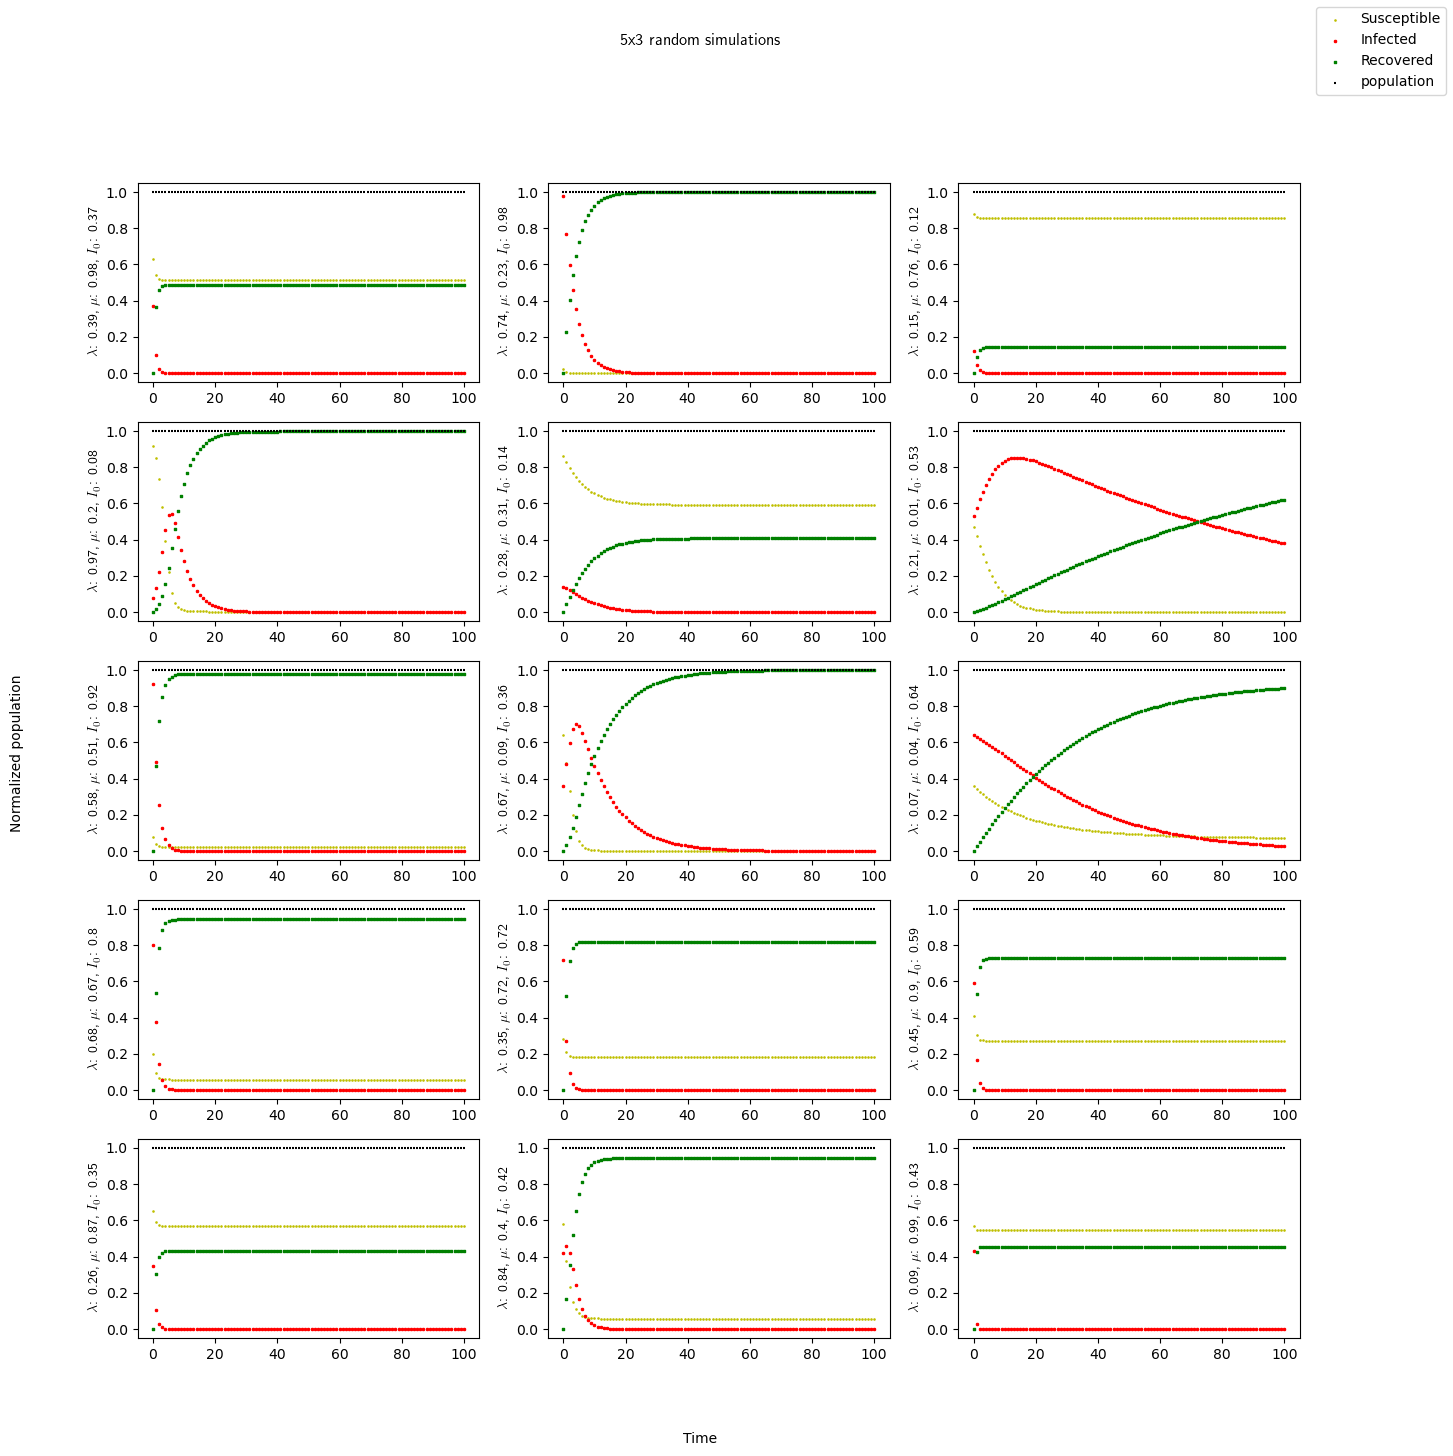

In [18]:
plot_many_random_simulations(n = 5)

With this modification, the dynamics below become more interesting. However for large $\lambda$, the simulation becomes stationary well before t=100. Hence the $\lambda$ should be reduced to a maximum of 0.25.

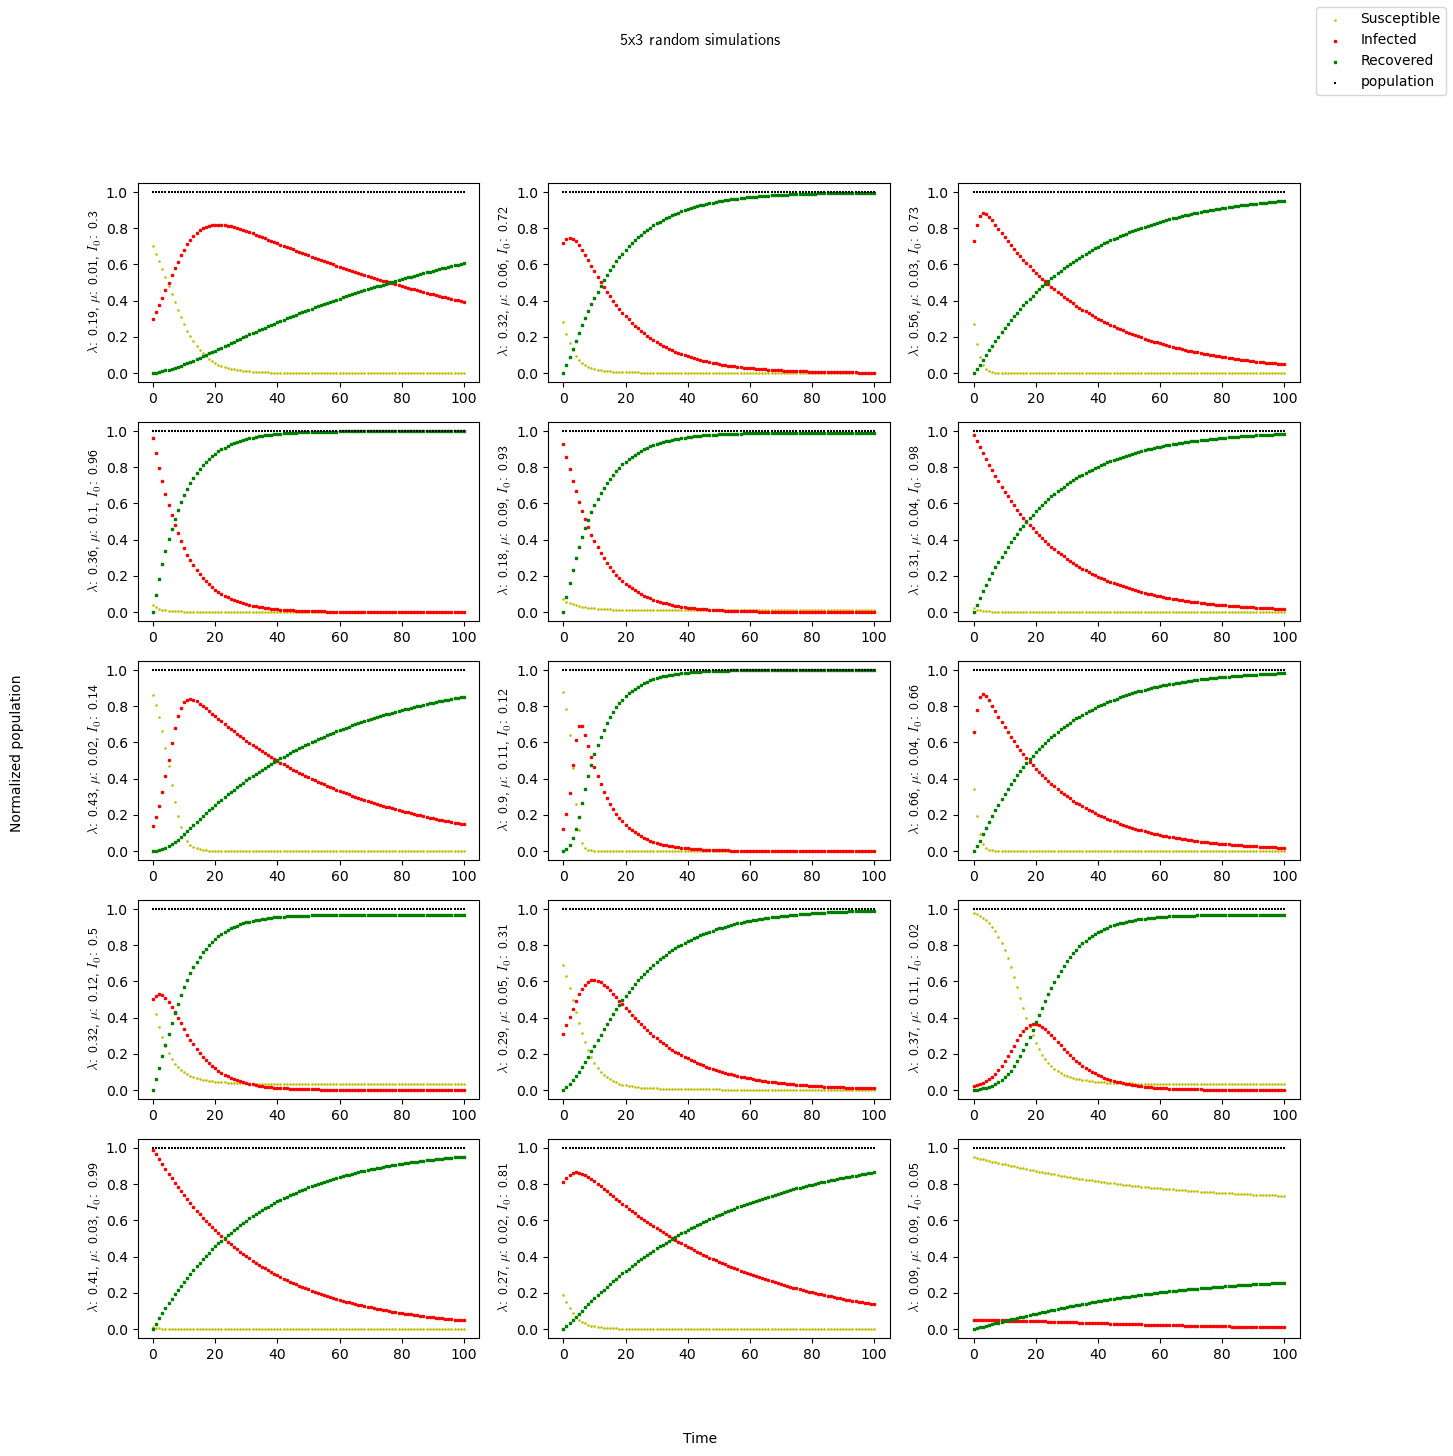

In [19]:
plot_many_random_simulations(n = 5, mu_range=(0.01, 0.15))

The simulations below that have the most change in all compartements over the entire time range are those with small $I_0$. A good choice could be $I_0 \leq 0.15$. 

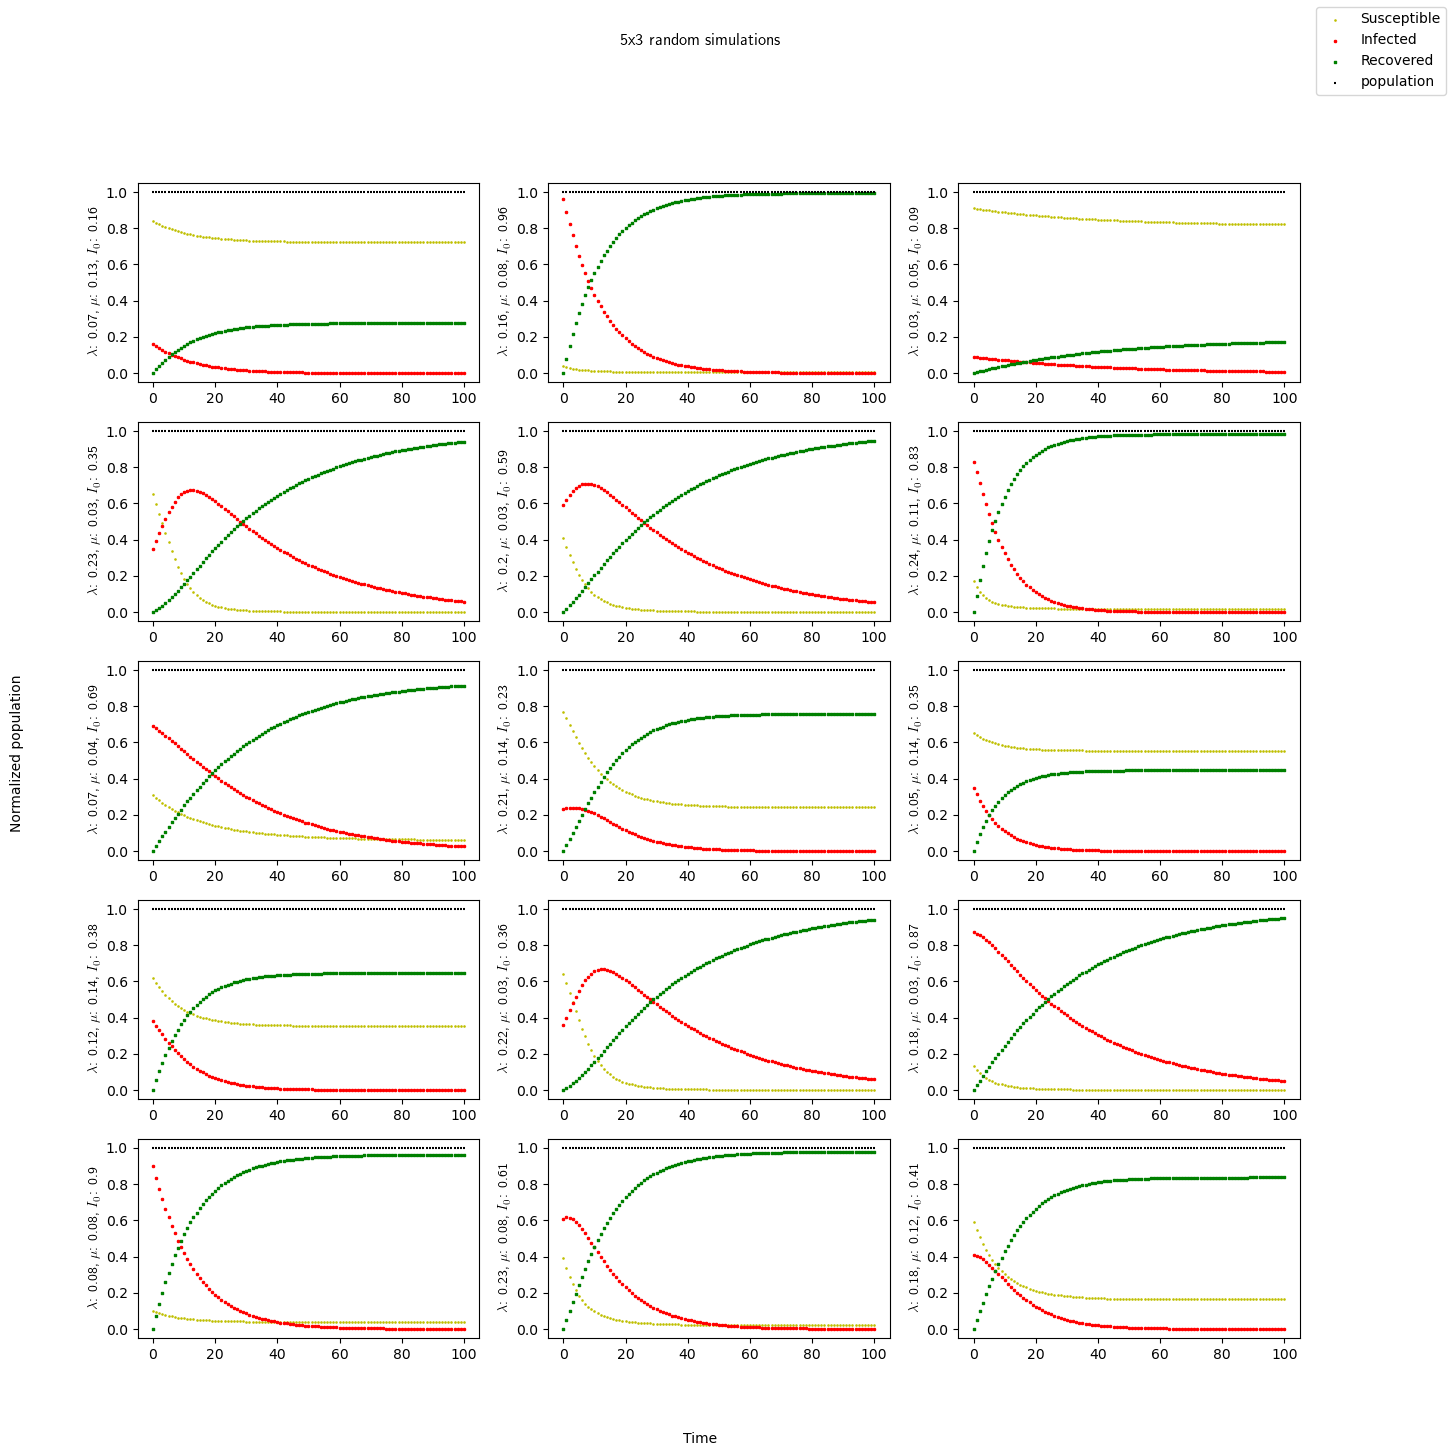

In [20]:
plot_many_random_simulations(n = 5, mu_range=(0.01, 0.15), lam_range=(0.01, 0.25))

The results below look better than the initial ones, however it seems that for too small $\lambda$ the infection spreads too slowly. Hence the minimal $\lambda$ is set to 0.1.

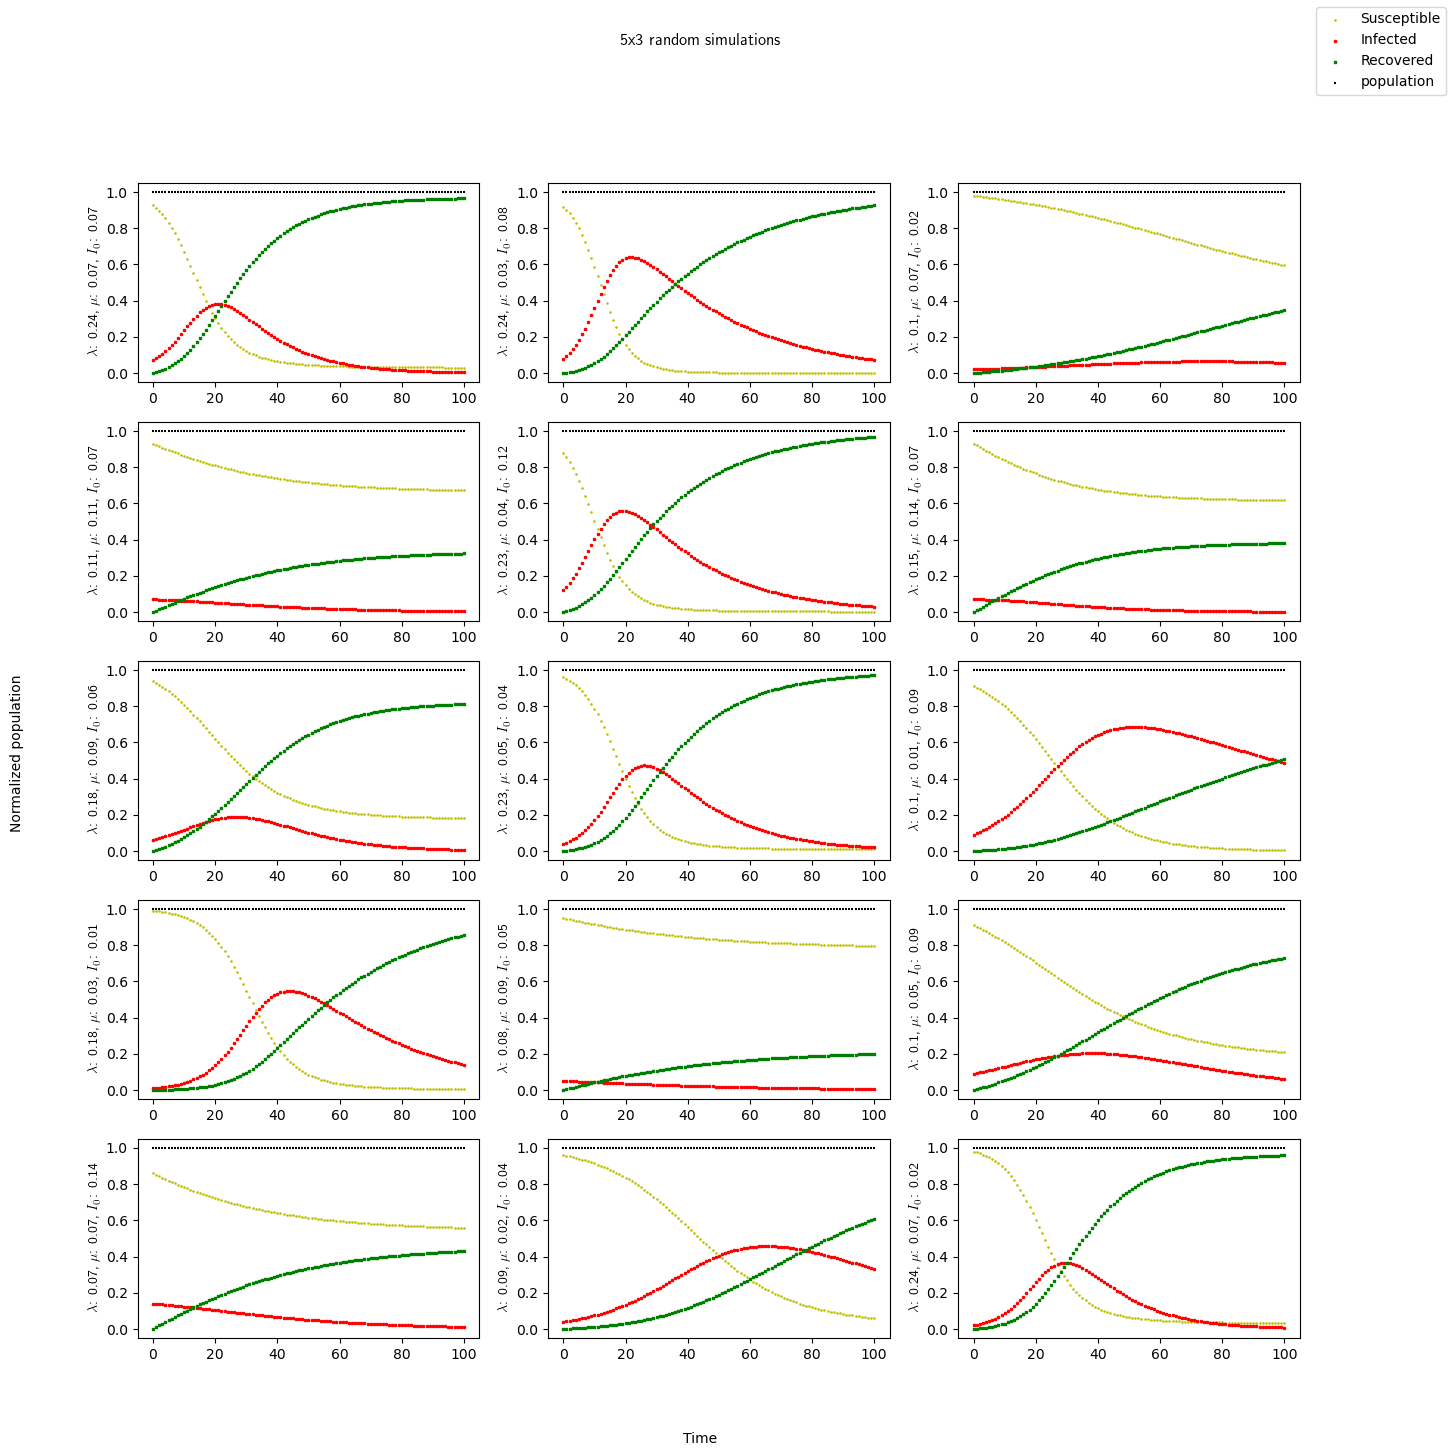

In [21]:
plot_many_random_simulations(n = 5, I_0_range =(0.01, 0.15), mu_range=(0.01, 0.15), lam_range=(0.01, 0.25))

In the plots below, it can be observed that for small $I_0$, it takes too long for the infection to spread if the infection rate is too close to the recovery rate. Hence the minimal $I_0$ is set to 0.05. This is some measure to ensure that at least most of simulations are suitable for training, since $I_0$ can be quite small if the difference between the recovery rate and the infection rate is quite large.

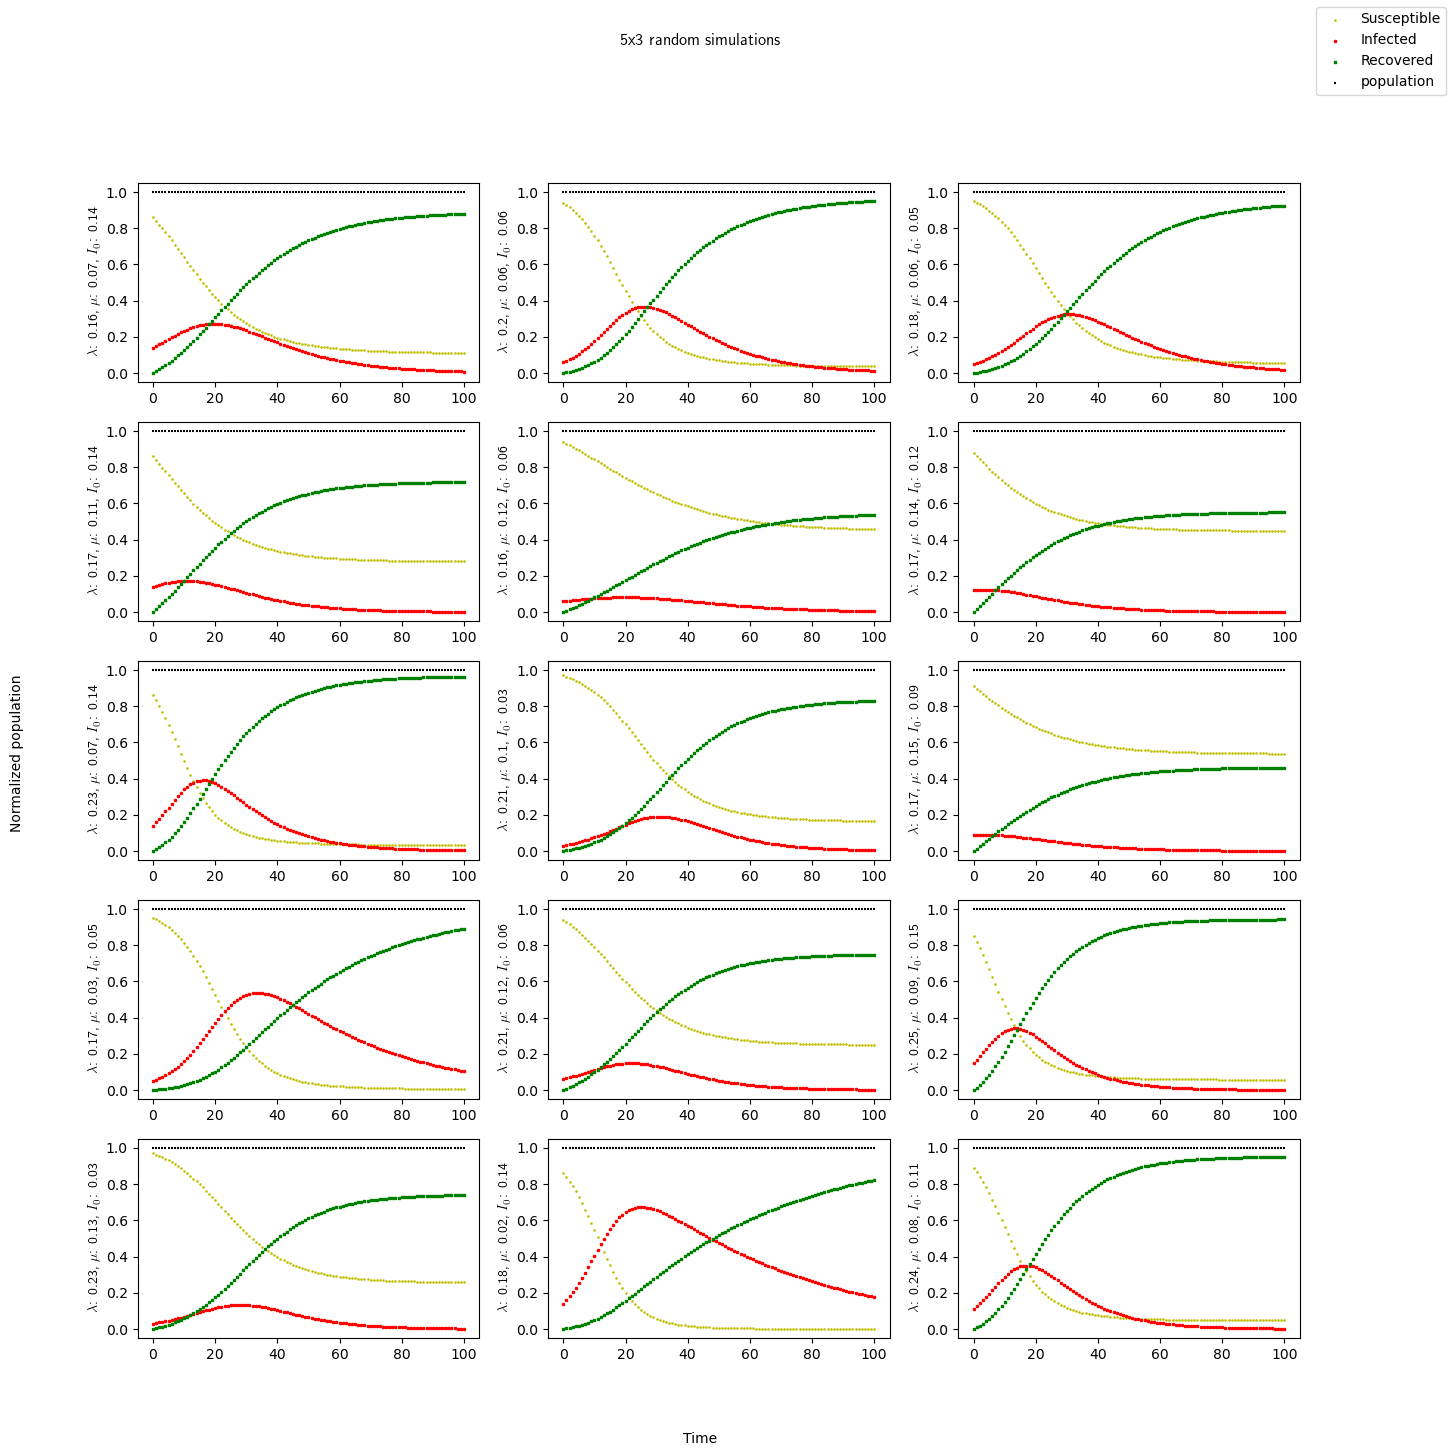

In [22]:
plot_many_random_simulations(n = 5, I_0_range =(0.01, 0.15), mu_range=(0.01, 0.15), lam_range=(0.15, 0.25))

The plots below show that the simulations with $\lambda \in [0.15, 0.25]$, $\mu \in [0.01, 0.15]$, $I_0 \in [0.05, 0.15]$ yield quite "interesting" results. Hence the distributions are
$p^{sim}(Y) = p^{sim}(\lambda) \cdotp p^{sim}(\mu) \cdotp p^{sim}(I_0) = U(0.15, 0.25) \cdotp U(0.01, 0.15) \cdotp U(0.05, 0.15)$

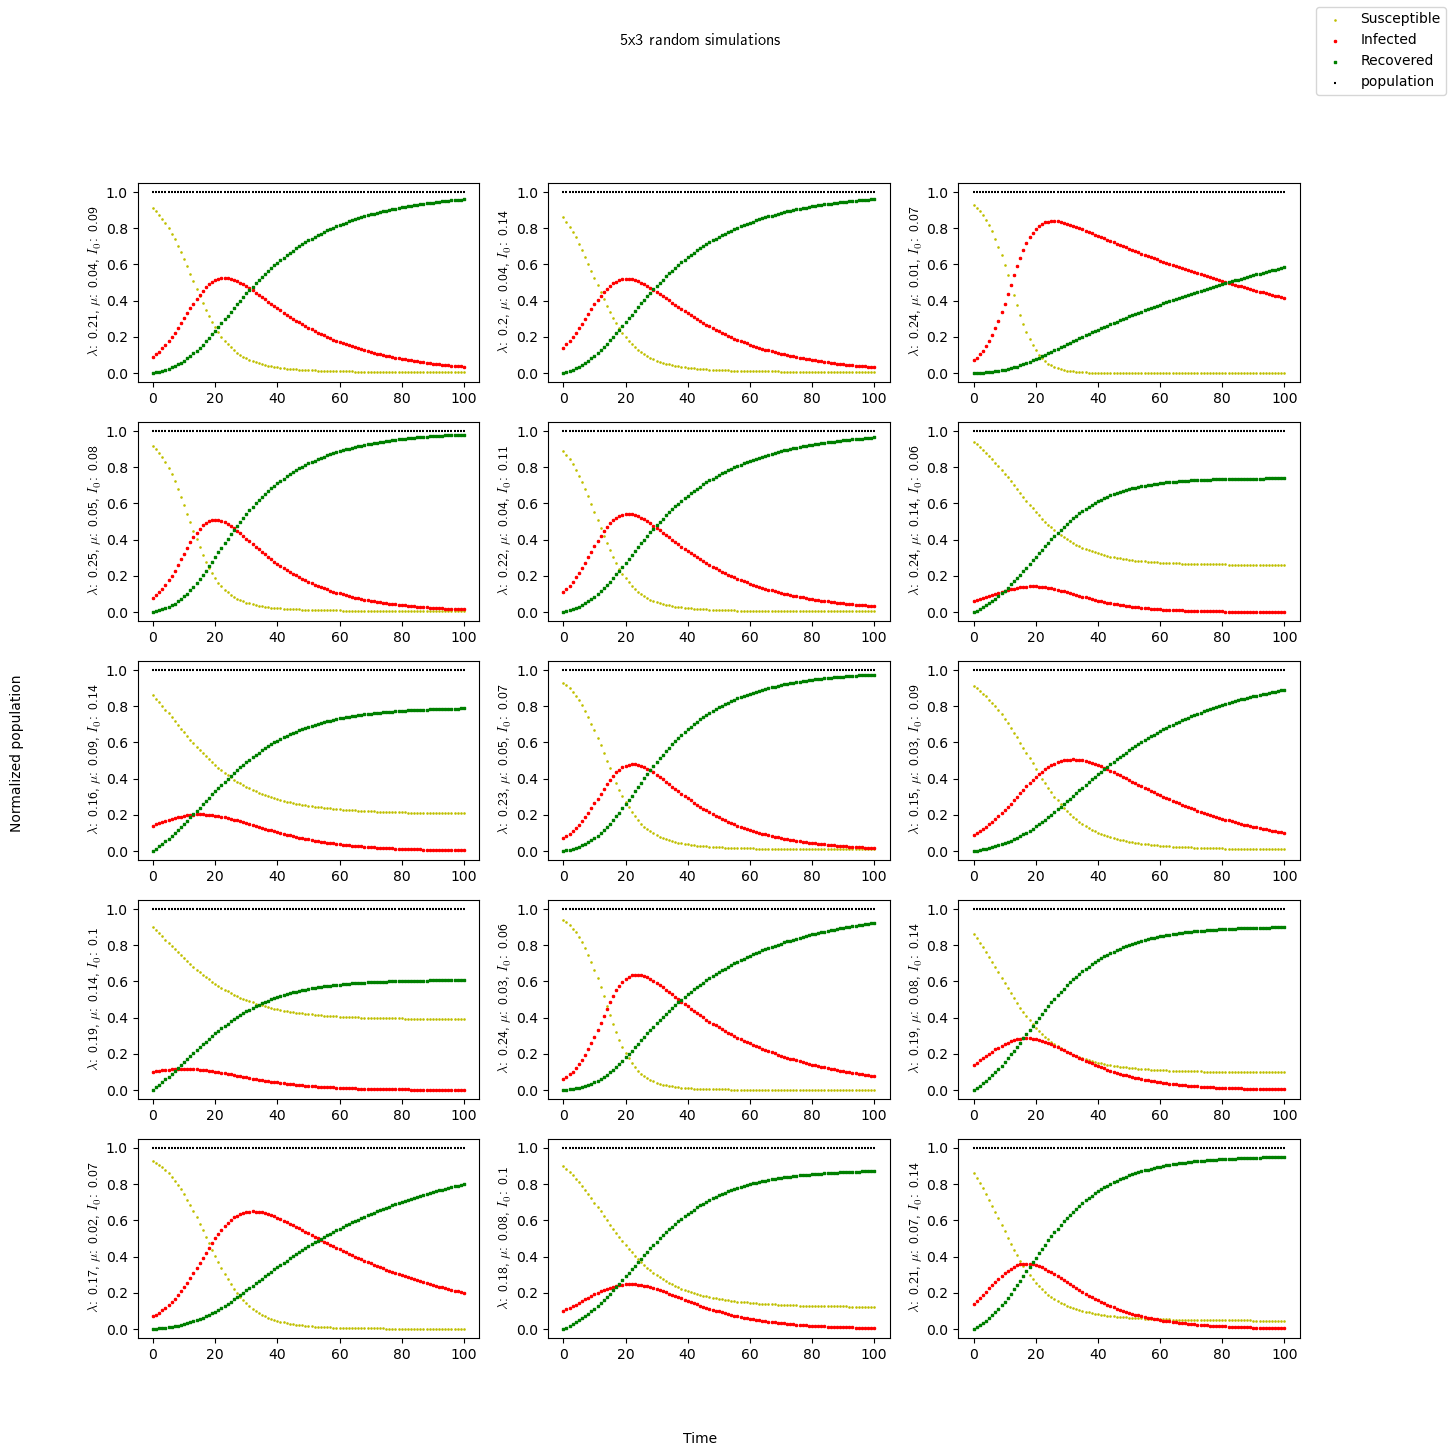

In [23]:
plot_many_random_simulations(n = 5, I_0_range =(0.05, 0.15), mu_range=(0.01, 0.15), lam_range=(0.15, 0.25))

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

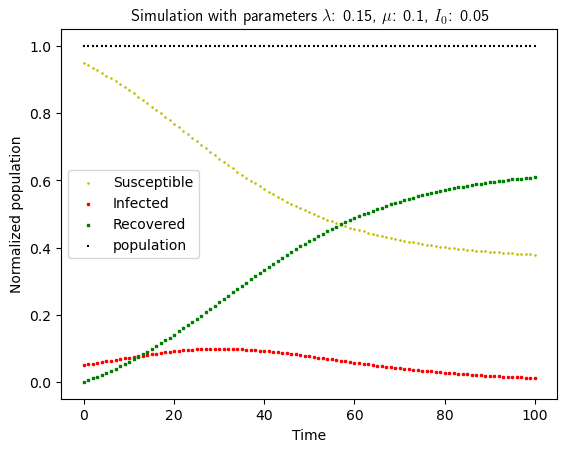

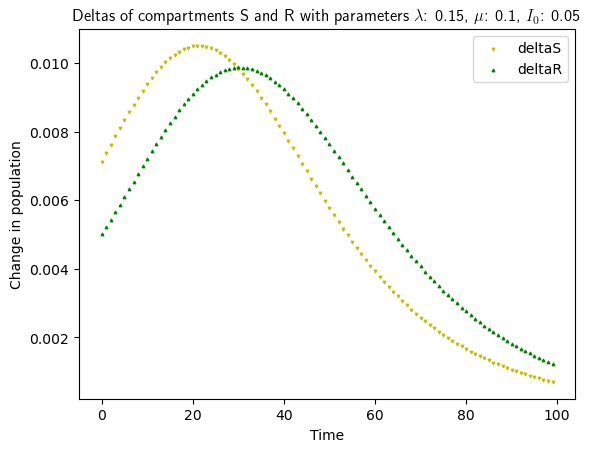

In [24]:
plot_simulation(0.15, 0.1, 0.05, 100)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

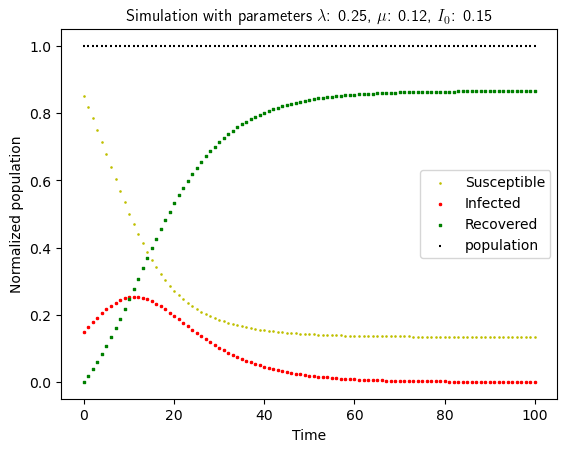

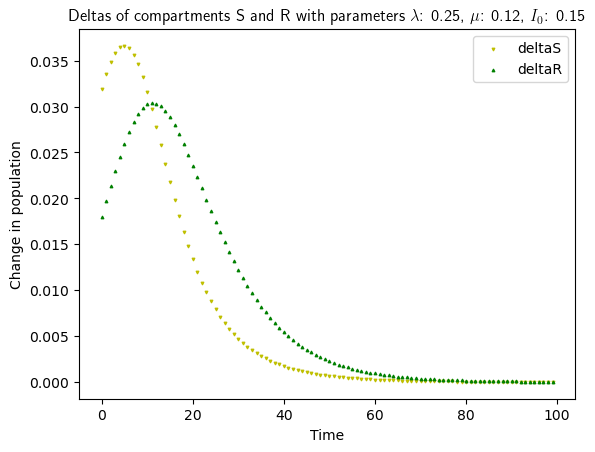

In [25]:
plot_simulation(0.25, 0.12, 0.15, 100)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

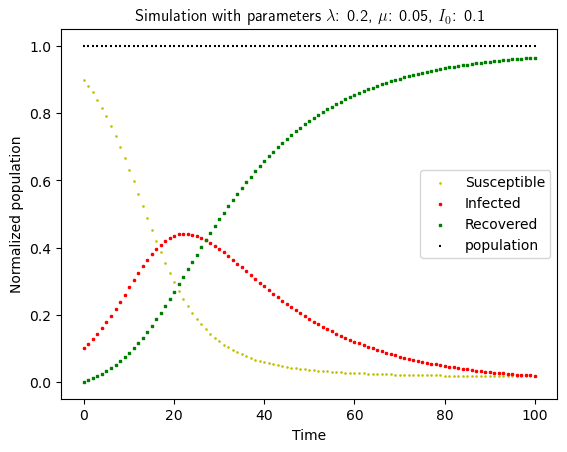

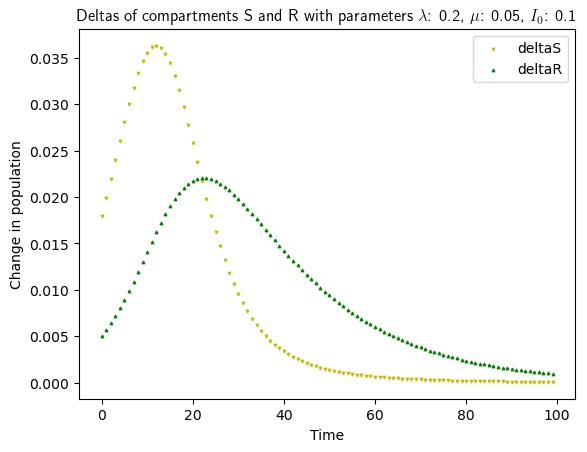

In [26]:
plot_simulation(0.2, 0.05, 0.1, 100)

3. Defne a feed-forward or convolutional network Φ that predicts parameters directly from observations, Yb = Φ(X). Train this network with the squared loss using a training set generated
by the simulation and prior distribution, and evaluate it by a simulated test set. Visualize
the accuracy as a function of hyperparameter choices (especially the sizes of the network and
training set) in suitable diagrams. Note that this network disregards potential uncertainty
and ambiguity of the inverse problem - it just returns a point estimate, i.e. a single vector of
plausible parameters Yb for every given X. For simplicity, the length of the sequence X (i.e.
the stopping time T) shall be constant for all training and testing runs

In [27]:
class ForwardPhi(nn.Module):
    def __init__(self, input_size, output_size, inner_chanel_size, kernel_size):
        super().__init__()
        self.network = nn.Sequential(nn.Conv1d(input_size, inner_chanel_size, kernel_size),
                                     nn.ReLU(),
                                     nn.Conv1d(inner_chanel_size, inner_chanel_size, kernel_size),
                                     nn.ReLU(),
                                     nn.Conv1d(inner_chanel_size, 1, kernel_size),
                                     nn.ReLU(),
                                     nn.LazyLinear(output_size)
        )
    
    def forward(self, X):
        return self.network(X)
    
    def validate(self, X_val, y_val):
        losses = []
        for i in range(len(X_val)):
            x, y = X_val[i], y_val[i]
            prediction = self.forward(x.T)[0]
            loss = nn.MSELoss()
            output = loss(y,prediction)
            losses.append(output.detach().numpy())
        return np.array(losses)
        
    
    def train_network(self, X_train, y_train):
        losses = []
        optimizer = optim.Adam(self.parameters(), lr=0.001)
        for i in range(len(X_train)):
            x, y = X_train[i], y_train[i]
            prediction = self.forward(x.T)[0]
            loss = nn.MSELoss()
            output = loss(y, prediction)

            optimizer.zero_grad()
            output.backward()
            optimizer.step()
            losses.append(output.detach().numpy())
        return np.array(losses)
            
            

In [166]:
def generate_data_sets(training_size, set_size):
    assert set_size > training_size
    data_set = []
    Y = []
    for i in range(set_size):
        #y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15)]
        y = [np.random.normal(0.2, 0.025), np.random.normal(0.08, 0.025),  np.random.normal(0.1, 0.015)]
        sample = simulate_sir_simple(y[0], y[1], y[2], 100)
        deltas = np.array(generate_deltas(sample), dtype=np.float32)
        data_set.append(torch.tensor(deltas))
        Y.append(torch.tensor(y))
    x_train = data_set[:training_size]
    y_train = Y[:training_size]
    x_test = data_set[training_size:]
    y_test = Y[training_size:]
    return x_train, y_train, x_test, y_test 

# Part of task 2

In [29]:
def generate_noisy_data_sets(training_size, set_size):
    assert set_size > training_size
    data_set = []
    Y = []
    for i in range(set_size):
        L = np.random.choice([x for x in range(1, 41)])
        y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15), L, np.random.uniform(0.5, 1), np.random.uniform(0.05, 0.15)] 
        deltas =  np.array(simulate_sir_noisy(y[0], y[1], y[2], y[3], y[4], y[5], 100), dtype=np.float32)
        data_set.append(torch.tensor(deltas))
        Y.append(torch.tensor(y))
    x_train = data_set[:training_size]
    y_train = Y[:training_size]
    x_test = data_set[training_size:]
    y_test = Y[training_size:]
    return x_train, y_train, x_test, y_test 

# Task 1 again

In [30]:
def plot_parameters(input_size=2, output_size=3, inner_chanel_range = (1, 10), kernel_size_range= (1, 20), set_size_range = (1000, 13000), noisy=False):
    generator = lambda y, s: [x for x in range(*y, s)]
    inner_chanel_sizes = generator(inner_chanel_range, 1)
    kernel_sizes = generator(kernel_size_range, 1)
    set_sizes = generator(set_size_range, 3000)

    for set_size in set_sizes:
        if not noisy:
            x_train, y_train, x_test, y_test = generate_data_sets(int(np.floor(0.7 * set_size)), set_size)
        else:
            x_train, y_train, x_test, y_test = generate_noisy_data_sets(int(np.floor(0.7 * set_size)), set_size)
            
                
        mean_validation_errors = []
        final_train_errors = []
        fig, axs = plt.subplots(1, 2, figsize=(15, 15))
        for chanel_size in inner_chanel_sizes:
            final_train_error_column = []
            mean_validation_error_column = []
            for kernel_size in kernel_sizes:
                P = ForwardPhi(input_size, output_size, chanel_size, kernel_size)
                final_train_error_column.append(P.train_network(x_train, y_train)[-1])
                mean_validation_error_column.append(np.mean(P.validate(x_test, y_test)))
            mean_validation_error_column = np.array(mean_validation_error_column).T
            final_train_error_column = np.array(final_train_error_column).T
            mean_validation_errors.append(mean_validation_error_column)
            final_train_errors.append(final_train_error_column)
        

        mean_validation_errors = np.array(mean_validation_errors).T
        final_train_errors = np.array(final_train_errors).T
        axs[0].imshow(final_train_errors, extent=[*inner_chanel_range, *reversed(kernel_size_range)])
        axs[0].set_title(f"Final error in training, |ts|={set_size}")
        axs[1].set_title(f"Avg. validation error, |ts|={set_size}")
        axs[1].set_ylabel("Size of kernel")
        axs[1].set_xlabel("Size of inner chanels")
        axs[0].set_ylabel("Size of kernel")
        axs[0].set_xlabel("Size of inner chanels")
        
        im = axs[1].imshow(mean_validation_errors, extent=[*inner_chanel_range, *reversed(kernel_size_range)])
        fig.subplots_adjust(right=0.8)
        fig.colorbar(im, ax=axs, location="bottom")
        plt.figure()
            
        
                
                
    
    

KeyboardInterrupt: 

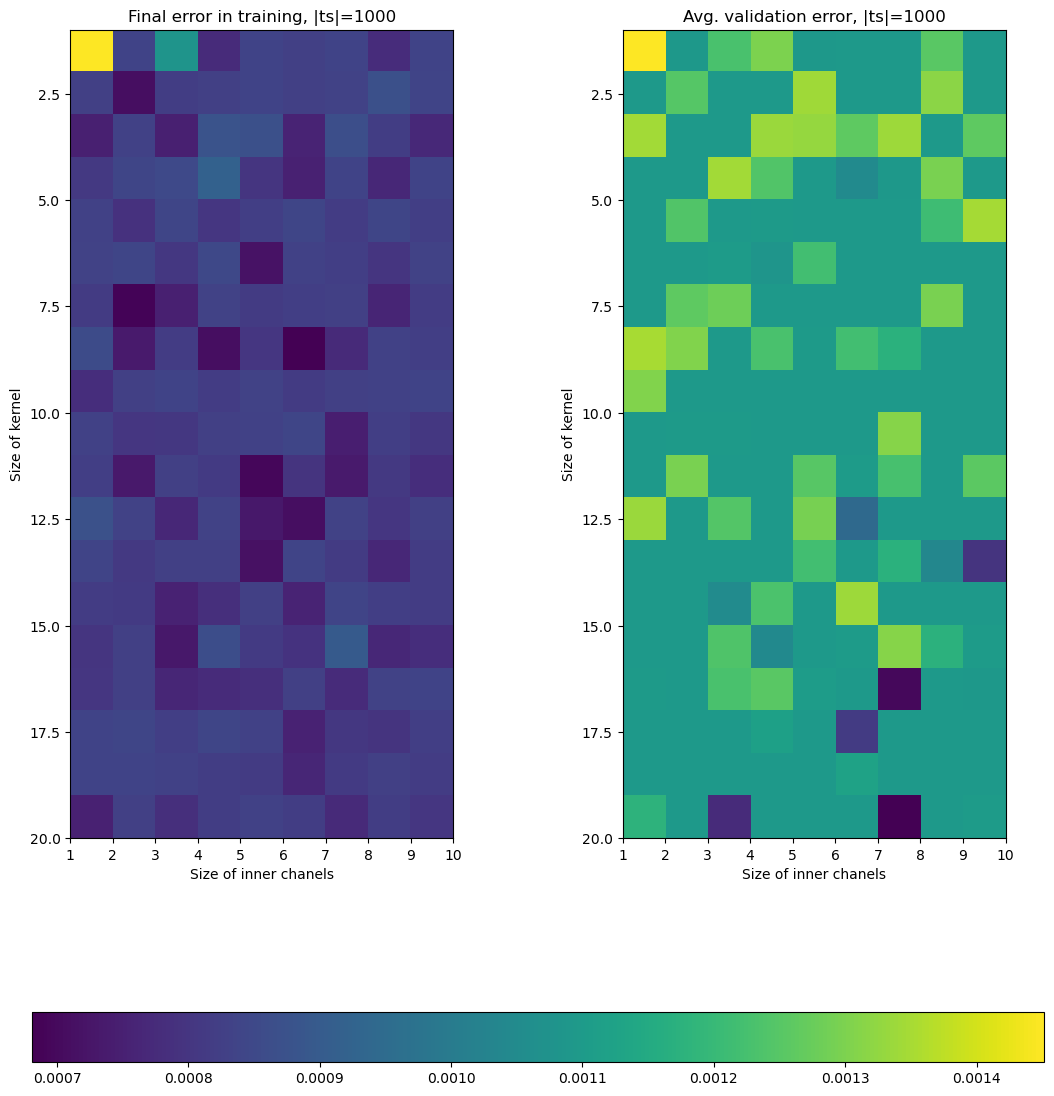

<Figure size 640x480 with 0 Axes>

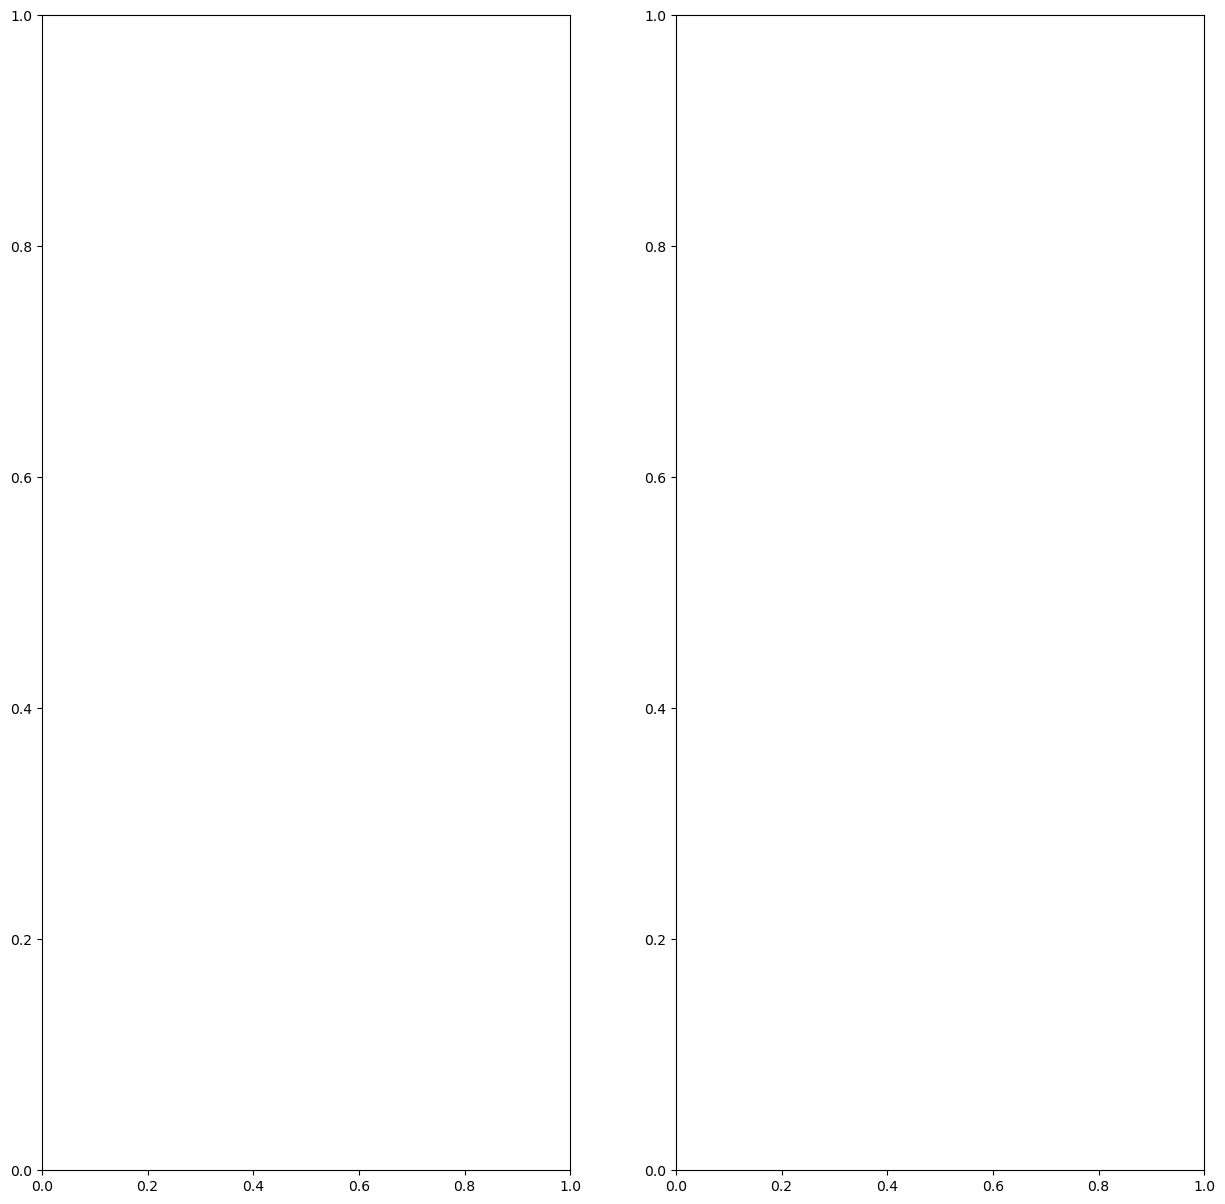

In [31]:
plot_parameters()

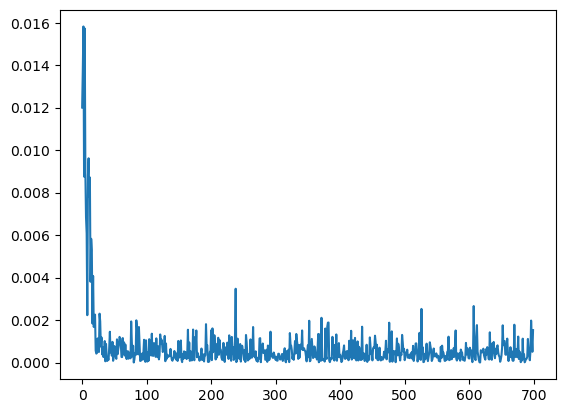

In [182]:
x_train, y_train, x_test, y_test = generate_data_sets(700, 1000)
P = ForwardPhi(2, 3, 6, 16)
losses = P.train_network(x_train, y_train)
plt.plot(losses)

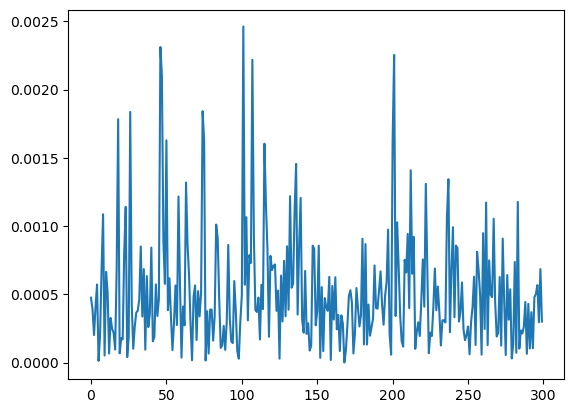

In [183]:
vals = P.validate(x_test, y_test)
plt.plot(vals)

(<Figure size 640x480 with 1 Axes>, <Figure size 640x480 with 1 Axes>)

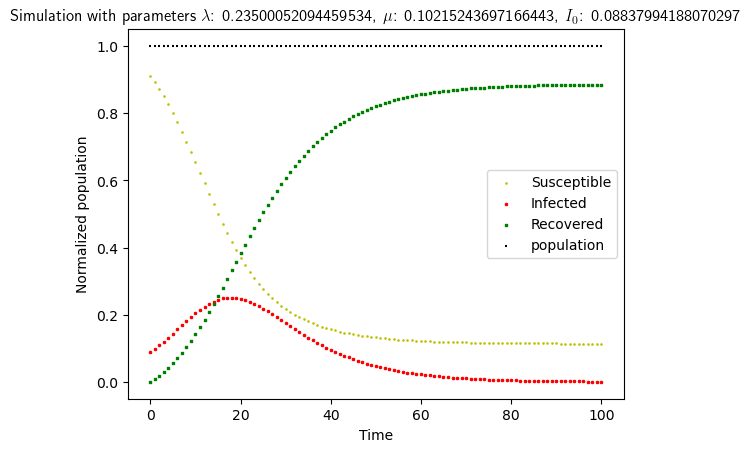

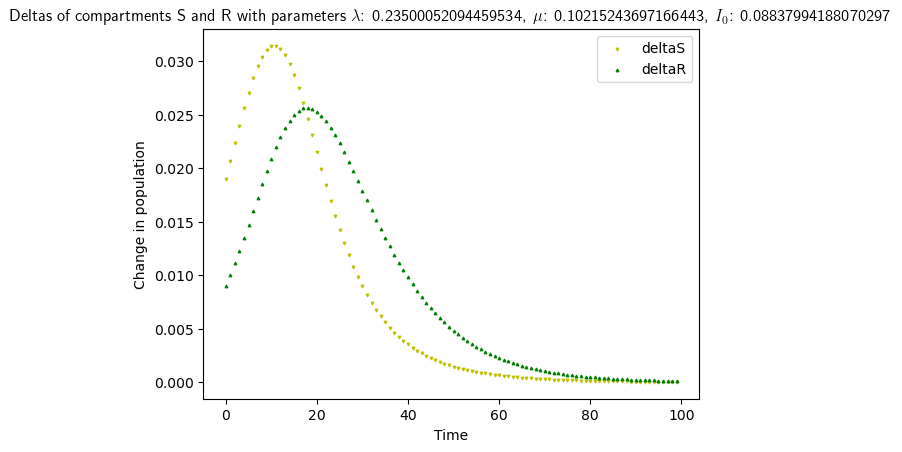

<Figure size 640x480 with 0 Axes>

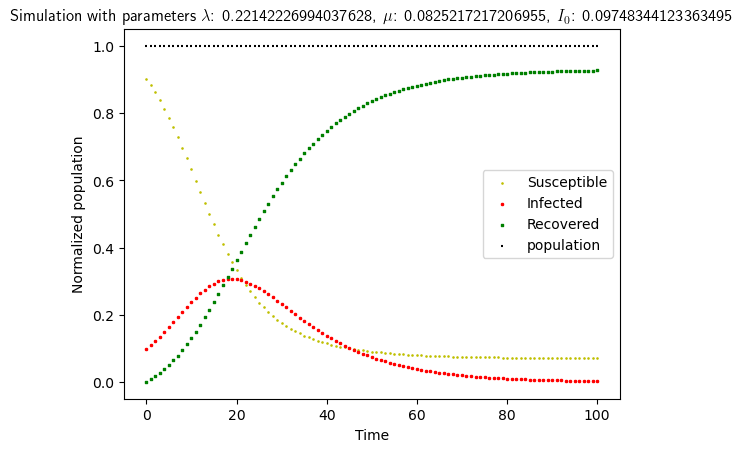

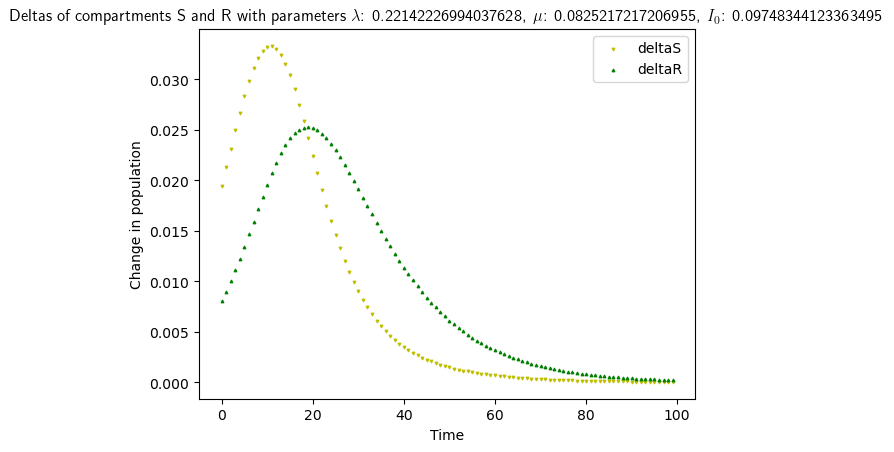

In [184]:
prediction = P.forward(x_test[15].T)[0].detach().numpy()
true = y_test[15]
plot_simulation(*true, 100)
plt.figure()
plot_simulation(*prediction, 100)

In [397]:
class RealNVP_condition(nn.Module):
    def __init__(self, nets, nett, mask, prior,input_size, inner_chanel_size, kernel_size, output_size):
        super(RealNVP_condition, self).__init__()

        self.prior = prior
        self.mask = nn.Parameter(mask, requires_grad=False)
        self.t = torch.nn.ModuleList([nett() for _ in range(len(mask))])
        self.s = torch.nn.ModuleList([nets() for _ in range(len(mask))])

        self.network = nn.Sequential(nn.Conv1d(input_size, inner_chanel_size, kernel_size),
                                    nn.ReLU(),
                                    nn.Conv1d(inner_chanel_size, inner_chanel_size, kernel_size),
                                    nn.ReLU(),
                                    nn.Conv1d(inner_chanel_size, 1, kernel_size),
                                    nn.ReLU(),
                                    nn.LazyLinear(output_size)
        )
    def forward(self, X):
        return self.network(X)

    def f(self, x, X):

        h=self.forward(X)#X batch_size*2*100  h batch_size*1*3 x batch_size*3
        h = torch.squeeze(h, dim=1)#
        log_det_J, z = x.new_zeros(x.shape[0]), x
        for i in (range(len(self.t))):
            z_ = self.mask[i] * z
            s = self.s[i](torch.cat([h,z_], dim=1)) * (1-self.mask[i])#z,h batch_size*3
            t = self.t[i](torch.cat([h,z_], dim=1)) * (1-self.mask[i])
            z = (1 - self.mask[i]) * (z - t) * torch.exp(-s) + z_
            log_det_J -= s.sum(dim=1)

        return z, log_det_J

    def g(self, z, X):
        x = z

        h=self.forward(X)

        h = torch.squeeze(h, dim=1)
        for i in reversed(range(len(self.t))):
            x_ = x*self.mask[i]
            s = self.s[i](torch.cat([h,x_], dim=1))*(1 - self.mask[i])
            t = self.t[i](torch.cat([h,x_], dim=1))*(1 - self.mask[i])
            x = x_ + (1 - self.mask[i]) * (x * torch.exp(s) + t)
        return x


    def log_prob(self,x, X):

        z, logp = self.f(x, X)
        print(z)


        return self.prior.log_prob(z) + logp

    def sample(self, X,num):

        X_copies = X.unsqueeze(0).repeat(num, 1, 1)

        z = torch.randn(num, 3)

        x = self.g(z, X_copies)
        return x

def permutation_matrix(dim):
    matrix = np.eye(dim)
    np.random.shuffle(matrix)
    return torch.tensor(matrix, dtype=torch.float32)

#model
feature_size=1
dim=3
nets = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1,1, 0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior,2,6,16, feature_size)

In [205]:
x_train, y_train, x_test, y_test = generate_data_sets(1000, 2000)

x_train = torch.stack(x_train, dim=0)
x_train = torch.transpose(x_train, 1, 2)
y_train = torch.stack(y_train,dim=0)

In [213]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm


dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(flow.parameters(), lr=0.001)

#Train
num_epochs = 60
loss_list=[]

for epoch in tqdm(range(num_epochs)):
    for data in data_loader:
        x, y = data
        print(x.shape, y.shape)

        loss = -flow.log_prob(y.float(),x.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())


  0%|          | 0/60 [00:00<?, ?it/s]

torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size(


  2%|▏         | 1/60 [00:01<01:55,  1.96s/it]

torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size(


  3%|▎         | 2/60 [00:03<01:51,  1.93s/it]

torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size(


  3%|▎         | 2/60 [00:05<02:53,  2.98s/it]

torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])
torch.Size([8, 2, 100]) torch.Size([8, 3])


KeyboardInterrupt: 

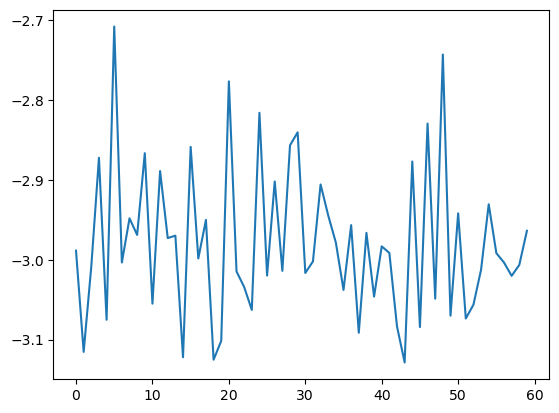

In [207]:
plt.plot(loss_list)

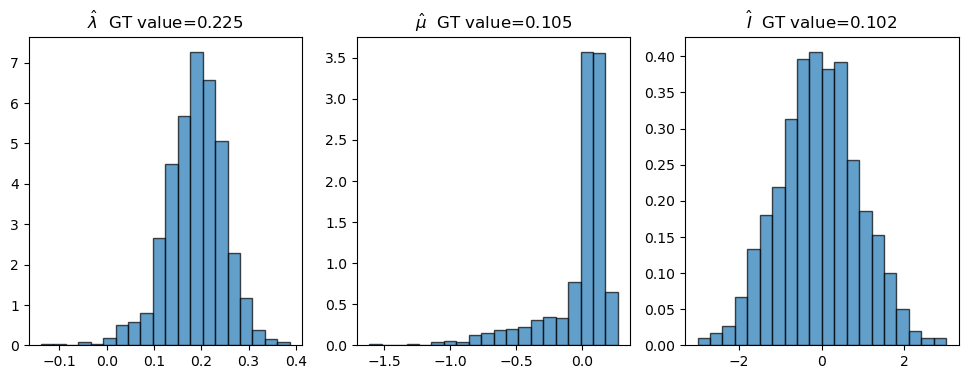

In [210]:
#generate lambda, mu, I for a fixed y: y_test[0]
sample_num=1000

y_fixed=y_test[0]
sample=flow.sample(x_test[0].T,sample_num)
lamda_hat=sample[:,0].detach().numpy()
mu_hat=sample[:,1].detach().numpy()
I_hat=sample[:,2].detach().numpy()



plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(lamda_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{\lambda}$  GT value='+str(round(y_fixed[0].item(), 3)))

plt.subplot(1, 3, 2)
plt.hist(mu_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{\mu}$  GT value='+str(round(y_fixed[1].item(), 3)))

plt.subplot(1, 3, 3)
plt.hist(I_hat, bins=20, edgecolor='black', alpha=0.7,density=True)
plt.title('$\hat{I}$  GT value='+str(round(y_fixed[2].item(), 3)))

plt.show()

(array([0.00114943, 0.        , 0.00057471, 0.00114943, 0.00344828,
        0.00344828, 0.0045977 , 0.00172414, 0.00344828, 0.00862069,
        0.00402299, 0.00517241, 0.00804598, 0.01264368, 0.00977011,
        0.00689655, 0.01494253, 0.0137931 , 0.01896552, 0.00977011,
        0.02183908, 0.02241379, 0.01954023, 0.00804598, 0.02356322,
        0.01954023, 0.01206897, 0.02356322, 0.02873563, 0.02126437,
        0.01321839, 0.03103448, 0.0316092 , 0.02298851, 0.01034483,
        0.01666667, 0.01436782, 0.01954023, 0.01034483, 0.0137931 ,
        0.01034483, 0.00977011, 0.00574713, 0.0091954 , 0.01034483,
        0.0045977 , 0.00229885, 0.00172414, 0.00229885, 0.00172414]),
 array([ 9.  , 10.74, 12.48, 14.22, 15.96, 17.7 , 19.44, 21.18, 22.92,
        24.66, 26.4 , 28.14, 29.88, 31.62, 33.36, 35.1 , 36.84, 38.58,
        40.32, 42.06, 43.8 , 45.54, 47.28, 49.02, 50.76, 52.5 , 54.24,
        55.98, 57.72, 59.46, 61.2 , 62.94, 64.68, 66.42, 68.16, 69.9 ,
        71.64, 73.38, 75.12, 76.86

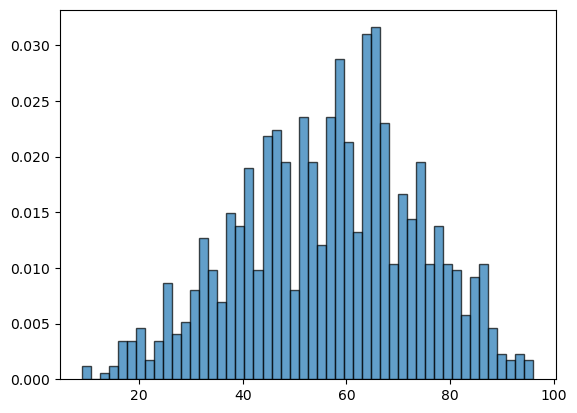

In [211]:
N=100
calibration=[]
para= 0

for i in range(len(x_test)):
    sample=flow.sample(x_test[i].T,N).detach().numpy()
    rank=0
    for j in range(N):
        if y_test[i][para].detach().numpy()>sample[j,para]:
            rank += 1

    calibration.append(rank)
plt.hist(calibration, bins=50,  edgecolor='black', density=True,alpha=0.7)

2 Noisy data
We now extend the basic SIR model with a noise model for the observations. Implement the new
function simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T), which outputs noisy sequences
X˜ = [...]
We assume that the noise is multiplicative Gaussian, i.e. follows the rule
∆S˜(t) = ∆S(t − L) · eS with eS ∼ N (ρ, σ2
)
∆R˜(t) = ∆R(t − L) · eR with eR ∼ N (ρ, σ2
)
The new parameters L ≥ 0, ρ ≤ 1, and σ
2
represent the reporting delay, underreporting fraction
and reporting error variance respectively. Visualize the difference between noise-free outcomes X
and noisy outcomes X˜ to extend good ranges for the new parameters and extend the prior p
sim(Y )
accordingly.
Extend your networks from task 1 to accomodate the additional parameters of the inverse problem.
Repeat the experiments and comment on your fndings.


In [86]:
def plot_noisy_data(n, L_range = (1, 40), rho_range=(0.001, 1), sigma_2_range= (0.01, 2), T=100):
    fig, axs = plt.subplots(n, 2, figsize=(15, 15))
    time_range = [t for t in range(T)]
    fig.suptitle("Deltas of compartments S and R with parameters")
    fig.text(0.5, 0.04, 'Time', ha='center')
    fig.text(0.04, 0.5, 'Change in population', va='center', rotation='vertical')
    for i in range(n):
        rho = round(np.random.uniform(*rho_range), 2)
        sigma_2 = round(np.random.uniform(*sigma_2_range), 2)
        L = np.random.choice([x for x in range(*L_range)])
        y = [np.random.uniform(0.15, 0.25), np.random.uniform(0.01, 0.15), np.random.uniform(0.05, 0.15)]
        time_range_shifted = [t for t in range(L, T)]
        results = simulate_sir_simple(*y, T)
        deltas = generate_deltas(results)
        noisy_deltas = generate_deltas(results, L, rho, sigma_2)
        

        
        axs[i, 0].set_ylabel(f" $\lambda$: {round(y[0], 2)}, $\mu$: {round(y[1], 2)}, $I_0$: {round(y[2], 2)}", usetex = True)
        axs[i, 0].scatter(time_range, deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
        axs[i, 0].scatter(time_range, deltas[:, 1], marker="^", s=3, color="g", label="deltaR")
        
        axs[i, 1].set_ylabel(f"L: {L}, $p$: {rho}, $\sigma^2$: {sigma_2}", usetex = True)
        axs[i, 1].scatter(time_range, noisy_deltas[:, 0], marker="v", s=3, color="y", label="deltaS")
        axs[i, 1].scatter(time_range, noisy_deltas[:, 1], marker="^", s=3, color="g", label="deltaR")


        axs[i, 0].legend()
        axs[i, 1].legend()

In the plots below, it can be observed that not much happens beyond t=60, hence L should be at most 40. Also for to large $\sigma^2$, the curves get too noisy. Hence $\sigma^2$ < 0.15 should be sufficient. For $\rho$, the assumption that at least 50% of the cases get actually registered should be suitable, even tho it is arbitrary.

In [ ]:
plot_noisy_data(5)

The results below look valod, yielding the distributions $p^{sim}(Y) = p^{sim}(\lambda) \cdotp p^{sim}(\mu) \cdotp p^{sim}(I_0)p^{sim}(L)p^{sim}(\rho)p^{sim}(\sigma^2)    = U(0.15, 0.25) \cdotp U(0.01, 0.15) \cdotp U(0.05, 0.15)\cdotp U(1, 40)\cdotp U(0.5, 1)\cdotp U(0.05, 0.1)$

In [ ]:
plot_noisy_data(5, L_range=(0, 40), sigma_2_range=(0.05, 0.15), rho_range=(0.5, 1))

In [87]:
def simulate_sir_noisy(lam, mu, I_0, L, rho, sigma_2, T):
    results = simulate_sir_simple(lam, mu, I_0, T)
    return generate_deltas(results, L = L, rho=rho, sigma_2=sigma_2)

In [ ]:
x_train, y_train, x_test, y_test = generate_noisy_data_sets(700, 1000)
P = ForwardPhi(2, 6, 4, 14)
losses = P.train_network(x_train, y_train)
plt.plot(losses)

In [ ]:
vals = P.validate(x_test, y_test)
plt.plot(vals)

In [ ]:
plt.plot(x_train[0])

In [ ]:
P = 

In [ ]:
plot_parameters(input_size=2, output_size=6, noisy=True)

In [ ]:
prediction = P.forward(x_test[15].T)[0].detach().numpy()
true = y_test[15]
plot_simulation(*true[:3], 100)
plt.figure()
plot_simulation(*prediction[:3], 100)

In [88]:
feature_size=5
dim=6
nets = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[1,1, 1,0,0,0]] * 6).astype(np.float32))
for i in range(len(masks)):
  masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior,2,6,16,feature_size)

In [89]:
x_train, y_train, x_test, y_test = generate_noisy_data_sets(2000, 4000)

x_train = torch.stack(x_train, dim=0)
x_train = torch.transpose(x_train, 1, 2)
y_train = torch.stack(y_train,dim=0)

In [ ]:


import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt







dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=32, shuffle=True)



optimizer = optim.Adam(flow.parameters(), lr=0.001)

#Train
num_epochs = 100
loss_list=[]

for epoch in range(num_epochs):
    for data in data_loader:
        x, y = data



        loss = -flow.log_prob(y.float(),x.float()).mean()

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())

In [ ]:
parameters=['\hat{\lambda}','\hat{\mu}','\hat{I}','\hat{L}','\hat{\\rho}','\hat{\sigma^2}']
sample_num=1000

y_fixed=y_test[0]
sample=flow.sample(x_test[0].T,sample_num)

plt.figure(figsize=(12, 8))
for i in range(len(parameters)):
  plt.subplot(2, 3, i+1)
  plt.hist(sample[:,i].detach().numpy(), bins=30, edgecolor='black', alpha=0.7,density=True)
  plt.title(f'${parameters[i]}$  GT value='+str(round(y_fixed[i].item(), 3)))
  

plt.subplots_adjust(hspace=0.5)
plt.show()


In [ ]:
#calibration
N=100
parameters=['\hat{\lambda}','\hat{\mu}','\hat{I}','\hat{L}','\hat{\\rho}','\hat{\sigma^2}']

calibration=[]

for i in range(len(x_test)):
  sample=flow.sample(x_test[i].T,N).detach().numpy()
  rank=np.zeros(len(parameters))
  for j in range(N):
    for k in range(len(rank)):
      if y_test[i][k].detach().numpy()>sample[j,k]:
        rank[k] +=1/N
  calibration.append(rank)




from scipy.stats import binom
parameters=['\hat{\lambda}','\hat{\mu}','\hat{I}','\hat{L}','\hat{\\rho}','\hat{\sigma^2}']
plt.figure(figsize=(12, 8))
plt.figure(figsize=(12, 8))
for i in range(len(parameters)):
  plt.subplot(2, 3, i+1)
  plt.hist([sequence[i] for sequence in calibration], bins=100, edgecolor='black', alpha=0.7)

  lower_bound = binom.ppf(0.005, len(x_test), 1/N)
  upper_bound=binom.ppf(0.995, len(x_test), 1/N)
  plt.axhspan(lower_bound, upper_bound, color='gray', alpha=0.3, label='Confidence Interval')
  plt.title(f'${parameters[i]}$  ')
  plt.xlabel('Rank Statistic')
  

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Calibration')
plt.show()

In [ ]:
# CDF method
def plot_r(parameters):
  t=np.linspace(0, 1, 100)
  r=[]
  for i in t:


    cdf=0
    for j in range(2000):
      
      if parameters[j]<=i:
        cdf +=1/2000
    r.append(np.sqrt(N)*(cdf-i)/2)
      
  
  plt.plot(t,r)

In [ ]:
parameters=['\hat{\lambda}','\hat{\mu}','\hat{I}','\hat{L}','\hat{\\rho}','\hat{\sigma^2}']
plt.figure(figsize=(12, 8))

for i in range(len(parameters)):
  plt.subplot(2, 3, i+1)
  plot_r([sequence[i] for sequence in calibration])
  t = np.linspace(0, 1, 100)
  y = np.sqrt(t * (1 - t))
  plt.fill_between(t, -y,y, color='blue', alpha=0.3, label='Shaded Area')
  plt.title(f'${parameters[i]}$  ')
  plt.xlabel('Rank Statistic')
  plt.ylim(-1, 1)
  

plt.subplots_adjust(hspace=0.5)
plt.suptitle('Calibration')
plt.show()

# Task 3
3 Model misspecification detection
We now modify the training of the networks from task 1: In addition to the NLL loss, we use an
MMD loss on the output of the summary network h(X) to pull the distribution p(h(x)) towards a
standard normal N (0, I). This allows us to recognize unusual simulation outcomes Xbad as outliers
of p(h(x_bad)), i.e. outliers to the standard normal, for example via the standard χ
2
test.

First, use test data generated by simulate_sir_simple() to make sure that the null hypothesis All
h(X) follow the desired standard normal. cannot be rejected for noise-free data at common choices
of the χ
2
test's p-value (e.g. 1%). Fine-tune your hyperparameters if this is not the case

Now, use test data created with simulate_sir_noisy() and determine under which conditions the
mismatch between the model assumptions (outcomes are noise-free) and the actual data (noisy
outcomes) is detected by the χ
2
test. Test with increasing noise levels and increasing test set size
 both should facilitate the detection. Comment on your 
ndings



In [342]:
x_train, y_train, x_test, y_test = generate_noisy_data_sets(400, 100)

x_train = torch.stack(x_train, dim=0)
x_train = torch.transpose(x_train, 1, 2)
y_train = torch.stack(y_train,dim=0)

AssertionError: 

In [309]:
#Redefine the MMD function we defined at last assignment with tensor form
def squared_distances(X, Y):
    """
    Compute the squared Euclidean distances between each pair of points in the two datasets X and Y.

    :param X: Array of shape (n_samples_X, n_features).
    :param Y: Array of shape (n_samples_Y, n_features).
    :return: Matrix of shape (n_samples_X, n_samples_Y) where each element represents the squared distance.
    """
    # Expand the squares of X and Y
    X_square = torch.sum(X**2, dim=1, keepdim=True)
    Y_square = torch.sum(Y**2, dim=1, keepdim=True)

    # Compute the squared distances
    squared_dist = X_square  -2 * torch.matmul(X, Y.T + Y_square.T)
    return squared_dist

def se_kernel_custom(X, Y, gamma=None):
    """
    Compute the Radial Basis Function (RBF) kernel (squared exponential) between each pair of points in X and Y.

    :param X: First dataset.
    :param Y: Second dataset.
    :param gamma: Gamma parameter for the RBF kernel. If None, it's set to 1/n_features.
    :return: RBF kernel matrix.
    """
    if gamma is None:
        gamma = 1.0 / X.shape[1]  # 1/n_features

    sq_dists = squared_distances(X, Y)
    return torch.exp(-gamma * sq_dists)

def compute_mmd(kernel_XX, kernel_YY, kernel_XY):
    """
    Compute the MMD value from the kernel matrices.
    :param kernel_XX: Kernel matrix among samples in X.
    :param kernel_YY: Kernel matrix among samples in Y.
    :param kernel_XY: Kernel matrix between samples in X and Y.
    :return: MMD value.
    """
    mmd_square = torch.mean(kernel_XX) + torch.mean(kernel_YY) - 2 * torch.mean(kernel_XY)
    return torch.sqrt(mmd_square)  # Return the square root to get MMD

In [398]:
import torch
from sklearn.datasets import make_moons
from torch import nn, optim
from torch.autograd import Variable
from torchvision import transforms, datasets
from torch.utils.data import DataLoader, TensorDataset
from torchvision.utils import save_image
import os
import matplotlib.pyplot as plt
from tqdm import tqdm




#model
feature_size=6
dim=6
nets = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim), nn.Tanh())
nett = lambda: nn.Sequential(nn.Linear(dim+feature_size, 256), nn.LeakyReLU(), nn.Linear(256, 256), nn.LeakyReLU(), nn.Linear(256, dim))
masks = torch.from_numpy(np.array([[np.random.choice((0,1)) for i in range(dim)]] * 6).astype(np.float32))
for i in range(len(masks)):
    masks[i]=torch.matmul(permutation_matrix(dim),masks[i])
prior = distributions.MultivariateNormal(torch.zeros(dim), torch.eye(dim))
flow = RealNVP_condition(nets, nett, masks, prior,2,6,16, feature_size)



dataset = TensorDataset(x_train, y_train)
data_loader = DataLoader(dataset, batch_size=8, shuffle=True)

optimizer = optim.Adam(flow.parameters(), lr=0.001)

#Train
num_epochs = 10
loss_list=[]

samples = torch.normal(0,1, (1000, feature_size))

gamma=0.05
for epoch in tqdm(range(num_epochs)):
    for data in data_loader:
        x, y = data
        h = flow.forward(x)
        h = torch.squeeze(h, dim=1)
        kernel_XX_se = se_kernel_custom(h, h,gamma=gamma)
        kernel_YY_se = se_kernel_custom(samples, samples,gamma=gamma)
        kernel_XY_se = se_kernel_custom(h, samples,gamma=gamma)
        loss_MMD=compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)
        print(loss_MMD)
        loss = -flow.log_prob(y.float(),x.float()).mean() + 1*loss_MMD

        # Backward
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()


    loss_list.append(loss.item())


  0%|          | 0/10 [00:00<?, ?it/s]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 2.4024e-01,  1.8888e-01, -6.2299e-02,  3.4373e+01,  9.2668e-01,
          1.1961e-01],
        [ 3.3442e-01,  2.1028e-01, -9.5535e-02,  4.3731e+00,  8.4743e-01,
          9.5787e-02],
        [ 2.9751e-01,  2.6762e-01, -3.6478e-02,  3.7823e+01,  8.8295e-01,
          1.5397e-01],
        [ 2.7933e-01,  1.8842e-01, -5.0106e-02,  1.9954e+01,  7.4048e-01,
          1.3241e-01],
        [ 2.4229e-01,  2.7875e-01, -4.4256e-02,  4.3738e+00,  8.7867e-01,
          1.2586e-01],
        [ 3.0557e-01,  2.0888e-01, -4.5554e-02,  6.6079e+00,  8.9965e-01,
          1.4877e-01],
        [ 2.7608e-01,  2.7961e-01, -3.2738e-02,  4.3332e+01,  1.1585e+00,
          9.4081e-02],
        [ 3.0364e-01,  2.9302e-01, -6.0413e-02,  3.2634e+00,  1.1191e+00,
          1.0218e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1021,  0.2352, -0.1533, 19.7512,  1.1158,  0.1379],
        [ 0.1697,  0.2563, -0.1523,  5.2949,  0.713

tensor([[-0.4831, -0.3292, -0.6376, -0.5064, -0.3822, -0.2471],
        [-0.0680, -0.0674,  0.0882, -0.1777, -1.6139, -0.0214],
        [-0.3463,  0.7760,  0.2783, -0.7332, -2.0944,  0.7330],
        [ 0.0100,  0.1399, -0.1691, -0.6024, -1.8090,  0.8262],
        [-0.1147,  0.1431, -0.3458, -0.2712, -1.2725,  0.3825],
        [-0.5586, -0.0932, -0.3282, -0.1997, -1.2738, -0.3196],
        [-0.6815,  0.7719,  0.5575, -0.8336, -1.5981, -0.1112],
        [-0.1651,  1.2692,  0.4625, -0.6353, -1.9652,  0.7588]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2582,  0.7832,  0.2894, -0.5757, -0.0762,  0.0341],
        [-0.0533, -0.6188, -0.7978, -0.3634,  1.6000, -0.3912],
        [ 0.1028, -0.2303, -0.0489, -0.1997, -0.5538,  0.3575],
        [-0.3788,  0.9708,  0.5977, -0.7501,  1.9584, -0.2736],
        [-0.1986,  0.8030, -0.1482, -0.5266,  0.4383,  0.7341],
        [-0.2837,  0.6758, -0.2259, -0.8807,  0.2861,  0.0783],
        [-0.4550, -0.0671, -0.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.8308, -1.2701,  1.7056, -0.4898, -1.0622, -0.5583],
        [-0.1060, -1.2032,  0.0720, -0.1859, -1.1957, -1.4658],
        [-0.2336,  0.1843, -0.4739, -0.4065, -0.4252,  0.0115],
        [-1.3225, -1.6377, -0.0645, -0.0352,  0.5100, -0.8396],
        [ 0.7637, -0.2671,  0.5515, -0.0969, -1.3604, -0.9650],
        [-0.5409, -0.9666,  1.1040,  0.3569, -1.0069, -0.0115],
        [ 0.1911, -1.1554, -0.2294,  0.2164, -1.4069, -0.0406],
        [ 0.6784,  0.0120,  0.7502, -0.2298,  0.1169, -0.6046]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1686, -0.6237, -0.0036,  0.1213,  1.6537,  1.1790],
        [-0.6210, -1.1641,  2.1162, -0.5989, -0.5793, -0.7921],
        [-0.2532, -0.8447,  1.5655,  0.2578,  0.9247, -0.0989],
        [-0.4761, -1.5069,  0.7800,  0.5196, -0.3708,  0.3639],
        [-1.0528, -0.4806,  0.9324,  0.1947, -1.1943,  1.4347],
        [-0.4473, -0.6171,  1.5758, -0.3189,  1.1492

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.6717,  1.2194,  0.8680,  0.1795, -0.5790,  1.9866],
        [ 0.0187, -1.4775,  1.6885,  1.1867,  0.3727,  0.3310],
        [ 1.2919,  0.0960,  0.8140, -0.5729, -1.0993, -1.5508],
        [ 0.6684, -0.0281,  1.7747,  0.5536, -0.3650,  0.3121],
        [-0.2420, -1.0680, -0.2933,  0.1155, -1.0992, -0.2855],
        [ 1.2339,  0.9838,  0.3210, -0.6068,  1.0752,  1.4221],
        [-1.4071,  1.2031,  0.0142,  1.0377,  1.4834, -1.2382],
        [ 1.1982, -0.0919,  0.1582, -0.6851,  0.0751, -0.4642]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4331,  0.4109,  1.3529,  0.1749,  0.4801,  1.2689],
        [ 0.4636,  1.1045,  0.3135, -0.0765,  1.9597,  1.2524],
        [ 0.4633, -0.4296,  0.3902,  1.1520,  0.1396,  0.8376],
        [-0.6701,  0.4669,  1.3300,  0.1372,  1.2082, -0.4538],
        [-0.9641,  0.4132, -0.3426, -0.4315, -0.6650, -0.6661],
        [ 0.4796, -0.6888,  0.0374, -0.5921, -0.8676

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3591,  0.7497, -1.3348, -0.3784,  0.5353,  1.6946],
        [ 0.9568, -0.2488,  0.9967, -0.4832, -0.8793,  0.4691],
        [-0.9480,  0.8755,  1.3621,  0.3851,  1.2964, -1.1002],
        [-1.1879, -0.3900, -1.2902,  0.5157, -1.3107, -0.3554],
        [-0.9135,  0.1012,  1.2915,  0.7524,  0.4830, -0.1355],
        [ 0.5103, -0.1525,  0.3438,  0.6071, -0.7273,  1.2734],
        [-1.4568,  1.2226,  1.3601, -0.8529, -1.5147, -0.5650],
        [-0.0773,  0.2723, -0.0299,  0.9108, -1.4212, -0.1856]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7215,  1.6241, -0.7532, -0.5933,  0.3593,  1.1874],
        [-1.0460,  1.1985,  0.4670, -1.0628, -0.1499,  0.7903],
        [-1.9938,  1.7971, -0.4267,  0.9568,  0.9730, -0.8521],
        [-2.3226,  1.2973, -1.2772, -0.9727, -0.3237,  0.9574],
        [-2.2821,  0.7764,  0.2637,  0.2057, -0.3803,  0.4228],
        [-2.1491,  0.5571, -1.4786, -0.3252, -0.1837

tensor([[ 0.7210,  1.0993, -1.7775,  0.6054, -0.1481, -1.1854],
        [-0.4834,  1.3037, -1.5516,  1.3795, -0.3915, -0.8682],
        [ 1.1034,  0.8511, -1.2218, -0.4633, -0.8382, -0.7946],
        [ 1.1592,  0.9507, -0.8705, -1.6121,  0.1462,  0.9001],
        [ 0.3235, -0.0093,  0.5569,  1.2067, -0.0483, -0.2921],
        [ 0.7818,  1.4222, -1.4070, -1.4058, -0.4482, -0.4959],
        [-1.2705,  1.0011,  0.0945,  1.1432, -1.1773,  1.1274],
        [ 0.0426,  0.0758, -0.5997,  1.5943, -0.6838,  0.0300]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0152,  1.0925, -0.2231, -0.4218, -0.2474, -0.2675],
        [-0.9897,  0.3300, -1.4171, -0.3274, -0.1991,  0.7794],
        [-0.2080, -0.2759, -0.3638,  0.7617, -0.8430,  1.3219],
        [-0.8042, -0.4134, -1.3194,  0.0301, -0.5378, -0.2504],
        [-0.6582,  0.6637, -1.6647,  0.1949, -1.0906,  1.0677],
        [-1.1503,  0.2256, -0.6785,  0.7531, -1.3170,  1.3996],
        [ 0.0326,  0.6034, -0.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0859,  1.1055,  1.2975, -1.6117, -0.7912, -1.9057],
        [-0.2526, -0.1587,  1.8798, -0.1414, -1.2708, -1.5056],
        [-1.1442,  0.6478,  0.2864, -0.9788,  0.0454, -1.2224],
        [-0.3647,  0.2795,  2.5075, -0.0893,  0.2723,  0.6062],
        [ 0.4409,  1.6193,  0.6204, -1.2254,  1.2485, -1.6440],
        [-0.8068,  2.0053, -0.5838,  0.0584, -0.0918, -0.3273],
        [ 0.0867, -0.5853,  2.4189,  0.9362, -1.2624, -1.0243],
        [-0.8795,  1.8977,  1.5270, -0.0132, -0.3384,  1.2771]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7252,  1.8910,  0.9669,  1.5384,  0.8040,  1.2787],
        [ 0.2137, -0.9954, -0.3217,  0.9163,  0.1623,  1.1314],
        [ 0.9845, -0.3059, -0.0685,  0.3832,  1.1418, -1.0484],
        [ 1.3589,  0.7812, -0.9213, -1.0388,  0.1444, -0.7731],
        [-0.3325,  0.7167, -0.0267,  1.0998, -0.5885,  0.8398],
        [ 1.8300, -0.6486,  1.6846,  0.3103,  1.4085

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2061, -1.0635,  1.5405,  0.4534, -1.2768,  0.8743],
        [-0.0451,  0.5632,  1.3675, -0.7048, -1.4024, -0.9269],
        [-0.6195, -0.8517,  0.3418,  0.6315, -0.8496, -1.5378],
        [-1.0154,  0.3893,  1.3776, -0.5035, -1.6375, -1.2419],
        [ 0.3448,  0.5457,  0.5859,  0.8414, -0.6067,  0.6863],
        [ 0.8250, -1.2744,  0.2342,  0.3235, -1.1521,  0.5393],
        [-0.3551,  0.8057,  1.1610, -1.7152, -0.4372,  1.2111],
        [-0.5223,  0.0055,  1.1185,  0.1096,  0.6904, -0.1213]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.7004,  0.1027,  0.4025, -1.2282, -1.0898,  0.7829],
        [ 1.3526, -0.2819,  0.6123, -0.5173, -0.4127, -1.3881],
        [-0.8110,  0.1198, -1.0812, -0.3106,  1.1096,  0.1905],
        [ 0.3784,  1.2977,  0.1428,  0.7063, -0.2984, -0.8339],
        [-1.0328,  0.2322, -0.2743,  1.3396,  0.3038, -1.1863],
        [-0.9720, -0.4157, -1.7514,  0.7039,  1.7972


 10%|█         | 1/10 [00:03<00:30,  3.35s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9904,  0.9622, -0.9296,  1.1140, -0.0748, -1.7905],
        [ 0.9211,  0.7257, -0.3863,  1.4157, -1.3321, -0.2710],
        [-1.0775, -0.8172,  1.0499,  0.2204,  0.5100,  0.5757],
        [-1.6245, -0.1838,  0.1746,  0.2452, -0.5160, -0.7259],
        [-2.0237, -1.5912,  0.1682,  0.2168, -0.2579, -1.7138],
        [-0.8840,  1.1758, -1.4816, -2.1770,  0.3622, -1.0673],
        [-1.7652, -0.9806, -0.4568,  0.4659,  0.7357, -1.2296],
        [-1.1041, -1.5281, -1.3950,  1.7378, -1.3302, -0.8075]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.3813,  1.0284,  1.0029,  0.8675, -0.2811,  0.7266],
        [-2.2194,  0.1799, -1.4787, -1.3015,  0.5570,  0.6472],
        [-1.5720, -1.5217,  0.3540,  0.3174, -0.3892, -0.0155],
        [-1.3463,  0.8646, -0.0285, -0.6178, -0.1111,  1.2124],
        [ 0.8823, -1.2134, -0.3988,  1.0292,  0.5829, -1.1984],
        [-1.4505,  0.2899,  0.9266, -0.3081, -0.8585

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-6.6743e-02,  3.1464e-01,  7.3172e-01,  4.6430e-01,  1.2516e+00,
         -7.1127e-01],
        [ 1.2160e+00, -1.4106e+00, -9.7635e-01,  7.8128e-01, -5.3857e-01,
         -6.0485e-01],
        [ 1.6329e+00, -7.8271e-01,  1.8028e+00, -8.8957e-01, -6.8517e-01,
         -3.2241e-01],
        [ 8.1269e-01,  1.7981e+00,  5.4017e-01, -1.2556e+00, -1.7921e-01,
          2.3580e-01],
        [-1.1637e+00, -1.7711e-01,  1.0451e+00, -6.0524e-01,  3.0271e-01,
          7.2582e-02],
        [-8.4904e-01,  8.0300e-04, -2.7290e-01,  1.2914e+00,  1.1799e-01,
         -5.4119e-01],
        [-7.3742e-01,  5.8975e-01,  1.5617e+00, -4.8742e-01, -3.0569e-01,
         -6.7380e-01],
        [ 5.4657e-01,  9.8593e-01, -3.7620e-01, -5.0572e-01, -6.1344e-01,
         -7.6993e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.0535,  0.6664,  0.7728, -0.8878,  1.7503, -0.8368],
        [ 1.5077,  0.4766,  0.6477,  0.7581, -0.177

tensor([[-1.0691,  0.3970,  0.7067, -0.1914,  0.5626, -1.6930],
        [-0.8797,  1.0800, -2.0379,  0.1187, -0.3306, -0.4928],
        [ 0.1521,  1.4476, -1.3171, -0.4627,  1.8018, -1.0091],
        [-0.1523,  1.3577,  0.4022,  1.2948,  0.2359, -0.1510],
        [ 0.9388, -1.2481, -1.3673,  1.2752,  1.1257,  0.2400],
        [ 0.5867,  1.1019, -1.1692,  0.4531,  0.5208,  0.2294],
        [ 1.3838, -0.0581, -2.4570,  1.1572, -0.2637,  1.3954],
        [ 1.0673, -1.4657, -1.6363, -1.0408, -0.4538, -0.5104]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7812,  0.6694, -0.5587,  1.2362,  1.3804, -0.2641],
        [ 0.4652,  0.9548, -0.7853, -0.0169, -0.1236,  0.9625],
        [ 1.8173, -0.1575, -0.7652,  0.1028,  0.3013, -1.9061],
        [-0.8083, -1.2235,  0.2104,  0.9567,  2.0087, -0.3486],
        [ 0.2493,  0.8881, -0.8348, -0.8163, -0.8672, -0.9941],
        [ 0.0319,  1.2430,  0.5706, -1.5714, -1.0372,  0.0300],
        [ 0.7219, -1.4646,  1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.7848, -1.4946,  0.5294,  0.6866, -1.4020, -1.4307],
        [ 1.8242, -0.4302, -1.3272, -0.7250, -1.5820, -1.6052],
        [ 1.3966, -1.2989,  0.6150,  1.2464,  1.2386, -0.5710],
        [ 1.5284,  0.8911, -0.2023, -1.1832,  0.6075, -0.0315],
        [-0.8823, -0.2580, -1.0075,  1.5510,  0.0069, -0.2211],
        [-0.0473, -1.4869,  0.0349,  0.1134,  0.7555, -0.8896],
        [ 1.6428,  0.2785, -0.9938,  0.2920, -0.7257,  0.6731],
        [ 0.0691, -1.4398, -0.5002, -1.2610, -0.0410, -1.0943]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.8349,  0.8202, -1.8963, -0.9221,  0.1589, -0.6387],
        [-1.1825,  1.4650, -1.3257, -0.5482, -0.2480, -0.3438],
        [ 0.4612,  1.5701, -0.1145,  1.2857,  1.2480, -1.1530],
        [ 1.7090,  1.1496,  0.1599,  0.9952, -0.9718, -1.6251],
        [ 0.6837,  0.8427, -0.0251, -1.4172, -0.1702, -0.1886],
        [-0.5432, -0.5757, -0.1420,  0.0488,  1.3912

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.7778, -0.0449,  1.0654,  0.6523, -0.6706, -1.7284],
        [-1.8733,  0.8618,  0.2245,  1.5993,  0.2080, -0.3034],
        [-0.0224,  0.4975,  0.8754,  1.2213,  1.2925, -0.5581],
        [-1.1527,  0.8567,  0.0036,  1.3862, -0.2438, -1.0170],
        [-1.1131, -1.5749, -0.8195,  1.5882, -1.7079, -0.9225],
        [-1.4276, -1.7044,  0.4439,  1.5379, -1.3392, -1.9050],
        [-0.8423, -0.1754,  0.1684, -1.5543,  0.8065, -0.6578],
        [-1.1644,  0.7445, -1.0994, -1.0644,  1.1096, -1.4077]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.2814, -1.7575, -0.9232,  1.1029,  1.5845, -1.4700],
        [ 1.0700, -1.4014,  0.3490, -0.5420,  0.8890,  0.3855],
        [-1.4193, -1.2030, -0.2871,  1.2138, -0.8688, -1.4364],
        [-0.0810, -1.0926, -0.1192, -1.1845, -0.0858, -0.5810],
        [ 0.9538, -0.6751, -0.9266, -0.3072, -0.9694, -0.6704],
        [-1.4913,  0.2610,  0.5469,  0.3204,  1.1901

tensor([[-0.7490,  1.4126,  1.2622,  1.5043, -1.4974,  0.5104],
        [-0.1836,  0.4514, -0.4204, -0.8400,  0.4119,  0.9483],
        [-0.0462,  0.4268,  0.7543, -0.9787,  0.8717, -1.5690],
        [-0.6833, -0.2714,  0.0930, -0.4729,  0.9303,  0.5858],
        [ 1.0950, -0.5396, -0.5268,  1.3066, -0.9338,  0.1314],
        [ 1.0023,  0.1785, -0.6344,  0.1736, -0.4178, -0.6361],
        [ 0.3085, -0.2527,  0.4689, -1.0953,  0.5011, -1.3998],
        [ 0.6164,  1.8320, -0.3675, -0.4747,  0.7525, -0.5594]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.1208,  1.4727, -1.3242, -0.1057,  1.2327, -1.5391],
        [ 0.2420,  1.3461,  0.4184, -0.6292,  1.1130,  0.4117],
        [ 0.9221,  1.4623, -0.4962,  1.4168, -1.6143, -0.4140],
        [ 0.7826,  0.5817,  0.3653,  0.6532,  0.4417, -1.5808],
        [-0.1095,  0.1324,  0.3105,  0.7661,  0.2897, -0.2750],
        [-1.0555,  2.0855,  0.3148,  1.0430,  1.1171, -0.7225],
        [ 0.5103,  1.6942, -1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2848,  0.2420,  1.5269,  1.4577, -0.3889, -0.6779],
        [-1.2009, -1.1998, -0.2895, -0.3328, -1.4685, -0.4330],
        [-0.7283, -1.3449, -0.1488,  1.7563,  0.9821,  0.3305],
        [-1.1862,  1.0749, -1.1943, -1.1787, -1.3697,  0.6041],
        [-0.1748, -0.3572, -0.8481, -0.0410, -1.6343, -1.2596],
        [ 1.0160, -0.2112,  0.8428,  1.0134, -1.4380,  0.5194],
        [-0.2589, -0.0348, -0.5548,  1.6349, -0.8003, -0.9764],
        [ 1.0223,  0.5156, -0.2850, -0.5692, -0.8662, -0.4132]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-2.0734,  0.9872,  0.6721,  1.0924,  0.8786,  1.1555],
        [-0.7574,  1.1336,  0.5085,  0.3008, -1.2752,  0.5090],
        [ 0.4263,  0.8012,  1.3800,  1.1105, -0.9128,  1.7624],
        [ 0.9419,  1.2951,  1.0681, -1.4474,  0.6256, -0.0257],
        [ 0.8196,  0.6821,  0.5103, -1.5577, -1.1634,  2.3331],
        [-0.7759,  1.2277,  0.2806, -1.1046,  1.0355

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.8829, -0.4885,  0.8797,  0.8017,  1.8239, -0.8237],
        [-0.7166,  0.3615, -0.1328,  0.3816, -0.5378,  0.3428],
        [ 0.6724,  1.8006, -1.7969,  1.0207,  0.2807, -0.1086],
        [-1.1043, -0.6914, -1.5955,  0.2622,  0.4832, -0.8422],
        [ 0.4412, -1.2370, -0.9210,  1.2759, -0.8451,  0.3192],
        [ 1.6134,  1.3612, -0.5338,  0.4953,  0.7166, -0.5851],
        [ 0.3256, -1.2032, -1.1715,  0.5760,  1.4139, -0.7220],
        [ 1.6076, -0.1927, -0.0985, -0.5385,  0.1360, -0.3586]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2560,  0.6731,  0.1990,  1.2032, -1.2144,  1.8158],
        [ 0.4600, -1.1304,  0.4391, -1.3349,  1.9069,  0.9822],
        [-0.1949, -0.4937, -0.3727, -1.1416,  1.6694,  1.0879],
        [ 0.6865, -0.9606, -1.4163,  0.9817, -1.4041,  1.6533],
        [ 0.5907, -1.1448,  0.5767, -1.3405,  1.8599,  0.1110],
        [ 0.4385,  1.0528,  0.3939,  1.3723, -0.6474

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 4.2875e-01, -1.0766e+00,  9.1042e-01,  5.6091e-01, -2.1387e-01,
          2.7477e+00],
        [ 4.8383e-01, -1.9141e+00, -2.8432e-01, -1.3676e+00, -2.1674e-03,
          2.3677e+00],
        [ 1.4227e+00,  9.8635e-01,  1.2917e-01, -3.0798e-01,  2.9033e-02,
          3.0777e+00],
        [ 1.1715e+00,  5.4650e-01,  1.7606e+00,  5.7867e-01,  5.1504e-01,
          2.2608e+00],
        [ 5.5707e-01, -7.7650e-01,  5.8202e-01, -3.1598e-01, -5.1164e-01,
          2.4825e+00],
        [-7.2426e-01, -9.1750e-01,  2.0049e+00, -4.1531e-01,  1.1512e+00,
          1.4033e+00],
        [ 1.6940e+00,  1.4179e-01, -6.9144e-01,  1.3887e+00,  7.2621e-01,
          2.9773e+00],
        [-2.2595e-01, -3.1854e-01,  2.5188e-01,  2.1196e-01,  1.3955e+00,
          2.5877e+00]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.9725, -0.5067, -0.5669, -0.6502,  0.5998,  0.4331],
        [ 0.9873, -0.9658,  0.7807, -1.5273, -0.443


 20%|██        | 2/10 [00:06<00:27,  3.43s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.6107, -0.3737, -0.6660, -0.7550, -1.2461,  0.0720],
        [-1.4806, -0.5933,  1.8180,  0.2925,  0.4070, -0.0988],
        [-0.2198, -0.8054,  1.5829,  0.8543,  0.3130, -0.1079],
        [ 0.1500, -0.2063,  1.1996, -0.7652, -0.7375, -1.2075],
        [-1.0840, -0.5201, -0.4195,  0.6395, -1.5946, -0.2244],
        [ 0.1759, -0.2406,  1.2682,  0.4532, -0.8930, -0.0205],
        [-0.0595, -1.8274,  0.3274, -1.7572,  0.5843, -0.0669],
        [-1.3055,  0.9879,  0.1310,  0.4256, -1.0902, -0.3715]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1175, -0.0040, -1.0433,  0.9649, -0.6110, -0.5054],
        [ 0.4389, -1.5988, -0.0693,  1.3058,  0.1992, -0.2563],
        [-0.7534,  0.9222,  1.7156, -1.0428, -1.6600,  0.4982],
        [-0.3669,  0.1577,  1.1964, -1.1791,  0.6200, -0.5085],
        [ 0.9957, -1.6628,  1.6119, -1.6218,  0.5385, -0.2942],
        [ 0.0928, -0.8287,  0.6837,  1.4414,  0.0537

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.7854,  0.8179,  0.7397, -0.5285, -0.7872,  0.4107],
        [-0.3928, -0.1784,  0.9089, -0.3614, -0.5700, -0.3166],
        [-2.0796,  0.7846, -0.9231, -1.3995, -1.9654,  1.5075],
        [-0.7309,  1.8655, -0.8702, -0.6285,  1.0789, -0.4678],
        [-1.5436,  1.4982, -0.1532, -1.2182, -0.2351, -0.5130],
        [ 0.1266,  1.4111, -1.2162,  0.0133, -0.7839,  1.4705],
        [-0.7631,  1.1813, -0.6894, -0.2056, -0.2368, -0.2369],
        [ 0.4232,  0.7724, -0.3817,  0.9152, -0.7324,  0.3626]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.0794,  0.4070,  0.1313,  0.9811, -1.5534, -0.3286],
        [-0.3506, -0.2156,  1.1622, -0.2590, -0.7135, -1.7161],
        [-0.8256,  0.8848, -0.3717, -0.6448, -1.2332, -0.3623],
        [ 1.0994,  0.7527, -1.0963, -0.6134, -0.6342, -1.3025],
        [-0.5659, -0.4312,  0.1675, -1.4532,  0.3037, -1.6189],
        [-0.6765, -0.6304, -0.6629, -0.2521, -0.1499

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.9678, -1.4413, -0.1130, -1.5900,  1.0765, -0.3209],
        [ 1.2033, -0.1253, -1.8222,  0.6413,  1.2022, -0.8994],
        [ 1.3613, -1.0246,  0.6733,  0.6715,  0.1522, -0.5331],
        [-0.0499, -1.0016,  0.7335,  1.2591, -0.4264, -0.3453],
        [ 0.5424,  0.6539, -0.4238,  0.1741,  1.5441, -1.7338],
        [-0.9362,  0.1976,  0.6335,  0.6009, -0.0524, -1.0495],
        [-0.5819,  0.3340,  0.1139, -0.6723, -1.6997, -0.6642],
        [-0.9986, -0.4985,  0.4623,  0.9152,  1.5214, -1.1267]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.3751, -1.1909,  0.4184,  0.1285, -1.6733, -0.9411],
        [ 0.9057, -0.4246,  0.5826, -0.4170, -0.7874, -1.0723],
        [ 1.6679,  0.6721,  0.7407,  0.2980, -1.4757, -0.1577],
        [ 0.1436,  0.5733, -0.2747,  0.9268,  0.0401, -0.7499],
        [ 1.7005,  0.8296, -1.6871, -0.9328,  1.2481, -0.4667],
        [-0.6375, -1.5588,  0.9861,  0.9117,  0.5373

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.8291, -1.4713,  0.1694,  0.1367, -1.3092,  0.2308],
        [ 1.5997, -0.2673, -0.4318, -0.7573,  0.8109,  1.3045],
        [-0.4214, -2.0132, -1.7318, -1.6674, -0.0581, -0.4606],
        [ 0.4625,  0.3159,  0.1461,  0.0702, -0.3149,  0.6642],
        [ 1.8589, -1.3561,  0.6037,  0.7294,  0.6899,  1.1041],
        [-0.2188, -1.7767, -1.5836, -0.4068, -1.4588,  1.1382],
        [ 0.7155, -1.7235, -0.4063,  1.1736,  0.6128,  0.1252],
        [ 0.2020,  0.7556, -0.2627,  1.3389, -0.7224,  0.0719]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2424e+00, -1.7272e+00,  1.0942e-01, -2.0343e-01, -3.6502e-01,
          5.4651e-02],
        [-9.6425e-01,  5.6585e-01, -3.6613e-01, -7.6268e-01, -8.3194e-01,
         -1.7082e-01],
        [-1.0983e+00,  8.7855e-01,  1.0599e+00,  2.7543e-01, -9.5725e-01,
          3.1642e-01],
        [-1.4415e+00, -8.6840e-01,  1.0529e+00,  9.5947e-01,  1.2987e-01,
       

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2627, -1.5529,  1.1074,  0.6302, -0.0544, -1.2411],
        [-1.0222, -0.5006,  1.3994,  1.8704,  1.0542, -1.1848],
        [ 0.8303, -1.3152, -0.2130,  1.3323, -0.9527,  0.8163],
        [-0.1312, -1.5108,  1.3604,  0.5625, -1.1851, -0.9059],
        [-0.7886, -0.6887, -0.6986,  1.1037, -0.3888,  1.2303],
        [ 0.5766, -1.6600,  1.0472, -0.2166,  0.7239,  1.1089],
        [-1.4150, -0.5324, -0.4465, -0.5252,  0.3902,  1.6114],
        [ 0.7289,  0.4066, -1.0967,  0.5106,  0.2602, -1.0780]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.9251,  0.3414,  0.1746, -0.4776, -0.5543, -0.4899],
        [ 0.4864, -0.4964, -0.2939,  0.9491, -1.4682,  0.4157],
        [-0.4029,  0.0387, -1.1114,  1.3952, -1.1183,  0.6150],
        [-0.1464, -1.6860,  1.4211, -1.3728,  1.4987,  1.1879],
        [ 1.2965, -0.0949,  0.0065,  0.8707,  0.6248,  0.8598],
        [-0.7962, -0.3607,  0.4636, -1.0860, -0.3534

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1817,  0.2447,  0.2296, -0.7474,  0.4473, -0.0682],
        [ 0.2277,  0.0606,  0.3456,  0.3088,  0.6179,  0.1190],
        [ 1.6727,  0.7491, -0.4462,  0.0632,  1.3427, -1.1336],
        [ 1.5791,  0.1205,  0.2725, -1.2012,  0.3578, -0.1829],
        [ 0.1817,  2.1131,  0.4798,  1.1854, -0.0770,  0.9520],
        [ 0.6064, -0.4270,  1.7217,  0.7883, -0.5371, -1.5004],
        [ 0.8079,  0.8212, -0.5792, -1.3140,  0.1068, -0.6377],
        [-0.3337,  0.6966,  1.8863,  1.3427, -0.4028, -0.5702]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.4755, -0.5623,  0.7772,  0.6128,  1.1464, -0.3119],
        [ 0.9332, -0.2015,  0.5136, -1.5055, -0.5079, -0.4702],
        [-0.7391, -0.1071, -0.3228,  0.4120, -0.4353, -0.2667],
        [-0.6272,  1.8634,  2.1933, -1.0404, -1.2742,  0.5815],
        [ 1.5573,  1.7405,  0.3246, -1.9241,  0.6069,  0.6645],
        [ 0.9700,  2.0081,  0.2267,  1.2733,  0.7097

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.7748,  0.8166,  0.7995,  1.3973, -0.6863,  0.7893],
        [ 0.0829, -0.5350, -0.0447, -1.3395, -1.1472,  0.4019],
        [-0.8364,  1.0811, -0.0571, -1.4951, -0.6772, -0.4583],
        [-0.7652,  0.2838, -0.3171,  1.1927, -0.9911, -1.5463],
        [-0.5813, -1.4973, -0.4979, -0.0844,  0.2497,  0.3833],
        [-1.8470, -0.8173, -0.8765,  1.7514, -0.8242, -0.5445],
        [-0.6618, -0.3358, -0.0380, -1.5092, -0.7105, -0.0389],
        [-0.8194,  0.9821,  0.9461,  0.2911, -0.1031,  0.6467]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.5902, -0.4432,  0.4709,  1.5897,  1.1745,  0.1840],
        [-0.8427, -0.7804, -0.4604, -0.1584,  0.7379, -0.8264],
        [-0.3413,  0.2720, -0.6014,  0.7227,  0.4123, -1.2066],
        [ 0.0644, -0.6593,  1.7262,  1.3393,  0.3107,  0.0119],
        [-1.1577,  0.0573,  1.4510,  0.0152,  0.0696, -1.4165],
        [-0.9618, -1.0621,  1.5803,  1.9978, -0.1605

tensor([[ 0.4051,  0.8923, -1.3810,  0.8915, -1.3289,  0.3787],
        [-0.3540, -0.5840, -1.6863,  1.0472,  1.2615, -0.1788],
        [-1.1987, -1.1890, -1.2503,  0.1207, -1.0263,  0.2564],
        [-0.2979,  0.7025, -1.6231, -0.9296,  1.4698, -0.1696],
        [ 1.8668, -0.4132,  0.6682,  1.0057,  1.3778,  0.7930],
        [ 1.0467, -1.0690,  0.2910,  1.0702,  0.0207,  1.5350],
        [-1.4057, -0.4695, -0.6543,  1.3293,  0.1666,  0.5684],
        [ 1.8223,  0.1608, -0.3004, -0.7474,  0.1119,  1.4022]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.4129, -0.5186, -0.0773,  0.0774, -1.4020, -0.5808],
        [ 0.2503, -1.1371, -0.7612,  1.4750, -0.2915,  1.2142],
        [ 0.2637,  1.0050, -1.3575, -0.8794, -1.3725,  0.2164],
        [ 0.0610, -0.2046,  0.4880, -0.7797,  0.7729,  0.7840],
        [ 0.3755, -1.0995, -0.5986,  0.3483, -1.2289,  1.6609],
        [ 1.0559,  0.5033,  0.9372, -1.0361,  1.5123, -1.1134],
        [-1.0992,  0.3133,  1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.7990,  0.9507, -1.5632, -1.6007, -1.4628,  0.0070],
        [-0.1721,  0.1618,  1.3529, -0.0785,  0.4017,  1.4313],
        [ 1.4189, -0.9563, -0.4633,  1.2953,  0.3636, -0.7560],
        [ 1.7779, -0.2626, -0.1700, -0.6772, -0.1025, -0.6006],
        [ 0.0054,  1.2557,  0.7390, -1.3943,  0.8645, -0.4939],
        [-0.8779,  0.8699, -0.5559,  1.4467, -0.4932,  0.2605],
        [ 0.0945, -1.2607, -1.3398,  0.1066,  0.4843, -0.4860],
        [ 0.9201, -0.1427, -0.9515, -0.0184,  0.5646, -0.5912]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.0324e+00, -3.3583e-01, -6.0763e-01,  4.9540e-02, -7.6049e-01,
          9.0919e-04],
        [-1.6723e-01,  9.9166e-01, -1.1413e+00, -5.6565e-01, -1.4646e+00,
          1.5368e+00],
        [ 1.8600e+00,  7.2716e-02,  5.8019e-01, -4.0908e-01, -6.7383e-01,
         -1.0978e+00],
        [ 1.3441e+00,  6.7057e-01, -1.4049e+00,  1.5119e+00,  1.2672e-01,
       


 30%|███       | 3/10 [00:10<00:24,  3.57s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2914,  0.0261,  1.2254, -1.5657,  0.3190, -0.8381],
        [ 0.7644, -0.1872, -0.0825, -1.5024,  1.1676, -0.5373],
        [ 1.7798, -0.5085, -1.6084,  1.3720,  2.3290, -0.2882],
        [ 0.8632, -0.2728, -1.0647,  1.2941, -0.6768,  1.3694],
        [-0.1191, -0.1600, -1.4160,  1.0364, -0.6393, -1.6850],
        [ 0.9452, -0.3969,  0.3087,  1.6732,  0.9106,  0.5607],
        [ 1.0715, -0.4003, -0.8028, -1.3834,  0.7477,  0.8203],
        [ 0.1546,  1.4114,  1.1753,  1.4127,  2.3195,  0.5875]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.9112,  0.1766, -0.1909, -1.4990, -0.6289, -0.4851],
        [-0.0109,  0.9044,  0.3065,  1.5133,  1.3695, -0.6254],
        [-1.0511,  0.2176, -0.5016,  0.9263,  2.7426, -0.2906],
        [ 0.0120, -1.3302,  0.7139,  1.7549,  0.4659, -1.8767],
        [ 0.7945,  0.8187,  0.3063,  1.2426, -0.0396,  0.2825],
        [ 0.3114, -0.6658,  1.2685,  1.5522,  0.5637

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3033, -1.4201, -1.3234,  1.0637,  0.9981,  0.8145],
        [ 1.0060, -1.3252, -0.9288,  0.8782,  1.3697,  0.6190],
        [-1.3739,  0.7461,  0.4938, -1.1292,  0.5112, -0.1431],
        [-1.7296,  0.6089, -0.4619,  0.4263,  1.4982, -0.7369],
        [-0.6885, -0.2055, -0.0950,  0.9465,  1.6151,  1.6392],
        [-0.0241, -1.2971,  1.3043,  1.6320,  0.8681,  1.0674],
        [-0.7363,  1.2928, -1.5017, -0.6054,  1.1873,  0.8090],
        [-1.6013, -1.5002, -1.4023,  1.2704,  0.3429,  1.3641]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2616,  0.9784, -1.3513, -0.0801, -0.7356, -0.0596],
        [-0.6394, -1.2544,  0.4107, -0.8393,  0.7705,  0.7547],
        [ 1.1760,  1.5088,  0.3025,  0.6182,  0.0041,  0.3374],
        [ 0.2562, -0.8169, -1.5613,  0.2242, -1.2302,  1.0330],
        [-1.0117,  1.0082,  0.4760,  0.2176,  1.5338, -0.1046],
        [-0.3166, -0.5770, -1.2070, -0.9795,  1.8609

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0359,  1.5070, -0.9459,  0.8728,  0.0989, -0.9545],
        [ 1.3683,  0.3051,  0.1856,  0.7443, -0.5002,  0.5389],
        [ 0.6042,  0.8784,  0.9236, -1.4697, -1.2500, -0.7055],
        [ 0.0362,  0.5470,  0.4534, -1.2029, -0.4811, -0.1180],
        [-0.0601, -0.5245, -0.7179, -0.5558, -1.0605, -1.7005],
        [ 1.2001,  2.3114,  1.9659,  0.0982,  0.1751,  0.4394],
        [ 1.0556, -0.6387,  1.4893,  0.9615,  0.5826, -0.5801],
        [ 2.0130,  0.0607, -0.1820, -0.4386, -0.7132,  1.1640]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.5086, -0.3713,  1.3831, -0.6589,  0.6086,  0.7591],
        [ 1.2341,  0.4987, -0.9294,  1.1779,  0.2196, -0.7366],
        [ 1.8265,  0.8865, -0.2211, -0.4351, -0.9127,  1.0087],
        [ 0.7676,  0.7070,  1.0183,  1.1487,  0.6488, -1.0481],
        [ 1.7779,  0.3022,  1.3029,  0.8587, -1.2796, -0.4379],
        [ 0.1499,  1.9075, -0.5984, -0.1182, -0.6943

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.8091,  1.2051,  0.8088,  1.0743,  0.5153,  1.1911],
        [-1.2972, -0.7976,  0.9115,  0.3905, -1.4462,  1.5165],
        [ 0.4768,  1.3163, -0.8505,  0.3886,  0.1400, -0.0243],
        [-2.0380,  0.8193, -0.1973,  0.6445,  0.5523,  0.6455],
        [ 0.2723,  1.3172, -0.5960,  0.8860,  0.5924, -1.2399],
        [-0.1461,  0.1385, -1.2256,  1.0734, -0.3082,  1.0836],
        [-0.6774,  0.5578,  0.0216, -1.7267, -0.7047,  1.0239],
        [ 0.7305, -1.2663, -1.2914, -0.4564,  0.7249,  1.0730]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.0165,  1.0849, -0.1925,  0.7778, -1.2254,  1.1853],
        [-1.5694, -0.9250,  0.8441,  1.2895, -1.5052,  0.2646],
        [-0.1613, -0.6163,  0.4748, -0.3194,  0.2700,  1.4291],
        [ 0.9208,  0.2532, -0.2005,  0.1144,  0.1377,  0.3753],
        [ 0.5116,  1.2139, -0.7081, -0.5498, -0.1438, -1.3513],
        [-1.0041,  0.6780,  0.3073,  0.0154, -1.0543

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.9328,  1.1712, -0.7197, -0.8414, -0.3546,  1.6096],
        [ 0.0317, -0.3904,  1.7418,  0.7890,  0.3960,  0.6362],
        [ 1.2481, -1.1359,  1.1331, -0.1955,  0.6583, -0.7346],
        [-1.3097,  0.7554,  0.7851, -0.3549, -0.4115, -0.2880],
        [-0.9796, -0.5614,  0.0379,  0.6229,  0.5693,  1.4110],
        [-0.9337, -1.4306,  1.0229, -0.1676, -0.2126,  0.7978],
        [-0.6692,  1.5046, -0.9099, -0.7812, -0.8801,  0.1945],
        [ 0.6169, -1.2495, -0.1005, -0.2348, -0.4954,  1.1352]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.3618, -0.4413, -0.1226, -0.7492,  0.6832, -1.1119],
        [-1.3100, -0.2890, -1.3925, -0.2144, -0.8820,  0.0454],
        [-1.2199, -0.3616,  0.3365, -1.2847, -1.3025,  1.1132],
        [ 0.7167,  1.3990,  0.1226,  1.1730,  0.2627, -1.3112],
        [-1.4536, -1.0274,  1.1029,  0.6433, -0.9138, -1.3165],
        [ 0.3828, -0.1230, -0.7134, -1.3718,  1.2971

tensor([[-0.7401,  1.0523,  1.7082, -0.8020,  0.3461,  1.4718],
        [ 1.8440,  0.8056,  2.3252,  0.1088,  0.4485, -1.2966],
        [-0.8612,  1.3139,  1.6623,  0.4077, -0.3184,  1.4144],
        [ 0.7710, -1.4436,  2.7098, -0.5350,  0.9169, -0.9829],
        [-0.0425, -0.8024,  1.8379, -1.5350, -1.3164,  1.0463],
        [ 1.3306,  0.7456,  1.1762, -0.7934,  0.2632, -0.5597],
        [-0.6512, -0.5585, -0.6197, -1.0160, -0.1709,  0.9487],
        [ 2.1485,  0.6596,  1.0386,  1.0429,  1.0473,  0.7876]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4977,  1.5738, -0.5496,  1.2477,  0.4372, -0.6080],
        [-1.2729, -1.5052,  1.3757,  1.1002,  1.6281, -1.6982],
        [ 0.4457, -0.6177,  2.6096, -1.2873, -1.4437,  1.6269],
        [ 1.2482, -0.8600,  0.4433, -1.0534,  0.9714,  1.4481],
        [-0.5284,  0.3373,  0.7615,  0.7234,  0.4952, -0.5177],
        [-1.3616, -1.4470,  0.6863,  0.2443, -0.6172,  0.6695],
        [-1.1003, -0.4549,  0.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-8.6818e-01, -5.4301e-01,  5.8370e-01,  5.5496e-01,  1.3311e+00,
          1.0595e+00],
        [ 3.7757e-01,  1.7253e+00,  1.6561e-01,  1.5609e+00,  7.8312e-01,
         -8.4688e-01],
        [ 1.1201e-01,  5.5705e-01, -8.1689e-01,  1.5321e+00,  6.5090e-01,
          6.9988e-01],
        [-4.9024e-02,  4.2892e-01,  1.0416e+00, -1.0443e+00, -4.3087e-02,
         -6.9839e-01],
        [ 1.9945e+00, -1.9455e-01,  3.5202e-04,  8.1466e-01, -3.6340e-02,
         -9.5409e-01],
        [ 1.0167e+00,  1.2374e+00,  1.0443e+00,  6.1450e-01, -2.1561e-01,
          1.0022e+00],
        [ 9.7427e-01,  4.3052e-01, -2.3794e-01, -1.3695e+00,  2.8612e-01,
         -4.7954e-01],
        [-2.7912e-01, -2.8852e-01,  6.7063e-01, -6.9551e-01, -1.2489e+00,
         -5.9244e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1676,  1.6131,  0.1418, -0.3985,  0.2861, -0.2424],
        [-0.8091,  0.4435, -0.6235, -1.1190,  1.237

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 2.2156,  0.7495,  0.5860,  1.0309, -0.4008, -0.4477],
        [ 0.4778,  1.2544,  2.0760, -1.2227,  1.4909,  1.6387],
        [ 0.7201,  1.1382,  0.4381,  0.0038,  0.6941, -1.2817],
        [ 0.4792,  0.6187,  1.4787,  0.9969,  1.5497,  1.6157],
        [ 1.8217,  1.4590,  1.6783,  0.8814, -0.9938, -1.6731],
        [ 1.0114, -0.1243, -0.5710,  0.0088,  0.6508, -0.9581],
        [ 1.5792, -0.1710,  0.4454, -0.4168,  0.8038, -1.6515],
        [ 2.0120,  1.0626,  0.5879,  0.9305, -0.5332, -0.5222]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-9.8717e-01,  6.6931e-01, -8.0880e-01,  1.6195e+00, -5.6642e-01,
         -8.0936e-02],
        [ 1.4280e+00, -1.0560e+00,  1.5138e+00, -1.0189e+00, -1.4223e+00,
          8.8981e-01],
        [-1.1253e+00,  9.0217e-03,  5.2418e-01,  4.7279e-01, -1.8609e+00,
         -9.4477e-01],
        [ 9.2515e-01,  5.7474e-02, -1.0395e+00, -6.3705e-01, -1.5172e+00,
       


 40%|████      | 4/10 [00:14<00:21,  3.56s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3835, -1.3153,  0.2649,  0.2307,  0.7770,  0.3975],
        [ 0.8349,  2.0866, -0.9594, -0.1765, -1.9221, -0.2644],
        [-0.7732,  0.5544,  0.4341, -0.9434,  1.2992,  1.7322],
        [ 0.8719, -0.7203, -0.7324, -0.0654, -0.9271,  0.0710],
        [-0.2057,  1.7526,  0.8668,  1.4067, -0.1546,  0.3392],
        [ 0.8537, -0.1717, -0.3417,  1.0027,  1.6296,  0.6728],
        [ 1.6252,  1.3323, -0.9834, -1.7521,  0.8928,  1.2058],
        [-0.5205, -0.7453, -1.4635, -1.0876, -0.5342,  1.1757]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4001, -0.8711,  0.6049,  0.4611, -1.1764, -1.5712],
        [ 0.6760, -0.8616, -0.7415, -0.5836, -0.0067,  0.1190],
        [ 0.4234, -1.4124, -2.0652,  0.5039, -1.8852,  0.3686],
        [-0.6661,  0.9789, -2.2987,  0.5470, -1.2122, -0.8770],
        [-0.4524,  0.7109,  0.8619, -0.2187,  1.0595,  1.0172],
        [-0.9412, -0.3355, -0.9830,  1.1729,  1.1271

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.3738e+00,  1.3026e+00, -1.1596e+00, -1.4757e+00,  7.0314e-02,
         -4.0195e-01],
        [ 6.7809e-01, -9.5028e-01, -8.0957e-01, -1.6824e+00, -1.5847e+00,
          1.4832e+00],
        [-3.6456e-01, -7.7555e-01, -1.1968e+00, -1.7050e+00,  4.7713e-01,
         -1.6893e+00],
        [-8.0846e-01, -6.0852e-01,  1.0107e+00, -1.5054e+00, -3.5657e-01,
         -4.4436e-04],
        [ 1.5896e+00, -8.8116e-01, -1.2559e+00, -1.2477e+00, -1.4318e+00,
         -1.2326e+00],
        [ 9.8250e-01, -5.7478e-01,  1.2712e+00, -7.1782e-02, -1.5901e-01,
          2.1269e-02],
        [ 1.3987e+00, -4.6578e-01, -2.9146e-01, -1.2606e+00,  5.2692e-01,
         -2.9277e-02],
        [-3.0469e-01, -9.4755e-01, -1.4753e-02,  5.7562e-01,  2.9541e-01,
          9.2956e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.0135, -0.5779, -0.4603, -0.9667,  0.0896,  0.2400],
        [ 1.0801,  2.1904, -0.0503,  0.9852,  0.985

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1963,  0.8007, -1.3593,  1.5825, -0.5614, -0.3087],
        [-1.1115,  1.4316,  1.0994,  0.3902,  0.6294, -0.0461],
        [ 0.2647,  1.3225,  0.3515, -1.3317,  0.4054, -0.1189],
        [-0.4362, -0.3383,  1.1314,  1.6558, -0.2163, -0.1501],
        [ 0.1883, -0.1526, -0.7552, -1.0770, -1.5162, -1.7402],
        [-0.3750, -0.4953,  1.4585,  1.4135, -1.3789, -0.8052],
        [-0.5868,  1.4396, -0.6922,  1.3577,  0.3652,  0.9617],
        [-0.1785, -0.1193,  0.4695,  0.9095,  1.8676,  1.1185]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.3703,  0.2244, -1.7788,  0.0410,  1.4457,  1.1024],
        [-0.0208, -0.3808,  0.8762,  1.6385,  0.2416,  0.5190],
        [-2.2556,  1.2312, -0.5823,  1.2768,  1.0979, -1.2327],
        [-0.1781,  1.3179,  0.5266, -0.2929, -0.7198, -0.3228],
        [-2.1154,  1.0639,  0.2914,  0.9822, -0.9077,  1.1390],
        [ 0.3369,  1.4243, -0.6432,  1.1606,  1.3564

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.5132, -0.3728,  0.0304,  0.5749, -0.3282, -0.6158],
        [ 1.2896, -1.5538, -1.5515, -0.5421,  1.3873,  0.4535],
        [ 0.8048,  2.1259, -0.2467, -0.7352,  1.9266,  0.8469],
        [-1.5872, -1.0140, -2.1536, -1.8655,  0.6077,  0.7470],
        [-0.0632,  0.7777, -0.5735,  0.8191,  0.1778, -0.9786],
        [ 0.8962, -1.6176, -1.3664, -0.8281, -1.4773, -2.5217],
        [-0.6290,  0.9587, -2.2105,  0.5393,  1.7187, -0.0329],
        [ 0.1082, -0.8508, -1.9625,  1.5970,  1.0506, -1.8053]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.4469,  1.3138, -1.8428,  0.4601,  0.9013,  0.4189],
        [ 1.6175,  0.4071,  0.0158, -0.4183, -0.1282,  1.0770],
        [-0.9364, -0.0742,  0.4650,  0.8911, -0.9545,  0.7896],
        [ 0.8958,  0.0372,  0.9007, -1.7745, -0.8831, -0.7716],
        [ 0.7224,  2.0890, -0.8123, -0.1152, -0.7170,  0.8120],
        [-0.3316,  1.0539,  1.2575, -0.8323, -0.4123

tensor([[ 1.0105, -0.6615,  0.7382, -0.6533, -1.2204,  1.0070],
        [-0.1057, -1.3167, -0.8897, -1.8556,  0.1319,  1.2966],
        [ 0.2485, -0.6539, -0.3137, -1.2828, -1.1361,  1.3786],
        [-1.4048,  1.0790, -0.0274, -0.1068, -0.4825,  0.5356],
        [-1.3084, -0.0048,  1.6770, -0.2900,  0.7297, -0.9169],
        [-1.0999, -0.6360,  0.7329, -1.2871, -1.1159,  1.6846],
        [-1.0763,  0.4262,  1.4307,  0.5392,  0.1074, -0.4987],
        [ 0.2107, -0.3619,  1.4201, -0.0912, -0.8574,  0.8631]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0699, -0.9520,  1.3953,  0.4049, -0.6735, -0.6850],
        [-0.2854, -1.8282, -0.5888, -1.4953, -0.4286,  1.7897],
        [-1.6019,  0.6161, -0.2698, -1.2548, -0.6727, -1.0966],
        [-0.8744, -1.6261,  1.1783, -0.1238, -0.2278,  1.1843],
        [-1.5549, -1.0056, -0.6734,  1.0428,  0.3327,  1.5026],
        [ 0.6171,  1.4511,  2.0796,  0.8719, -0.0949, -0.8621],
        [-0.9019,  0.1896,  0.

tensor([[ 0.9032,  0.1987,  0.5803,  0.1344, -0.7751, -0.5874],
        [-0.5309,  0.9013,  0.1749,  1.3566,  1.3866,  0.2997],
        [ 0.9147,  1.4390,  1.6220, -1.2728,  1.0459,  0.4644],
        [ 0.7670,  0.4266, -0.8965, -1.3296,  1.5311, -1.3077],
        [-0.3678, -1.1791,  1.6490, -1.0617, -0.4114,  0.8408],
        [ 0.2252, -1.2138, -1.0172, -0.7939,  0.0961,  0.9860],
        [ 0.1281,  1.2221, -1.6816, -0.2879,  1.2230, -0.7022],
        [ 0.8248,  1.8980, -1.1128,  0.4033,  1.3717,  0.5260]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2277,  1.6241, -1.7532, -0.9174,  1.3311, -0.4089],
        [-0.7054,  2.0806,  1.2557,  0.4288,  0.9439, -0.6421],
        [ 1.6835,  0.0617, -0.3601,  1.4517, -0.0804,  0.9066],
        [-0.7598,  0.7309,  0.4841,  2.1173,  0.5741,  0.4293],
        [ 2.2432, -0.3692, -1.2338, -1.0434,  1.5561,  1.4271],
        [ 2.4215, -0.3158, -0.2812,  1.9177,  0.4413,  1.1624],
        [ 0.5945, -0.5597, -1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.0057,  1.5558, -0.7655, -1.4061,  0.7933,  1.0312],
        [-0.7926,  1.0834, -0.3760, -1.6865, -0.8273, -1.4229],
        [ 0.9604, -1.2600,  1.8854, -1.0653,  1.5327,  1.2144],
        [ 1.0461,  0.2008,  1.6712, -0.4514,  1.7073,  1.2661],
        [ 1.4515,  0.4776,  1.5785,  0.0975, -0.5334,  0.2538],
        [ 1.3166, -0.3717,  0.5755, -0.7062, -0.6284,  0.0202],
        [-1.0867, -1.2668, -1.4657, -0.5676, -1.1524,  0.2896],
        [ 1.2324, -1.3417,  1.7920, -0.8381, -0.4615,  0.7775]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.0100,  1.1173, -1.7237, -0.0117, -0.4151,  0.1196],
        [ 0.0308, -0.8821,  0.9798, -0.7120,  1.3516, -0.4731],
        [-0.1156, -0.5624, -1.4597,  1.4170, -0.5289,  1.5099],
        [ 0.5390,  0.4249, -1.9122, -1.4472,  0.5856,  0.4752],
        [ 0.5252, -0.1383, -0.4049,  0.0635, -0.9220, -1.0110],
        [-0.5725,  1.4823,  0.8992, -1.6991, -0.9453

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.7305,  0.3034, -1.4562,  0.7039, -0.7628, -0.4767],
        [ 1.7444, -1.3999,  1.1616,  0.5217,  1.5424,  1.1329],
        [-1.3978,  0.1378, -0.9551, -0.0357,  1.2838, -0.6990],
        [ 1.7698, -1.4801,  1.5777,  1.1292,  1.6903, -0.2930],
        [ 0.0605,  0.1872,  0.1820, -1.4680,  1.1851, -0.5989],
        [-1.2868,  0.6314,  1.0075, -0.6152,  1.4503,  1.5100],
        [-0.3450,  0.8939, -0.8907, -1.2697,  0.5199, -0.8104],
        [ 1.8106, -1.4429, -1.8393,  0.9700, -0.8178, -0.8536]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4405,  1.2191,  0.6742,  1.7570, -0.0843, -0.7195],
        [ 1.3497,  0.4326, -1.3926, -1.3221, -0.6430,  0.6718],
        [ 1.1676,  1.0327,  0.3500,  0.2070, -0.0586, -0.4541],
        [ 0.3363, -0.5182, -0.9304, -0.2441, -0.2905, -1.0541],
        [-0.9813, -0.9708,  0.6819,  1.4784,  1.0409,  0.6875],
        [ 1.9231,  0.3296, -0.2194,  0.9941,  0.8361

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.1637,  0.9887, -1.4309, -0.9792,  0.9747, -0.3732],
        [-1.1012, -0.2892,  0.9897,  1.4149,  1.1327, -1.4776],
        [ 0.3325,  0.6955, -0.1985, -0.5278,  0.1641, -0.7637],
        [-0.3774, -0.8808,  1.3491, -0.2527, -1.5723, -0.4511],
        [-0.4396,  1.1247,  0.7442, -1.4508, -1.1886,  0.3025],
        [ 1.0474, -1.1087,  1.3976,  1.3306, -1.1052,  0.6687],
        [-0.4868, -0.1173,  0.5013, -0.7980,  0.5300,  0.5724],
        [-0.2263,  0.4356,  0.2159, -0.5818, -1.1628,  0.9715]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.3080,  0.6158,  0.9491,  0.9881,  0.6074, -0.7036],
        [ 0.3435, -1.5414, -0.5242, -0.1062, -0.6193,  0.9067],
        [ 0.3936,  0.7434,  0.5058, -1.0480,  1.2280, -0.8637],
        [-0.8048,  0.1271,  0.0760, -0.4295, -0.5502,  0.6051],
        [-1.0275, -0.0763, -0.0160,  1.1835,  0.6936, -1.2574],
        [-1.0040,  0.1146, -0.1813,  0.3264,  0.0886


 50%|█████     | 5/10 [00:17<00:17,  3.56s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.1596, -0.1388,  0.4688,  1.0240, -1.1766,  0.8562],
        [-1.4703, -0.6325, -0.2291,  0.1530, -0.8312, -0.2116],
        [-0.9855, -0.9403,  1.9830,  0.6938, -1.3463, -1.5998],
        [ 0.3815,  1.9246,  1.0348, -1.2069, -1.2651, -0.1796],
        [-0.0498, -1.5231, -0.2462,  0.3202,  1.4506, -1.3318],
        [ 1.3571, -1.1237, -0.2217,  1.4748,  0.8571,  0.1903],
        [-0.7120,  0.0492,  1.8730, -1.1612,  0.0141, -0.9599],
        [-0.9315,  1.3545,  0.5754,  1.4549,  0.0751, -0.0549]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1868, -1.0216, -0.4699,  0.3511,  0.3689, -1.6851],
        [-1.6116, -0.5050,  1.6683,  0.8098,  1.4977, -1.0232],
        [-1.1138, -0.3364,  1.6376, -1.1702,  0.1920, -1.5116],
        [-0.2226, -1.2006,  1.3664,  0.2458,  0.9555,  0.0831],
        [-0.2659,  0.5893, -0.3803,  1.1866,  0.9871,  1.3798],
        [ 0.6619, -1.6546, -0.7350,  0.6055, -0.6505

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7253,  0.6593,  1.0708,  1.2145, -1.6760,  1.9921],
        [-0.9417, -0.7081, -1.3004,  1.5271, -0.7056, -1.2075],
        [-0.0124,  0.0180,  1.1743,  0.0356,  0.4417,  1.5603],
        [-0.4921, -1.4856,  0.7651,  0.2260, -1.2897,  0.0351],
        [ 0.1403,  1.5090, -0.4053, -0.6124, -1.8094, -1.0795],
        [-0.2295, -0.3274, -1.3147, -0.4122, -1.3220,  1.4636],
        [ 0.9839,  1.8985, -0.9527, -1.1803, -0.1523, -0.6666],
        [-0.0485,  1.3100, -1.4718, -0.5669,  0.7378,  0.5312]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1565,  1.0976, -0.0092, -0.8703, -0.1752, -1.0794],
        [ 0.7631,  1.6217, -1.6880,  0.8866, -0.0386, -0.9360],
        [-0.2885,  1.0802,  0.9335,  0.3761,  0.5200,  1.6967],
        [-0.5201,  0.3057, -1.2794,  0.8531,  0.6022,  1.2068],
        [ 1.8457,  0.0613, -1.7394,  1.2040, -0.8146,  1.2982],
        [-0.9070,  0.4119, -0.8138,  0.8649,  1.1535

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.4500,  0.6411,  0.7492,  0.3694, -0.5819, -0.1176],
        [ 0.6307, -1.0416,  0.9834,  0.2157, -0.6380,  0.2603],
        [-0.7211, -0.1483,  1.3353, -1.2813,  0.4184,  0.5948],
        [-1.0850,  1.0874,  0.5077,  1.5139, -1.0339,  0.4500],
        [ 1.4028,  1.3267,  1.3954, -1.6938, -1.0102,  0.6294],
        [ 0.6218, -0.3313,  1.5352, -1.2436,  1.3634,  1.3992],
        [ 1.6663,  0.5131, -0.0152, -1.2639, -1.1160, -0.9201],
        [ 1.5631, -0.1933, -0.2429, -1.1661,  0.4396,  0.6800]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.8768,  0.1703, -0.3240, -1.2126, -1.2702,  0.8756],
        [ 0.6780,  0.3589,  1.2582, -0.6643, -0.3606, -1.1401],
        [-1.0939,  0.3799,  0.5618,  0.5563, -0.1561,  0.9865],
        [-0.4586,  0.8972, -1.6385, -0.3746,  0.8568, -0.1324],
        [ 1.6982, -0.8784, -0.1632,  1.5252, -0.3458,  1.5491],
        [ 1.0587,  1.3263,  0.5279,  0.0590,  0.0078

tensor([[ 0.7119, -0.7781,  0.7595,  0.8986,  1.4223, -0.9742],
        [ 0.9010, -0.0351, -0.2699, -0.6496,  1.4338, -0.9443],
        [-1.1413,  1.8725,  1.1539, -0.0922,  1.3384,  1.5790],
        [ 0.4676, -0.3916,  0.8565,  0.5037, -0.5174,  1.5971],
        [-0.4565,  0.0728,  1.8322, -0.0522,  0.4257,  0.1003],
        [-0.8674,  2.2531,  2.2106,  0.8189,  1.0993,  0.7960],
        [-0.7281, -1.2173, -0.9981, -0.4807,  0.2841,  0.5355],
        [ 1.9714,  1.2869,  0.0975,  1.0920,  0.5120,  0.3764]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9153, -0.1944,  0.4077, -0.5312,  0.2257,  0.0512],
        [ 0.7072, -1.1720,  2.1884, -0.8697,  0.8093, -1.2533],
        [ 1.4457,  1.0225,  1.0586, -0.7356, -0.5929, -0.6579],
        [ 0.1111,  1.3889,  0.6738, -1.5312, -1.3920, -1.1785],
        [ 0.9967, -1.0604, -0.8953,  0.9380, -0.6492,  0.3990],
        [-0.6147,  2.3190, -0.5738, -1.1455,  1.2632, -1.0556],
        [-0.8210,  2.5211,  0.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7258, -1.2895,  0.3561,  1.1467,  2.2258, -1.3481],
        [ 0.1540,  1.0804,  0.6334, -0.7089, -0.1610,  0.2170],
        [ 0.4756,  0.9375,  1.0106,  0.4037, -0.2884,  0.6658],
        [-1.4367, -0.0950, -0.1654, -0.2113, -1.5215, -0.4189],
        [-2.1845,  1.2819, -1.3163,  0.8151, -0.5037,  1.3220],
        [ 0.3518,  1.5584,  0.3148,  1.1256, -0.0821,  0.4384],
        [-1.7292,  0.0267,  0.4933,  0.2391, -1.8802, -1.0671],
        [-0.5858,  0.3716, -1.1450, -0.9205,  1.0173, -1.5067]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.4130, -0.6973,  1.2371, -0.9584, -1.5480,  0.1817],
        [-0.2512, -0.0735,  0.5813,  1.1592, -1.3012,  0.0861],
        [-0.8418,  0.7526, -1.5852, -0.1521,  2.0603,  0.1187],
        [-0.1610,  1.7384, -1.5942,  0.0580,  2.0168, -0.1309],
        [ 0.3565,  0.4638, -0.0775, -1.0925,  0.3866, -1.8648],
        [ 0.2719,  0.7562,  1.0601,  0.8656, -0.7160

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4279, -0.5398,  1.1076,  1.3751,  0.1721,  0.4109],
        [-1.0574,  1.2354,  0.8256,  0.1743,  0.1775,  0.9815],
        [ 0.0251,  0.4347,  0.8351, -0.8138, -1.6250, -0.0583],
        [-1.7213,  1.2204,  0.5506, -0.7974, -0.6028,  1.6308],
        [-1.3395,  1.4535,  0.0296, -0.4761, -0.0731,  1.6177],
        [ 1.7223, -0.6136,  0.6229, -1.4969, -0.3603, -1.8114],
        [-1.1669, -0.6618, -1.1398,  0.1247,  0.5087, -1.0628],
        [ 0.3293, -1.1112, -1.1651,  0.2956, -0.1039,  1.4454]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.6648, -0.0282,  1.2021, -1.4513, -0.3736, -0.9309],
        [-1.2765, -0.7082,  0.0099,  0.5414, -1.3875,  1.1745],
        [-0.6299, -0.2227,  0.8511,  0.7650,  0.7889, -0.9626],
        [-0.9962,  0.7239, -0.6917, -0.0537,  0.7044,  0.8647],
        [-0.6341,  0.9837, -1.2633,  0.1302,  0.2377, -0.7047],
        [ 0.3173, -0.3418,  0.0163, -0.2512, -0.8645

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1415, -1.5578, -1.2458,  0.3615,  0.6736, -1.3372],
        [ 0.1163,  0.7794,  0.0307,  1.1624,  0.8756, -1.5014],
        [-1.7543, -0.1056,  1.0301, -0.7165,  0.1869,  0.9808],
        [-0.6921, -1.2529,  0.9030, -0.2058,  0.9747, -0.7312],
        [ 1.0854,  0.4474, -0.2716,  0.2141,  0.6632, -0.1078],
        [-0.0283,  1.3894,  1.4999,  0.3103, -1.0505,  0.7316],
        [-0.5802,  1.2242,  1.8136, -1.2818,  1.5137,  1.0962],
        [ 0.6461,  0.9156,  1.2169, -0.9988,  1.1713, -0.1363]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.5400, -0.1119,  0.9869,  0.4951,  0.1174, -1.2040],
        [ 0.6138, -0.7812, -0.8192, -0.6490,  1.1424,  0.3406],
        [ 1.2317, -0.3920, -1.4008, -1.2731,  1.4415,  1.1195],
        [ 0.8700,  0.4955,  1.1703,  0.4629,  1.5323, -0.1746],
        [-0.9065, -0.6450,  1.0248, -0.2204, -1.1660, -1.2099],
        [-0.0333, -0.2802, -0.8407, -0.4922, -0.1848

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 3.2537e-01, -1.0763e+00, -1.2997e+00,  1.5728e+00, -1.3547e+00,
          5.4172e-01],
        [ 5.5719e-01,  1.6991e+00, -1.3043e-01,  2.0947e-01, -1.8653e-01,
          1.7289e+00],
        [ 1.4000e+00, -1.2377e-03,  6.9695e-01, -8.6027e-01,  2.2142e-01,
          2.0486e-01],
        [-1.0560e-01,  8.1759e-01,  1.3850e+00, -9.1727e-02,  1.2658e+00,
          1.0334e+00],
        [ 2.0858e-01,  1.5736e+00, -1.1948e+00,  6.7391e-01, -1.4370e+00,
          1.8472e-01],
        [ 9.3683e-01,  2.8139e-01,  1.2668e-01,  2.1977e-01,  3.7825e-01,
          3.7785e-01],
        [ 6.3303e-01,  1.0380e+00, -9.5823e-03,  9.6475e-01,  2.0777e-01,
         -1.3327e-01],
        [ 2.5641e-01, -1.4415e+00, -1.0670e+00,  1.8448e-01,  8.5573e-01,
         -1.6398e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.1071, -0.2285,  0.8728,  1.4335,  0.7993, -1.0567],
        [ 0.2854, -0.1389,  1.2362, -0.7185, -1.230

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.7744,  0.6279, -1.0543,  0.7782,  1.7662,  1.6498],
        [ 0.4083,  0.0787, -1.5529,  1.4868, -0.0377,  1.6820],
        [ 0.5037,  1.7907,  1.5450,  0.2042, -0.3448, -2.1856],
        [-0.3700,  1.9055,  0.1196,  1.4675,  0.9404,  0.8572],
        [ 0.0044,  2.3147,  0.6508, -0.7242, -1.4747, -1.6235],
        [-0.8911, -0.6434, -0.4333,  0.3399,  1.1516, -0.3349],
        [-1.1854, -0.1550,  1.7098,  0.3035,  0.7632,  0.0637],
        [-1.4574, -1.3542,  0.9150, -1.0334,  0.6388,  0.9760]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-4.4900e-01, -7.3925e-04,  1.3653e+00, -1.2180e+00, -7.8384e-02,
         -1.0637e+00],
        [-1.2416e+00,  1.8197e-01, -1.4920e+00, -5.6126e-01,  2.3826e-02,
          1.5312e+00],
        [ 1.0392e+00, -1.4646e+00,  1.8758e+00, -8.4193e-01, -6.9253e-01,
          1.0792e+00],
        [-2.1341e-01,  4.8710e-01, -1.1388e+00,  1.3782e+00, -6.6764e-01,
       


 60%|██████    | 6/10 [00:21<00:14,  3.60s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1859,  1.1841, -1.1264,  0.8330,  0.8121,  0.5887],
        [-0.5278, -0.8006,  0.0084, -0.4819, -0.0406, -0.9099],
        [ 0.9175,  0.1163,  0.4880,  0.1374,  0.1053, -0.6296],
        [-0.0183,  1.3376,  0.1233, -1.6387,  1.0984, -1.6828],
        [ 1.1857, -0.2879, -0.7779, -1.0951,  0.8940,  0.5083],
        [-1.6163,  0.5984, -1.0146, -0.6248,  1.1970, -1.7322],
        [-0.2648,  0.9223, -0.7833,  0.7485, -1.7890, -0.6800],
        [ 0.6063, -1.3108, -0.1592, -0.8190, -1.6967, -0.2719]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-3.0571e-01,  5.5909e-01,  3.7722e-01,  5.4368e-01,  4.0231e-02,
         -5.8311e-01],
        [-7.7789e-01, -1.7029e-02,  1.6190e+00,  7.5859e-01, -5.4836e-01,
         -3.7468e-01],
        [-1.9045e+00,  9.4776e-01,  1.7421e+00,  7.5935e-01,  1.8628e-01,
         -1.3250e+00],
        [ 8.0218e-01,  4.6863e-02,  1.3698e+00,  4.2855e-01, -1.5490e+00,
       

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0417, -1.2690,  1.1909,  1.5713, -0.8441,  0.0946],
        [-0.6591,  0.0180, -0.0958,  0.8739, -0.9704,  2.2671],
        [ 0.6073,  0.8384, -0.0913,  0.1228,  0.3198, -0.0330],
        [-0.1095, -0.1490, -0.0531, -1.1134,  1.3092, -0.8357],
        [ 0.5519, -0.7490,  0.7646, -0.0534,  0.9804,  1.8124],
        [ 0.5757, -1.6329,  1.3888, -0.4505, -0.7596,  1.8963],
        [ 0.8148,  0.8059, -0.6036, -0.1714, -0.5752,  0.0650],
        [ 0.4130,  1.7859,  1.8649, -0.8927,  0.1746,  0.6712]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3842, -0.6709,  1.0272,  1.9446,  0.1561, -0.3806],
        [-1.1088, -0.9374, -0.2786,  1.1090,  0.7980,  1.3944],
        [ 1.5056, -0.7582,  1.0383, -1.3017, -1.1461,  1.0100],
        [ 1.6251,  1.2873, -0.6485,  0.2808,  0.7213, -0.7605],
        [ 0.6755,  0.5079,  1.2519, -0.6351, -0.8635,  0.3992],
        [ 1.2376,  0.9580,  0.7226, -1.0565,  1.8320

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.7632, -0.3526, -0.5338, -0.6963,  0.8176,  0.6482],
        [-1.8337,  0.6757, -1.5789, -1.3270,  0.8272,  0.9889],
        [-0.5547,  2.0119,  0.4133, -0.7547, -1.4117, -0.1355],
        [ 0.0200,  1.9467,  0.8850,  1.3062, -0.5719, -1.2615],
        [-1.6082,  0.6480,  1.0244,  0.5486, -0.4797, -1.3905],
        [ 0.8689, -1.1266,  0.4484,  0.3605, -0.6758,  0.4275],
        [-1.7283, -0.5914, -1.5219, -1.6059,  0.6268,  1.0502],
        [-0.0962, -0.1270,  1.5243, -0.3954,  0.8855, -1.5964]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.1254,  0.7754,  0.8864, -1.1666, -1.0868,  0.9350],
        [ 1.0483, -0.4028,  0.5694,  1.0068, -0.4449,  0.6543],
        [-1.4599,  0.2303,  1.2571, -0.8044, -1.1592,  0.2711],
        [ 1.3890,  1.1532,  1.4737,  0.0700,  0.6291, -2.0735],
        [-0.4680,  1.8265, -1.5861, -1.1746,  0.3141,  0.2302],
        [-0.9982,  1.3820,  0.0456,  1.2261, -0.7822

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.4324, -1.5345,  1.0841, -0.1897,  0.0105,  0.2870],
        [ 1.2483, -0.2521, -0.4243, -1.0502,  0.7743, -2.0962],
        [-0.3648, -0.2295,  0.8386, -1.0475,  1.3942, -1.7635],
        [ 1.8246,  0.4809, -1.6412, -1.3843, -1.4505, -0.0153],
        [-1.7719, -1.1117,  0.2852, -1.1572,  1.5720,  1.0576],
        [-1.2546, -0.8327,  0.9055,  0.6244, -1.3545,  0.4788],
        [ 1.5857, -0.5454, -0.6108, -1.3499, -0.7666, -2.0414],
        [ 0.5616, -0.7967, -0.8919, -1.1615, -1.3050,  0.2611]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.2095, -0.6669,  0.5412,  0.5008,  1.7833,  1.1045],
        [ 0.0331, -1.6302, -0.0659,  1.0115,  1.0207, -1.2649],
        [-1.1898, -0.7411, -0.2082,  0.3445, -0.2114, -1.0570],
        [-0.5173,  1.1246,  1.0525, -1.0526,  0.6253,  0.6465],
        [ 1.4810,  0.8793, -1.5921, -0.3160, -0.5310,  1.1770],
        [-0.2828, -1.9834, -1.1502,  0.8509,  0.5736

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.6582, -1.4462, -0.4861, -0.8842, -1.1657,  0.4556],
        [-0.1488,  0.5859, -1.0747,  0.1581,  1.9308,  0.6569],
        [ 0.2348,  1.1930,  0.0345,  1.6597,  1.5240,  0.3541],
        [ 0.8538,  2.2993,  0.3188,  0.7295,  1.6334,  1.4338],
        [ 0.8834, -1.7473,  1.1118,  1.4475,  1.4227,  0.5204],
        [-0.3722,  0.8974,  0.5953,  0.0619,  0.3633,  0.8282],
        [ 1.3479, -0.0994, -0.2197, -0.4321, -0.9750, -0.2937],
        [ 0.7447, -1.6607,  0.2792, -0.3359, -0.2348,  1.2641]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.1972, -0.3011,  0.6689,  0.2358, -0.9316, -0.8575],
        [ 1.8999,  0.6157,  1.3107,  0.2706,  0.7630,  0.4098],
        [ 0.2182, -0.2108,  1.9998, -0.6151, -1.0899, -0.1721],
        [ 0.5059, -0.3761,  2.2844,  1.1148,  0.7120,  0.7457],
        [ 0.1386,  0.6353, -0.0378, -1.4542,  0.8113,  0.4696],
        [ 0.9156,  1.8049,  0.3319, -1.3265,  0.9234

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.4836,  1.6322,  0.6200,  1.3203, -1.2486, -1.1726],
        [ 0.9287, -1.8201, -0.5889,  0.7618, -1.8453, -0.3168],
        [ 0.1098, -0.4747,  0.1612, -1.5311,  0.8320,  0.8703],
        [-0.5631, -1.0136,  1.2720, -0.3514, -1.8089, -0.9234],
        [ 0.1454,  0.6606,  0.9774,  1.4538, -1.0094, -1.3167],
        [-0.5009,  0.3431, -0.0673, -1.3360,  1.0949, -0.0565],
        [-1.2885, -0.6788,  0.8930,  0.4702, -1.1082,  0.6386],
        [-0.7894,  1.4310, -1.1058, -0.5497, -1.1084, -0.5657]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1853,  0.2759,  1.0532, -1.2719, -0.3374, -1.2089],
        [-1.2370,  0.6861,  0.6209, -0.8207,  0.1877,  0.2357],
        [-1.0438, -0.4657, -0.3870,  0.8185, -0.3491,  0.5213],
        [ 0.6393,  1.4476, -0.7686,  1.4978,  0.9394, -1.5248],
        [ 0.4261, -0.7177, -1.8610, -0.6696, -1.2157, -1.2296],
        [-1.0453,  0.2916, -0.1564, -0.6636,  0.2913

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.8318, -1.3587, -1.2526, -0.4869,  0.7270, -1.2932],
        [ 0.3448, -0.3476, -0.5617,  0.0321, -1.7200,  0.7616],
        [ 0.3637, -0.5385, -0.4221,  1.2772, -0.5402, -0.2325],
        [-1.1167, -1.0305,  0.3525, -1.7145, -0.4569,  0.0917],
        [ 0.5487, -0.7079,  0.7547,  0.9379,  0.3258, -0.6006],
        [-0.9500, -0.9622, -0.8222, -0.3224,  0.1321,  0.4056],
        [-0.0826,  0.4356, -0.6268, -0.6689, -0.7183,  0.0259],
        [-1.5798, -0.8003, -1.5167,  1.1424, -0.6486, -1.8217]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9283,  1.2939, -1.5794, -1.4114, -0.4558,  0.5171],
        [ 0.1255,  2.1454,  0.3570,  0.1017, -0.4314, -0.0554],
        [ 0.7318, -0.5470,  0.8470, -0.3028,  0.7103, -0.5449],
        [-1.1999, -0.9196,  0.9608, -1.4798, -0.8329,  0.9380],
        [ 0.2981, -2.1084,  1.7868,  0.1660,  0.7677,  0.4168],
        [-1.4726, -1.4454, -1.7659, -0.8023, -1.7179

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.2099,  2.1591,  0.5608, -0.1933,  0.4679, -0.7663],
        [-0.8275, -0.6951, -0.8795,  0.2153, -1.3862,  1.7122],
        [-0.8136,  0.9400,  0.7936,  1.3266,  1.3740, -0.7101],
        [-0.5378,  0.4700, -0.2633,  0.7293, -1.3242,  0.8421],
        [-0.0602,  2.3161, -0.7226,  0.4628, -0.9243, -1.4600],
        [ 1.2634,  0.1129,  1.2162, -1.5865, -0.9126, -0.4670],
        [-0.4871,  2.6947,  1.0660, -1.1987, -1.5831, -0.8824],
        [ 0.0201, -0.0113, -1.1469, -0.1128,  1.2276,  1.3398]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.8781,  1.1240,  1.0302,  0.2519,  0.4963,  1.2504],
        [-0.8162, -0.6689, -0.5891,  0.5800,  0.2654,  0.6571],
        [ 1.6850,  1.0745,  0.7326, -1.1667,  0.8695,  0.7979],
        [ 2.2692, -1.1966,  0.0390,  0.2714,  0.3063,  0.6259],
        [-0.0490,  2.9566,  0.3277, -0.9958, -0.2192,  1.4132],
        [ 1.6811, -1.0981,  1.7856,  1.5102, -0.8515

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.4814, -1.5444, -0.6289,  1.0061, -0.0217,  1.2341],
        [-0.4438, -0.4607, -1.2509,  1.4157,  0.5089,  1.3368],
        [ 0.9671, -0.8622,  0.2771, -1.2383, -1.2589, -0.4383],
        [-0.8026, -1.6425, -0.5558,  1.4330, -1.1526,  0.3205],
        [-1.1033, -0.8026,  1.3467,  0.4995,  0.9898,  1.0074],
        [ 1.7666, -1.0749, -1.3984, -0.3716,  1.4424,  0.1945],
        [ 0.3963,  1.1195, -0.3661, -0.1204, -0.8585,  0.3361],
        [ 0.5495,  0.5613, -0.7532, -1.5148, -0.2460, -0.2137]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.1681, -0.3884,  1.5124, -1.1517, -1.1037, -0.7356],
        [-1.0836, -1.6258, -0.6352, -0.6377,  1.2137,  0.7277],
        [ 0.2368, -0.6266,  2.0358, -1.4020, -1.8136,  0.8359],
        [-0.4621, -1.4074,  1.2773, -0.0906,  0.5995, -1.0288],
        [ 0.2047,  1.0111,  1.6556, -1.8355, -0.8296,  1.0036],
        [ 0.3881,  0.3120,  1.8477,  0.3221, -1.3159

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.4687e+00, -2.6168e-01,  2.9153e-02,  2.4906e-01,  1.2279e+00,
         -8.8274e-01],
        [-1.1522e+00, -6.4914e-02, -1.1654e+00,  4.1523e-01, -1.0982e+00,
          9.8024e-01],
        [-5.9410e-01,  1.1567e+00,  7.2355e-01, -6.5239e-01,  1.2266e+00,
         -6.4501e-01],
        [-4.8650e-01,  1.0200e+00, -5.9626e-01,  1.0100e+00, -2.2206e-01,
          6.2604e-01],
        [ 4.4002e-01, -1.5878e+00, -3.1003e-01, -8.6999e-02,  5.9198e-04,
          6.1741e-01],
        [-1.5509e+00,  5.0417e-01, -8.6797e-01,  1.4472e+00, -1.2916e+00,
          7.2915e-01],
        [-2.3966e-01, -8.5550e-01, -1.5178e-01,  7.9135e-01, -4.8468e-01,
          1.3295e-01],
        [ 1.4000e+00, -4.7889e-01,  1.3903e+00,  1.5830e+00, -1.2718e+00,
          8.6212e-01]], grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.8867,  0.2093, -1.6380,  1.2445, -0.1398, -0.6943],
        [ 1.7083,  0.2549, -0.3406,  1.0906,  0.808


 70%|███████   | 7/10 [00:25<00:11,  3.77s/it]

tensor([[-1.4880, -1.0988, -0.4175, -0.1727, -0.5649,  0.8545],
        [-1.3027, -1.2437, -0.5169,  0.4387,  0.4252,  0.8979],
        [-1.3183,  0.9293, -0.6170, -1.1161, -1.0610,  0.3027],
        [-1.2565,  0.1765, -0.0177,  1.0667, -0.3374, -1.1536],
        [-0.9570,  1.5929, -0.1412, -0.9656, -1.0094, -1.0750],
        [-0.6008, -0.7057,  1.3652,  0.5655, -0.3210,  0.2979],
        [-0.4342,  1.2992, -0.0185,  0.0077, -0.7185, -0.2128],
        [ 0.3186,  0.1479,  0.7610, -1.3021, -0.0059,  1.1322]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.9802,  0.2168, -0.3409, -1.3888,  0.0067,  0.5165],
        [ 1.6061, -0.8413, -0.6599,  0.8942,  0.7849,  1.6071],
        [ 0.1806, -0.1072,  0.2408, -0.1176,  0.2032,  0.5189],
        [-1.2472, -1.1594, -0.7982,  0.7574, -0.0479,  0.4428],
        [ 1.4242,  1.5234, -0.0944,  0.2012, -0.3372, -0.3300],
        [-0.6904, -0.7328,  1.8366,  1.2717, -0.1358,  1.6365],
        [ 1.8247, -0.9106,  1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 2.6655, -0.7009, -1.6524,  0.9592,  1.8172, -0.5477],
        [-0.3906,  0.8444, -0.3965,  0.8951,  0.5958, -0.3366],
        [-0.5463, -0.5944, -1.4936,  0.2928, -0.9515, -0.0801],
        [ 1.6858,  0.8455,  1.4004, -0.1593,  0.6684,  0.6920],
        [ 0.6513, -0.7300,  1.0581,  1.3830,  0.1638, -0.9885],
        [ 0.4880,  1.8965, -1.1426,  0.3846,  1.8708, -0.5072],
        [ 2.0359, -0.2873,  0.9397,  1.0074, -1.2995, -0.0146],
        [ 0.0849,  0.1827, -1.5572,  1.4930,  2.2269, -0.6003]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-9.8804e-02, -1.8820e+00, -3.1982e-01, -6.7200e-01, -4.1276e-01,
         -1.3508e+00],
        [ 5.4263e-01, -1.7707e+00,  1.3581e+00,  3.5943e-01, -1.3037e+00,
         -1.4990e+00],
        [-1.7172e-01, -4.0307e-01,  4.0461e-01,  7.9445e-01,  8.0671e-01,
         -7.5517e-01],
        [ 3.5996e-01, -2.4609e+00,  1.9864e+00, -4.3517e-01,  1.5847e+00,
       

tensor([[-1.1237, -1.7818, -1.0144,  1.7741, -0.8811,  0.2840],
        [ 1.0267,  0.6610,  0.4650, -0.6279,  1.4533,  1.3360],
        [ 1.4454, -0.5176, -1.4447,  1.3571, -1.7915,  0.3513],
        [ 1.9303, -1.0037,  0.1476,  0.3353, -1.0570,  1.2380],
        [ 1.7100,  0.5101,  0.1876,  0.8514, -1.1326, -0.6691],
        [ 0.6401,  1.0619, -0.9105,  0.0640, -0.5642,  0.3759],
        [-0.2810, -1.6293, -1.0355,  1.6625, -1.2505,  0.2433],
        [-0.5483, -0.9098,  0.2539,  1.5911,  1.1520,  0.7033]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3556,  0.8598, -0.3660, -1.4476, -0.9035, -0.4879],
        [ 1.1021,  0.5070, -0.0962, -1.1843,  0.0763, -1.5852],
        [ 0.2292, -0.6343, -0.8446,  1.7507,  1.8920,  0.1179],
        [ 1.3763,  1.3846, -0.8447,  0.3762,  0.2246,  0.7669],
        [ 1.3139, -0.4066, -1.2894,  1.5166,  1.0644, -0.5151],
        [-0.7329, -2.3678, -0.5436,  1.2423, -0.4827, -0.3866],
        [ 0.2282, -0.6135,  1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.5654, -1.0321, -0.8521,  0.5309,  0.6235,  0.6018],
        [ 1.1285, -0.0389, -1.8944,  0.6256,  1.1407, -0.6104],
        [-1.8867,  0.8732,  0.6559,  1.8509,  0.0632, -0.7273],
        [ 1.2405, -1.2194,  0.7112,  0.3439,  1.3139,  1.2549],
        [-0.2797,  0.8118,  0.0251, -1.3211,  0.9719,  1.2272],
        [-0.0924,  0.0948, -0.0455,  1.6109, -1.5820,  1.8971],
        [ 1.1672, -0.5491,  0.2959,  1.5616, -1.8499, -0.6381],
        [-0.5051, -0.2537, -0.0062,  1.7987,  1.5240,  1.3900]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3404,  1.5882,  0.4896,  1.4043, -1.3084, -0.6593],
        [-1.1195,  0.5538, -2.1431, -1.7243,  1.3605,  0.1750],
        [-0.6608, -0.4543, -1.2594, -0.4773,  0.4383,  1.0485],
        [-1.4315, -0.6473, -0.7979,  1.1005,  0.4727,  0.9081],
        [-1.5928,  0.5465, -0.9688,  2.0185, -0.3511, -1.1539],
        [ 0.6129, -0.0289,  0.6336,  1.7633, -0.8647

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4468, -0.3419,  0.5430, -0.6791, -0.0952,  0.5120],
        [-0.8911, -1.3608, -0.5137, -0.7572, -0.4970,  1.0161],
        [-0.5866, -0.4564, -0.3205,  0.2455,  0.4810, -0.8915],
        [-0.6432,  0.8328, -0.3926, -0.8710,  0.5614,  0.8919],
        [-0.0492, -0.9586, -0.6275,  0.1784,  1.0514,  0.6702],
        [-0.5372,  0.2065,  0.1391, -0.9733, -0.9607, -0.1458],
        [ 0.7065, -0.5766, -1.6618, -0.9304, -0.1962,  0.8393],
        [-0.1334,  1.1180, -0.7801, -1.6047,  1.3622,  0.2309]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.0252,  0.5295, -1.3524,  0.0242, -0.9000,  1.3006],
        [-0.6155, -0.1051, -0.4702,  0.4214,  1.5976, -1.3834],
        [-0.7855, -1.1581,  0.3378,  1.4333,  0.3484,  0.8696],
        [-0.1352, -1.5565,  0.7755, -1.4670,  1.7401,  0.9296],
        [-0.7584, -1.3486,  0.1024, -0.4719, -0.2551, -0.4434],
        [ 0.6209, -0.4244, -0.5205, -0.5349, -0.3990

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.0418,  1.6051,  0.1090, -0.9604, -0.1017,  1.1953],
        [-0.5949, -1.4478,  0.2241, -1.4452,  1.6532, -2.0839],
        [-1.3802, -0.2295,  1.1775,  1.6397, -0.6492, -1.5708],
        [-1.1533,  0.0795, -0.5060, -1.4691, -0.8613, -0.7570],
        [ 1.0073,  0.3287,  0.5566, -1.1063, -1.1570,  1.2503],
        [-0.6357, -0.3831,  0.5641, -1.5302,  1.4651, -2.3066],
        [-1.0742,  0.8088,  0.7195, -1.2684, -1.4864, -0.5490],
        [ 0.6430, -0.9162, -1.5543, -1.5735,  1.6337,  0.3909]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 9.5348e-01,  1.1195e+00, -4.6009e-02, -1.3547e+00,  5.4526e-01,
         -5.0052e-01],
        [ 1.2684e-03, -1.1742e+00, -5.7929e-01, -4.3014e-01, -8.1696e-01,
          3.5002e-01],
        [-1.4064e+00, -7.6067e-01,  1.1619e+00,  1.5251e+00, -1.1693e+00,
         -3.8973e-01],
        [ 4.7479e-01, -4.4410e-01, -5.9812e-01,  1.0500e+00, -1.0350e+00,
       

tensor([[ 1.5276, -1.5412,  0.6379,  1.0975,  0.6511, -1.9856],
        [ 1.1024, -0.0975, -0.8007,  0.1616, -1.5235, -2.1846],
        [ 1.1003, -0.5038,  0.0175, -0.2218,  0.0849, -0.3465],
        [ 0.0863,  1.0200,  0.1670,  0.7307,  1.3177, -0.6265],
        [-0.9099,  0.4798, -0.9062,  0.5223,  1.3799, -1.7809],
        [ 1.3361,  1.3701,  2.1376,  0.8622, -1.1008, -0.9714],
        [-0.3452,  0.2207,  1.4762,  1.5807, -1.4328, -1.5093],
        [-0.0943, -0.5037,  0.7040,  2.0107, -0.9028,  0.2816]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.6404,  0.6935,  1.4612, -0.1372, -0.5669, -0.2268],
        [ 1.8774,  0.9607,  0.5486, -1.4977, -1.3923, -1.3493],
        [-0.0598, -0.0615, -0.5278,  0.6559,  0.7678,  1.2219],
        [ 0.4822, -0.1759,  1.3860,  0.1359, -1.3663, -0.6581],
        [-0.8407, -0.7853,  1.4841, -1.2693, -1.3449, -1.3452],
        [ 1.5189,  0.9007,  1.7268,  0.8716,  1.3182, -0.1161],
        [ 2.3217,  1.1606, -0.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.6579, -0.6248, -1.1990,  0.3739, -0.4684, -0.5160],
        [ 1.2029,  0.3248, -0.4717, -0.6677,  0.0962,  0.2226],
        [ 0.8961, -0.1050,  0.3083, -0.7160,  2.0350, -0.8755],
        [ 0.6027,  0.4920, -1.5532, -0.4587,  0.2957, -0.1058],
        [ 1.0976,  0.8016, -1.5548, -1.0191,  0.6587,  0.9134],
        [ 1.2590, -0.5343,  0.7733, -0.2020,  1.8223, -1.0604],
        [-0.9960,  0.4049,  1.3904, -0.7424,  2.3989,  1.0508],
        [ 0.4481, -0.4705,  0.2961,  0.2490,  0.8522,  0.0663]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.4007,  0.6946,  0.5755,  0.2464,  1.1103, -0.2102],
        [ 1.3841, -0.1826,  1.2712,  1.4506,  2.0888, -0.4087],
        [-1.3537, -0.3966, -0.0675, -0.3231,  1.7752, -0.2798],
        [ 0.5260,  0.1252,  0.0755,  1.4011,  1.4662, -1.2447],
        [ 0.1973, -0.4092,  0.8055, -1.2516,  0.5494,  0.9788],
        [-0.3980, -1.1892, -0.7302, -0.5442, -1.2103

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1257, -0.1026,  0.7691,  0.0372,  0.7534,  0.2010],
        [ 0.1440,  0.8381, -0.6759, -0.9631, -0.9226, -0.0442],
        [-1.1258, -1.5154, -1.3118, -0.3814, -1.0427,  1.8418],
        [-1.3967, -0.6681, -0.3264, -0.7611,  1.2929,  0.8978],
        [ 0.0783,  1.4264, -1.9738, -0.0980,  1.6903,  0.2534],
        [-0.8803, -1.2186,  0.7853, -0.3733, -1.1843,  1.5033],
        [-0.7302, -1.4644,  1.6256,  1.1055,  0.7829,  1.2421],
        [ 1.3562,  0.4400, -1.5218, -1.4813, -0.5769,  0.9323]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.6793, -0.5110, -1.1631, -0.0707,  1.8022, -0.4358],
        [-0.3914, -1.6107, -1.4788,  0.8793,  1.6948, -0.3891],
        [-0.2765, -0.2420,  1.1699, -0.8290, -1.1062, -0.4742],
        [-0.7476,  1.1005, -0.6720, -1.3375,  0.2413,  0.5586],
        [ 0.1998,  1.3982, -0.1295,  0.0635,  0.2506, -1.0938],
        [-1.4971, -0.0282, -0.6404,  0.8121,  0.2501

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.0314,  0.6464,  1.1102, -1.7131, -0.1143, -0.1662],
        [-0.9218, -0.3515,  0.7685, -1.4069, -1.3686,  0.8080],
        [ 0.3064, -1.5283,  0.1334,  1.5333,  0.3956, -0.9285],
        [-1.1614,  1.0842,  0.0966,  0.3978, -0.8031, -1.2109],
        [-0.2803, -0.8347, -0.6292, -0.6479, -1.0377, -2.1297],
        [ 0.5913, -0.8016,  0.1272, -1.5045,  0.9019, -1.1806],
        [-0.0389, -0.1254,  1.3860,  0.5819, -0.0337, -1.5615],
        [-0.8712,  1.1052,  0.5205, -1.8339, -0.4941, -1.3440]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.3338, -1.3626, -0.3113, -0.6893,  1.5675, -1.0613],
        [ 1.6200,  1.0066,  1.2443,  0.3936,  0.6282,  0.8582],
        [-0.8275, -0.1449, -0.8711, -1.7939, -1.5964,  0.5290],
        [ 2.3755,  0.6254,  0.1987, -2.0527,  1.5760,  0.5324],
        [ 0.0771, -1.7825,  0.5047,  1.3028,  1.2936, -0.4878],
        [ 0.2630, -0.4309, -0.2627, -1.4828, -0.1872


 80%|████████  | 8/10 [00:29<00:07,  3.82s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.5307, -1.8562, -0.7877,  1.2447,  0.6102,  0.4794],
        [-0.6710,  1.2675, -0.5486, -1.4559, -0.4856, -0.0199],
        [-1.7962,  0.3950, -1.0804, -0.5071,  1.3071, -0.5998],
        [-0.3057, -0.6924,  0.1326, -1.2348,  0.7095, -1.1548],
        [ 0.8080, -1.3260, -0.8808,  1.1938, -0.8480,  0.5349],
        [-0.7815,  0.8130,  1.1744,  1.1401,  0.7426, -1.0426],
        [-0.0942, -0.9068, -0.0055, -0.7206,  0.8225,  0.0242],
        [-1.6421,  0.1414,  1.0314, -0.3397,  1.1900, -1.3152]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.6347, -0.3884, -0.8138, -1.5014, -0.8249,  0.1626],
        [-0.1200, -1.0271,  0.7333, -0.6961,  1.1248, -0.6238],
        [-0.7579,  0.2135, -1.3255, -0.3941,  0.8313,  0.6335],
        [-1.2563,  0.7557, -1.5297, -1.3492,  1.4164,  0.1757],
        [-0.5955,  0.0310, -1.8701, -0.7867,  0.9610,  1.3147],
        [-1.0101,  0.9985, -0.7725, -0.5858, -1.6991

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.2417, -0.2668, -1.3812,  0.8839,  1.2139, -1.6412],
        [-1.4249, -1.1470, -0.6984,  0.8967,  0.1917,  0.5815],
        [-1.9104, -1.1309, -0.5593, -1.2877,  0.5690, -1.9278],
        [-0.2997, -1.0325, -0.1965,  1.6590, -0.8323, -0.7549],
        [ 1.6838,  0.0324, -1.4933,  1.1823,  1.4217,  0.6978],
        [ 0.9981, -0.8494, -0.2844, -0.0395, -0.7468,  0.7283],
        [-1.0416, -0.3747,  0.8744,  1.2859,  1.2047,  0.6351],
        [ 0.7890,  0.7274,  0.1332, -0.8922,  0.1237,  0.7310]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9302,  1.1996,  0.3483,  0.1064, -0.1219, -1.0587],
        [-1.4234, -0.7241, -1.2174,  0.1837, -1.1412, -0.4477],
        [ 0.0519,  1.0379,  1.5128,  0.5014, -0.5477, -0.0200],
        [ 1.0389, -1.1929,  1.0965, -0.5137, -0.8880, -0.1980],
        [-1.3372, -0.7168,  1.2722,  0.5855,  1.5345, -1.4643],
        [ 0.5803, -0.2093,  1.1154,  1.5781, -0.7039

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.5380, -1.6065, -0.7861, -0.3255, -1.1755, -0.2572],
        [ 0.1846, -1.0659,  0.0304,  0.7350, -0.3709,  1.1618],
        [-0.1609, -2.2042, -0.1961, -0.7800, -1.0387, -0.4123],
        [ 1.2991, -0.6025, -0.5425,  1.2774,  0.0529,  0.3910],
        [ 0.4391, -0.9912, -0.2658,  0.7862,  0.9109, -0.8426],
        [-0.7043, -2.7155,  0.7941,  0.4432,  0.5875, -1.9159],
        [ 0.7897,  1.0426, -1.3155, -1.0723, -1.2328,  0.8153],
        [-0.5629,  0.5845, -2.0038,  0.9380, -0.7177, -1.4540]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.3302, -1.5083, -1.1766,  1.6459,  0.4109, -0.7494],
        [ 1.8583,  0.4343,  0.1960, -0.3722, -0.4992, -1.0789],
        [-0.1696, -2.1461,  0.6920,  0.9535,  0.2983,  0.9657],
        [-0.6627, -1.3499,  0.4734,  1.6169, -0.9547,  0.9884],
        [-0.7830,  0.3581, -1.7188,  1.8521,  0.1921, -0.8577],
        [-0.3816, -1.9070, -0.9095,  0.7126, -1.0914

tensor([[ 0.5937,  0.3905, -0.0934, -0.0318,  1.2282, -1.9340],
        [ 0.1929,  0.1310, -1.3032,  1.2034, -1.0083,  1.4991],
        [ 1.8280, -1.1904, -1.0084,  0.1442, -0.3433,  0.6432],
        [-1.3989, -1.4309, -1.1753, -0.5765,  0.0105, -1.2478],
        [ 0.3723,  0.4357, -0.4193, -0.2097, -0.2427, -0.7346],
        [-0.6450,  0.4547, -0.2928,  1.3823,  0.6920,  0.5410],
        [ 0.8298, -0.1215, -1.6857,  1.3589,  0.3329,  0.7376],
        [-0.5310, -1.1064,  0.5753,  0.7737, -1.0963,  0.4416]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-9.9328e-01, -1.5881e+00, -1.2723e+00, -6.1500e-01, -4.0649e-01,
          1.5569e+00],
        [-2.1003e-01,  8.4906e-04, -1.3440e-01,  2.8447e-01,  4.1902e-03,
         -6.2098e-01],
        [ 1.6792e-01, -1.2713e+00,  7.5659e-01, -3.1535e-01,  1.3762e+00,
          1.2166e+00],
        [ 1.4440e+00,  8.8435e-01,  5.1688e-01,  1.2391e+00, -1.0171e-01,
         -1.6634e+00],
        [-3.9147e-01, -1.5

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.5346,  1.0241,  1.6258,  0.0032, -1.2565,  0.5583],
        [ 0.5106,  0.7546,  0.4383,  0.9475,  1.0071, -1.1408],
        [-1.2324, -0.4632,  1.6570, -0.5482,  0.8519,  0.2394],
        [-0.5609, -0.6326,  1.1739, -0.2178, -1.2325, -0.8356],
        [-0.0166, -0.6408,  0.8892, -1.2895,  0.8678, -0.9208],
        [-1.4429, -0.7530,  1.1806,  0.1941, -0.6368,  1.2570],
        [-1.2794,  1.1254, -0.7825, -0.4677, -0.7423,  0.2267],
        [ 0.4310, -2.0984, -0.0507, -0.8166,  1.2036,  1.2766]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.6934,  1.2974,  1.2402,  0.6025, -0.9143,  1.6705],
        [-0.8930, -0.0980, -0.7241,  0.5865, -1.1044, -0.2007],
        [-0.3509, -2.1098, -0.4413, -0.0887,  0.4726, -1.0805],
        [ 1.0417, -0.6490,  1.8624, -1.0376,  1.5544,  1.3521],
        [-1.2890, -1.6332, -0.9325, -1.4191,  0.1280, -1.5089],
        [-0.4132, -0.9542, -0.5590, -0.6760, -1.1865

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 2.0360,  1.1733,  0.4524, -1.4044, -0.7676,  2.3976],
        [ 0.3800, -0.5618, -0.0223,  1.7144, -0.6076, -0.2533],
        [ 0.4674, -0.4526,  1.8783, -0.2735,  1.0024, -1.1643],
        [ 0.7351,  1.3434,  1.2831, -0.2729, -0.6530, -0.0532],
        [-0.4844, -0.7973,  1.8184, -1.0912, -0.2691, -0.3267],
        [ 1.9452,  0.1315,  1.1571,  1.6450, -0.2128, -0.0494],
        [-0.1560, -0.3002,  0.4071,  0.2777, -0.1729, -1.0689],
        [-0.8568,  0.4897,  0.8827,  0.1282,  0.1739,  1.6009]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2008,  0.6738,  1.0090, -0.1190, -0.7287,  1.6647],
        [ 0.9378,  1.7447,  2.4995,  0.9610, -1.0980, -0.4597],
        [ 0.4293,  1.2571,  0.4185, -0.3388,  0.5692, -0.1666],
        [ 1.1029, -1.1715,  1.5262, -0.3204,  0.2701,  1.1260],
        [-0.3638, -0.8872, -1.6380,  0.7854, -1.0373,  0.0766],
        [ 0.9228, -0.8873, -1.4143,  1.7622,  1.1639

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.4854, -2.1570,  0.4561,  0.3362,  0.3976,  0.9497],
        [ 1.7044,  0.1751, -0.0286, -1.1753, -1.6990, -1.3740],
        [-1.2391, -0.2835, -1.3792, -0.7195,  0.0483, -0.5820],
        [-0.8597, -0.1265, -0.5011,  1.7643, -1.5261,  0.5291],
        [ 0.2853,  0.5970, -1.0725,  1.0990,  0.8826,  1.6630],
        [ 0.2498,  0.4976,  1.1761,  1.1830, -0.8513, -1.0373],
        [ 0.7539,  0.8714, -0.5088,  0.2486,  0.8570,  0.1804],
        [-1.0024, -1.3766,  0.4944, -0.5328, -0.3385,  0.3266]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.0772, -1.1562,  0.9047,  0.4139, -1.1225, -1.2495],
        [-1.4657, -0.9037, -1.6558, -1.4885, -0.5549,  0.0664],
        [-1.2698,  0.1772,  1.3235, -0.1460,  1.0186, -1.3398],
        [-0.0735, -0.5021,  0.4446, -1.4277,  0.4408, -1.4294],
        [-0.6688, -0.3282,  1.4262,  1.1876,  0.4971, -0.2774],
        [ 0.9295,  0.5359, -1.1633, -0.1181, -1.1789

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.3893,  0.8602,  0.2829,  0.1681,  0.8955,  1.3234],
        [ 1.5825,  0.3186,  0.6360, -1.1993,  0.7238,  0.1856],
        [-0.5783, -0.4510, -0.8186,  0.1972,  0.9413, -0.7422],
        [-1.6553, -1.6019, -0.8458,  0.2584, -0.4622,  0.1506],
        [-0.0810,  0.5831, -1.2712,  0.0460, -0.0452, -0.4103],
        [ 1.0426, -0.8367, -0.5365, -0.0239,  0.6765, -0.7689],
        [ 0.7282,  1.1683,  2.0014, -1.1313, -0.2161, -0.9821],
        [ 1.1043, -1.2337,  1.7585,  1.3694, -0.0024, -1.2854]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.8951,  0.4440, -0.7600,  1.6145, -0.4317,  0.2868],
        [-0.4902, -0.9150, -1.5825, -1.2814, -0.3463,  0.8931],
        [ 0.9502, -1.7984,  1.5442,  1.2866,  0.5280,  1.2605],
        [-1.2010, -1.0803, -1.1837,  1.2878,  0.0146,  1.2092],
        [ 0.4030,  0.8772,  0.9869,  0.5082,  0.4353, -0.8071],
        [ 0.7847,  0.5319,  0.7951, -0.8239, -0.2878

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.3015,  1.1955, -0.8769,  1.3404,  1.2577, -0.5725],
        [ 1.5515, -0.9075, -1.2233,  1.0500,  0.6962, -0.2654],
        [ 0.2538,  1.2246, -0.5221,  1.4498, -1.5820, -0.6610],
        [ 1.0021,  0.8071,  0.2354,  1.2313, -0.6300,  0.6780],
        [ 1.6780, -0.4874, -0.6975, -1.1361, -0.8441, -2.0374],
        [-1.0129, -1.5624, -0.3510,  1.5389, -1.1441, -1.2198],
        [ 0.5739, -1.1425, -1.7372,  0.6158,  1.4784, -1.9565],
        [ 0.5261, -1.0868, -1.8687, -0.6322, -0.8791, -1.2743]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.3969,  0.7866, -1.3047, -1.3548, -0.6620,  0.0909],
        [-0.2100, -0.6073, -1.9188, -0.4057, -1.1228, -1.9069],
        [-1.0128, -1.3005,  0.9383, -1.5186, -0.4634,  0.0703],
        [ 1.6307,  0.2526, -0.5382, -0.3400,  1.3127,  0.1991],
        [ 0.0963,  0.8838,  0.6396, -1.2488,  0.0793,  0.1445],
        [-0.5994, -0.4209,  0.4519, -1.5913,  1.3123


 90%|█████████ | 9/10 [00:33<00:03,  3.80s/it]

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.2004, -0.7556,  0.8553, -0.7984, -1.3383,  0.2038],
        [ 0.1835,  1.1409, -1.9295, -0.7161,  1.0855, -1.4584],
        [ 0.1078, -1.9444, -1.0377, -0.6468, -1.8438, -2.0636],
        [ 0.7178, -0.0485, -1.7229, -1.0853,  0.0510, -0.5544],
        [-0.2813, -0.9808, -1.2831,  0.1712,  1.4616,  0.9563],
        [-0.6311, -1.1408, -0.2517,  0.8112, -1.1155, -1.7923],
        [-0.1712, -1.7298,  0.5847,  1.2322, -0.8789,  1.1248],
        [ 1.5957, -0.5173, -1.3927, -0.8014,  0.8199,  0.8041]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9429,  0.5017,  0.0731,  0.8369, -1.2874, -0.6208],
        [-0.4807, -1.7608,  1.0578,  0.0901, -1.1767, -0.1864],
        [ 0.6303, -0.2846,  0.5410, -0.0127, -1.7469,  0.4345],
        [ 0.7793,  0.7125,  0.1766,  1.2098, -0.8503,  1.2065],
        [-1.4864, -0.7125, -1.3472,  0.1865, -1.2501, -0.0055],
        [-0.7987,  0.1205, -0.2288, -1.3941,  1.2306

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.2285, -0.3995, -1.2805,  1.0861,  0.7690,  1.0647],
        [ 1.4357, -0.3068,  1.5303,  0.1662, -1.0925, -1.6425],
        [ 0.4403,  0.7982,  1.3382,  0.6603,  0.1156,  0.5976],
        [ 1.5195, -0.9997,  1.3500,  0.4137,  1.5049,  1.1297],
        [ 0.1091,  0.2988,  0.4298, -0.1659, -0.7804, -0.3729],
        [ 0.0203, -0.1462, -1.3023, -0.8854, -0.1862,  0.1822],
        [-0.6010, -0.4733,  0.3390,  0.8466, -0.6889,  0.4772],
        [-0.4799,  1.1870, -0.4750,  1.0415, -0.5116,  0.9181]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.1351, -0.0586,  1.4929,  1.0134,  0.6910,  0.5013],
        [-1.5001,  1.4492, -1.4923,  0.6003,  0.9969,  0.7020],
        [-1.2852,  0.1358, -0.3722, -0.4291,  1.1570, -0.2299],
        [ 0.6284,  1.1734, -0.0867,  0.6500,  0.6368, -0.5738],
        [ 0.3051,  1.0191,  0.2748,  0.1502, -0.0999, -0.0647],
        [-0.2748,  0.5025, -0.1462, -0.0627,  0.5434

tensor([[ 0.0597,  1.7477, -1.2481, -0.0272,  0.8126,  0.0595],
        [-1.2139, -1.2164, -0.4669, -1.1976,  0.1871, -0.6842],
        [-0.7803, -1.0127,  0.6678,  0.2545,  0.6009, -0.9282],
        [ 0.3948, -0.7129, -0.3369,  0.3923, -0.4292, -1.7872],
        [-0.6190,  1.0103, -0.0113, -0.4901, -0.3329,  1.1046],
        [ 1.2917, -0.8023,  0.0537, -0.1355, -0.8130,  0.9709],
        [ 1.2367,  0.1735,  1.2076,  1.6944,  1.3766,  0.7911],
        [ 0.8313, -0.9957,  0.4060, -1.4344, -0.9476, -1.5962]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-1.5404,  0.9204,  1.2189,  1.6313, -0.1030, -1.5287],
        [-1.4515,  0.9120,  1.0251, -0.4339,  0.0705, -1.5003],
        [-0.4190, -0.0750,  1.2784, -1.1177, -0.3572, -1.1048],
        [-0.4787, -0.2750, -0.3294, -0.8876,  0.3776, -0.7978],
        [ 0.0225,  1.6527,  1.0581,  1.2064, -0.7047, -1.2502],
        [ 0.2413,  1.1054,  0.5500,  0.9298,  0.1996, -0.6295],
        [ 1.2808, -0.2224, -1.

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 2.0523, -1.4177,  0.1499, -1.2902, -1.3894, -1.4391],
        [-0.4864, -1.1011,  1.1429,  0.8293, -0.9145,  0.2306],
        [ 0.4216,  0.5732,  0.6690,  0.8988, -1.3580, -0.2022],
        [ 1.5664, -0.4188,  2.1036, -1.1754, -0.8254, -0.4310],
        [-0.9867, -1.2149,  1.8018,  0.4114,  1.3596,  0.9764],
        [ 0.2294,  0.2431, -0.3388, -0.5964,  1.4059, -1.0303],
        [ 0.4601,  2.4012,  0.3480, -1.1231,  0.5377, -1.0656],
        [ 0.3344,  0.7496, -0.8272, -0.4192,  0.1141, -0.2535]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9730, -0.2207,  0.9967, -0.5320, -0.6658, -0.6346],
        [ 1.5974, -1.3971,  1.5189, -1.6554,  0.8902, -1.8262],
        [-0.5195,  0.5293, -1.2254,  1.2968, -0.1348, -0.5990],
        [ 1.2578,  0.5660, -1.2686, -1.3480,  0.9281,  0.4032],
        [ 0.3774,  1.0975,  0.3560, -1.5341, -1.0876, -0.6476],
        [ 0.0059, -0.9036,  1.7577,  1.2699, -0.4227

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.8520,  1.6034, -0.5030,  1.1190,  0.3566, -0.8429],
        [ 1.1024, -0.3054, -0.7046,  0.9764,  0.2982,  0.1817],
        [-1.1558, -0.5891, -0.6046, -1.1614,  1.7518, -0.7970],
        [ 0.9045,  0.8896,  1.2629, -0.1156,  0.4396,  1.5949],
        [-0.4737,  1.2530, -0.7970,  0.9299,  0.1351, -0.0923],
        [-0.3586, -0.5234, -0.6187, -0.8869, -0.0700,  1.4165],
        [ 0.2822, -0.4737,  0.8536,  0.7921,  1.7640,  1.5164],
        [ 1.8851, -0.5415,  0.1352,  1.4768,  0.6415,  1.3201]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.2131, -1.5057,  0.5865,  0.3451, -1.1367, -0.6243],
        [ 0.8146,  0.2802, -1.3095,  1.4149,  0.7993,  0.9971],
        [ 0.3185, -1.8899, -0.9852,  0.7603,  0.8672, -0.8808],
        [-0.1850,  0.0624, -0.9360, -0.6608, -0.7950,  0.4492],
        [ 1.4002,  1.4728, -0.2564, -1.0083,  0.9318,  0.1741],
        [-1.1757,  0.6939,  1.6419,  0.2122, -0.6069

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1876, -1.0297,  0.4304,  0.2327, -1.5018, -0.4287],
        [ 0.7991,  0.7986,  0.0635,  0.3415, -0.8333,  1.5202],
        [ 0.6971, -1.7372,  1.0102,  1.1982,  0.5958,  1.3067],
        [ 0.3034,  1.3289, -0.5033,  1.2787, -0.3627,  1.2650],
        [ 0.4150, -1.0281,  0.8914, -0.7471,  1.1981, -0.4447],
        [-1.1216, -1.0066, -0.7156,  0.5245, -0.5069, -0.6573],
        [ 0.5124,  0.5719, -1.2857,  0.3956,  0.7484, -0.7962],
        [-0.6324,  1.4380, -0.6537, -1.3056,  0.1045,  0.8182]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.1002, -0.0840, -1.3318,  1.5249,  1.2438, -1.6712],
        [ 0.8208,  0.8303,  0.1123,  1.0748, -0.7203,  0.7225],
        [-0.7341,  0.4428, -0.9755,  0.7226, -1.5284,  0.7127],
        [ 0.1983, -0.6484,  0.9316, -0.1842, -1.3969, -0.2470],
        [ 0.4992, -1.8933,  0.4026,  0.7383,  0.1431,  1.5384],
        [ 2.1776,  0.3296, -1.6657,  0.8008,  1.3741

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3336, -0.8826, -1.6944, -0.6418, -0.7202, -0.6510],
        [-1.0284,  0.4670,  1.3452, -0.0733,  1.1154,  1.0570],
        [ 1.0377, -0.2581,  1.2689, -0.3826,  0.0800,  1.1508],
        [-1.1488, -1.2317, -1.4276, -0.9613, -1.1635,  0.2030],
        [-1.9982,  1.1233, -0.6266, -0.6592, -0.0765,  0.4192],
        [-1.6689, -0.6516, -0.6600,  0.3312,  0.7472,  0.9926],
        [-1.0552, -0.6422,  0.7813, -1.0419, -0.9294, -0.2840],
        [-0.2831,  1.4738, -1.6569,  1.3178,  0.7760,  1.1354]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.8746, -0.2945, -1.8996,  1.5847,  0.6990,  1.5237],
        [-0.4631,  1.5780, -0.7641, -1.0881,  1.3983, -0.9966],
        [ 0.6238, -1.9872,  0.3716,  1.2236, -0.4599,  1.1068],
        [-1.4656,  1.0871, -1.7618,  1.4112, -1.4357,  1.3514],
        [-1.7832, -1.1667, -0.2962,  0.2221, -0.8997,  1.2224],
        [ 1.1078,  0.0529,  0.5418, -1.1904,  1.4586

tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[-0.2762,  0.5796, -0.1285,  1.2583,  0.4116, -0.0247],
        [ 1.1137, -0.8147, -0.1979, -0.4471,  1.0260, -1.1508],
        [-1.5509, -0.6830, -0.5280,  0.1574, -1.5781, -0.5223],
        [-0.1228,  1.7996, -0.8244, -1.0144, -0.3416, -1.2155],
        [ 0.7967, -0.3906, -0.2160,  1.4970,  0.1885,  0.9033],
        [ 0.3526, -0.4894, -1.1993, -0.4554, -0.3142, -0.5638],
        [-1.2720,  0.2008,  0.2197,  0.2223, -0.2283,  0.9774],
        [ 0.3837, -1.3581,  1.4268, -1.0893,  1.2683,  1.6988]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.3206,  1.8850, -0.7752, -0.0950, -1.7843, -0.0720],
        [ 0.5203, -0.3927, -0.3464,  1.4386, -1.4919, -0.2163],
        [-0.7813,  0.0033, -1.3453, -0.6413, -0.7848,  0.8821],
        [ 0.0084, -1.2218, -0.5327, -0.8910,  0.7128, -0.7877],
        [ 1.5202, -0.0767,  0.6053,  0.8526, -1.6079, -0.2001],
        [ 0.9723, -0.5409,  0.3538, -1.0321,  0.0909

tensor([[-0.9010, -0.1372,  0.9888,  0.0230,  0.9504,  1.6623],
        [-1.3887,  0.4729,  1.1275, -1.0712,  0.2468,  0.7412],
        [ 1.7390, -0.7984, -1.3547, -0.3323, -0.1102,  0.7589],
        [ 0.0589,  0.2101, -0.9720,  1.1294, -0.9171,  1.7954],
        [-0.3121,  1.0609,  1.6361, -0.5223, -0.4023,  0.8179],
        [ 0.4356, -0.6668,  1.4737,  1.1718,  0.4083, -0.1267],
        [-0.0366, -0.0897,  0.5674, -0.9092,  0.6172,  0.8856],
        [ 0.3546, -1.7827, -0.6395,  1.1272, -1.1757, -1.6877]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 1.0253, -1.5358,  0.8995, -0.4877,  0.6449, -0.2914],
        [-0.7572, -0.3819,  0.9615, -0.1098,  1.3771,  0.6346],
        [ 0.6673,  0.3174,  1.5689, -0.9112,  0.6641, -0.1967],
        [ 0.1510, -1.6105,  0.8044, -0.5693, -0.5424,  0.1150],
        [ 1.5656, -0.5834, -0.5833,  0.0684, -0.3341, -0.1174],
        [ 2.0838,  0.9948, -0.8574, -1.3202, -0.2157, -0.0152],
        [-0.1165, -1.0561,  1.

100%|██████████| 10/10 [00:36<00:00,  3.69s/it]

tensor([[ 1.2777, -0.8465, -1.3852,  0.3329,  0.4202, -0.0290],
        [-1.1399, -0.7465, -1.3433,  1.3735, -0.2656, -0.2804],
        [-0.8288, -0.5948, -1.2399, -0.6729, -0.7281, -1.1708],
        [-1.4099,  0.0274,  0.7827,  1.6128,  0.5199, -1.5124],
        [-0.0580,  0.3306,  0.2138, -1.4975, -1.2377, -2.0365],
        [-0.6947,  0.0463, -1.3465,  1.5256, -0.9650, -0.0890],
        [-0.5098,  1.3653, -0.8256, -0.7265, -0.5937,  1.2469],
        [ 0.9720, -0.0130, -0.5886, -1.0453,  0.3511, -2.0516]],
       grad_fn=<AddBackward0>)
tensor(290.4218, grad_fn=<SqrtBackward0>)
tensor([[ 0.9547,  0.0468, -0.0979, -0.3960, -0.2239,  1.2127],
        [-1.5637,  0.9895,  1.7336,  0.5606, -1.5599,  1.1521],
        [ 0.6962, -1.4363,  1.0133, -1.3267,  0.5067, -0.6888],
        [ 0.8962, -0.2411, -0.9524, -1.3262, -0.1449,  0.8119],
        [ 0.6103,  1.3262, -0.6776, -0.2206,  0.0958, -1.9458],
        [-0.8938,  0.3750,  0.4330, -1.1168, -1.2145, -0.4873],
        [-0.5169,  1.0271, -1.

In [402]:
h = torch.tensor([flow.forward(x.T).detach().numpy() for x in x_test])

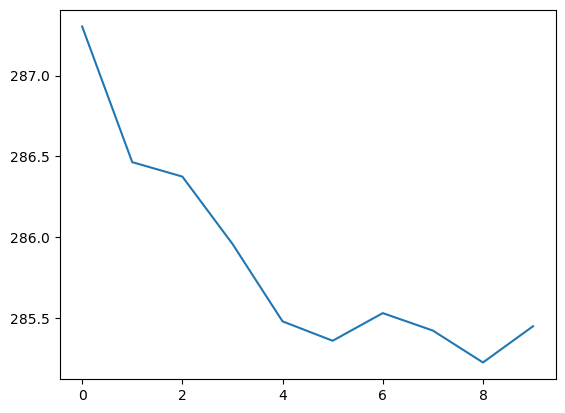

In [399]:
plt.plot(loss_list)

In [403]:
kernel_XX_se = se_kernel_custom(h, h,gamma=gamma)
kernel_YY_se = se_kernel_custom(samples, samples,gamma=gamma)
kernel_XY_se = se_kernel_custom(h, samples,gamma=gamma)
loss_MMD=compute_mmd(kernel_XX_se, kernel_YY_se, kernel_XY_se)

RuntimeError: The size of tensor a (600) must match the size of tensor b (6) at non-singleton dimension 0

In [401]:
loss_MMD

tensor(290.4218, grad_fn=<SqrtBackward0>)